In [ ]:

curl "https://eservice.ura.gov.sg/uraDataService/invokeUraDS/v1?service=PMI_Resi_Transaction&batch=1"
  -H "AccessKey: accesskey"
  -H "Token: token"




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
!git config --global user.email "meartee@gmail.com"

In [ ]:
!git clone https://github.com/akuaku/singapore-property-prediction.git

Cloning into 'singapore-property-prediction'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 74 (delta 14), reused 70 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (74/74), 14.08 MiB | 14.45 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
%cd singapore-property-prediction

[Errno 2] No such file or directory: 'singapore-property-prediction'
/content


In [ ]:
print("Files in repository:")
!ls -la

Files in repository:
total 67136
drwxr-xr-x 5 root root     4096 May  8 02:27 .
drwxr-xr-x 1 root root     4096 May  8 02:27 ..
drwxr-xr-x 8 root root     4096 May  8 02:27 .git
-rw-r--r-- 1 root root      409 May  8 02:27 .gitignore
-rw-r--r-- 1 root root 34333602 May  8 02:27 hdb_resale_data_combined.csv
-rw-r--r-- 1 root root 34333602 May  8 02:27 hdb_resale_data.csv
-rw-r--r-- 1 root root    35842 May  8 02:27 hdb_transactions_by_quarter.png
drwxr-xr-x 2 root root     4096 May  8 02:27 quarterly_data
-rw-r--r-- 1 root root      544 May  8 02:27 README.md
drwxr-xr-x 2 root root     4096 May  8 02:27 src


#Generation of URA token (daily required)


In [ ]:
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

def get_ura_token(access_key):
    """
    Generate a new URA API token using your access key.

    Args:
        access_key (str): Your URA API access key

    Returns:
        str: The generated token or None if request failed
    """
    url = "https://eservice.ura.gov.sg/uraDataService/insertNewToken/v1"

    headers = {
        "AccessKey": access_key,
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    try:
        response = requests.get(
            url,
            headers=headers,
            timeout=30,
            allow_redirects=True,
            verify=False
        )

        print(f"Status code: {response.status_code}")
        print(f"Response text: {response.text}")

        if not response.text.strip():
            print("Empty response received")
            return None

        if response.text.strip().startswith('{') and response.text.strip().endswith('}'):
            try:
                result = response.json()
                token = result.get("Result")
                status = result.get("Status")
                message = result.get("Message", "")

                if status == "Success" and token:
                    print("Token generated successfully!")
                    return token
                else:
                    print(f"Failed to generate token. Status: {status}, Message: {message}")
                    return None
            except ValueError as e:
                print(f"Error parsing JSON response: {str(e)}")
                print(f"Raw response: {repr(response.text)}")
                return None
        else:
            print(f"Response doesn't appear to be JSON: {response.text}")
            return None

    except Exception as e:
        print(f"Error generating token: {str(e)}")
        return None

access_key = "7f788322-97ae-4608-9bc5-6c87d77bce8c"
token = get_ura_token(access_key)

if token:
    print(f"Your token: {token}")
    print("Important: This token is valid for 24 hours only")
else:
    print("Failed to generate token. Please check your access key.")

Status code: 200
Response text: {"Status":"Success","Message":"","Result":"es-77Bd8-p7b9-c4p22cRc7-j8e85R9b20cs--tN7Hd7+m7YRFHk6V@732qfn-8r8Y7keEZEZQ27c70wG57es6czbXaCv7P8@-Jn"}
Token generated successfully!
Your token: es-77Bd8-p7b9-c4p22cRc7-j8e85R9b20cs--tN7Hd7+m7YRFHk6V@732qfn-8r8Y7keEZEZQ27c70wG57es6czbXaCv7P8@-Jn
Important: This token is valid for 24 hours only


# Verify API key and acess token validity

In [ ]:
import requests

headers = {
    'AccessKey': '7f788322-97ae-4608-9bc5-6c87d77bce8c',
    'Token': 'es-77Bd8-p7b9-c4p22cRc7-j8e85R9b20cs--tN7Hd7+m7YRFHk6V@732qfn-8r8Y7keEZEZQ27c70wG57es6czbXaCv7P8@-Jn',
}

response = requests.get('https://www.ura.gov.sg/uraDataService/invokeUraDS?service=PMI_Resi_Transaction', headers=headers)
print(response.status_code)

200


#URA Data collection

In [ ]:

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime

os.makedirs("data/ura/raw", exist_ok=True)
os.makedirs("data/ura/processed", exist_ok=True)

ACCESS_KEY = "7f788322-97ae-4608-9bc5-6c87d77bce8c"
TOKEN = "es-77Bd8-p7b9-c4p22cRc7-j8e85R9b20cs--tN7Hd7+m7YRFHk6V@732qfn-8r8Y7keEZEZQ27c70wG57es6czbXaCv7P8@-Jn"

def collect_ura_data():
    """Collect private residential transaction data with better error handling"""
    base_url = "https://eservice.ura.gov.sg/uraDataService"
    headers = {
        "AccessKey": ACCESS_KEY,
        "Token": TOKEN,
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36",
        "Accept": "application/json, text/plain, */*",
        "Accept-Language": "en-US,en;q=0.9",
        "Origin": "https://eservice.ura.gov.sg",
        "Referer": "https://eservice.ura.gov.sg/"
    }

    all_transactions = []

    max_batches = 10

    for batch in range(1, max_batches + 1):
        url = f"{base_url}/invokeUraDS/v1"
        params = {
            "service": "PMI_Resi_Transaction",
            "batch": batch
        }

        print(f"Collecting batch {batch}...")

        try:
            response = requests.get(url, headers=headers, params=params)

            if response.status_code != 200:
                print(f"Error fetching batch {batch}: HTTP {response.status_code}")
                print(f"Response text: {response.text[:200]}...")
                break

            data = response.json()

            if data.get("Status") != "Success":
                print(f"API returned unsuccessful status for batch {batch}: {data}")

                if batch > 1:
                    break

            transactions = data.get("Result", [])

            if not transactions:
                print(f"No transactions in batch {batch}")
                break

            print(f"Collected {len(transactions)} transactions in batch {batch}")

            if batch == 1 and transactions:
                print("\nSample transaction data structure:")
                for key, value in transactions[0].items():
                    print(f"- {key}: {value}")

            all_transactions.extend(transactions)

            batch_filename = f"data/ura/raw/ura_transactions_batch_{batch}.json"
            with open(batch_filename, "w") as f:
                json.dump(transactions, f)

        except Exception as e:
            print(f"Error processing batch {batch}: {str(e)}")
            break

    if all_transactions:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"data/ura/raw/ura_transactions_all_{timestamp}.json"

        with open(filename, "w") as f:
            json.dump(all_transactions, f)

        print(f"Saved {len(all_transactions)} total transactions to {filename}")
    else:
        print("No data collected to save")

    return all_transactions

def process_ura_data(transactions):
    if not transactions:
        print("No transaction data to process")
        return None

    df = pd.DataFrame(transactions)

    print("\nAvailable columns:")
    for col in df.columns:
        print(f"- {col}")

    print("\nSample values for each column:")
    for col in df.columns:
        sample_values = df[col].head(3).tolist()
        print(f"- {col}: {sample_values}")

    try:
        if 'transaction' in df.columns:
            print("\nExamining transaction column for date information...")
            print(df['transaction'].head(10).tolist())

            try:
                df['transaction_text'] = df['transaction'].astype(str)

                if df['transaction_text'].str.contains(r'\d{4}[-/]\d{1,2}[-/]\d{1,2}').any():
                    df['extracted_date'] = df['transaction_text'].str.extract(r'(\d{4}[-/]\d{1,2}[-/]\d{1,2})')
                    df['transaction_date'] = pd.to_datetime(df['extracted_date'], errors='coerce')
                    print("Extracted dates from transaction column")

                elif df['transaction_text'].str.contains(r'Q[1-4]').any():
                    df['extracted_year'] = df['transaction_text'].str.extract(r'(\d{4})')
                    df['extracted_quarter'] = df['transaction_text'].str.extract(r'Q([1-4])')

                    df['year'] = pd.to_numeric(df['extracted_year'], errors='coerce')
                    df['quarter'] = pd.to_numeric(df['extracted_quarter'], errors='coerce')

                    quarter_month = {1: 1, 2: 4, 3: 7, 4: 10}
                    df['month'] = df['quarter'].map(quarter_month)

                    df['transaction_date'] = pd.to_datetime(
                        df['year'].astype(str) + '-' + df['month'].astype(str) + '-15',
                        errors='coerce'
                    )
                    print("Extracted year and quarter information")

            except Exception as date_error:
                print(f"Error extracting date information: {date_error}")
                print("Unable to extract date information automatically")

                df['year'] = "Unknown"
                df['quarter'] = "Unknown"

        if 'project' in df.columns:
            df['project_name'] = df['project'].astype(str).str.strip()

        if 'marketSegment' in df.columns:
            df['property_type'] = df['marketSegment'].astype(str).str.strip()

        if 'x' in df.columns and 'y' in df.columns:
            df['x_coord'] = pd.to_numeric(df['x'], errors='coerce')
            df['y_coord'] = pd.to_numeric(df['y'], errors='coerce')

        timestamp = datetime.now().strftime("%Y%m%d")
        output_file = f"data/ura/processed/ura_transactions_processed_{timestamp}.csv"
        df.to_csv(output_file, index=False)
        print(f"\nProcessed data saved to {output_file}")

        if 'property_type' in df.columns:
            try:
                plt.figure(figsize=(10, 6))
                df['property_type'].value_counts().plot(kind='bar')
                plt.title('Transaction Count by Property Type')
                plt.xlabel('Property Type')
                plt.ylabel('Number of Transactions')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.savefig('data/ura/processed/property_type_distribution.png')
                plt.close()
                print("Created property type distribution visualization")
            except Exception as viz_error:
                print(f"Error creating visualization: {viz_error}")

        return df

    except Exception as e:
        print(f"Error processing data: {str(e)}")
        df.to_csv("data/ura/processed/ura_transactions_error.csv", index=False)
        print("Raw data saved for inspection")
        return df

print("Starting URA data collection...")
transactions = collect_ura_data()

print("\nProcessing collected data...")
processed_df = process_ura_data(transactions)

print("\nData collection and processing complete!")

Starting URA data collection...
Collected 293 transactions in batch 1

Sample transaction data structure:
- street: NEO PEE TECK LANE
- x: 20914.1988965525
- project: LANDED HOUSING DEVELOPMENT
- y: 30589.1070785135
- transaction: [{'area': '186', 'floorRange': '-', 'noOfUnits': '1', 'contractDate': '0321', 'typeOfSale': '3', 'price': '1880000', 'propertyType': 'Strata Terrace', 'district': '05', 'typeOfArea': 'Strata', 'tenure': 'Freehold'}, {'area': '257', 'floorRange': '-', 'noOfUnits': '1', 'contractDate': '0522', 'typeOfSale': '3', 'price': '4600000', 'propertyType': 'Terrace', 'district': '05', 'typeOfArea': 'Land', 'tenure': 'Freehold'}]
- marketSegment: RCR
Collected 1629 transactions in batch 2
Collected 1684 transactions in batch 3
Collected 388 transactions in batch 4
API returned unsuccessful status for batch 5: {'Status': 'Error', 'Message': 'Invalid input'}
Saved 3994 total transactions to data/ura/raw/ura_transactions_all_20250508_032247.json

Processing collected data..

In [ ]:

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

data_file = "data/ura/raw/ura_transactions_all_20250508_031908.json"
with open(data_file, 'r') as f:
    raw_data = json.load(f)

flattened_data = []

for property_record in raw_data:
    property_info = {
        'street': property_record.get('street'),
        'project_name': property_record.get('project'),
        'x_coord': property_record.get('x'),
        'y_coord': property_record.get('y'),
        'market_segment': property_record.get('marketSegment')
    }

    transactions = property_record.get('transaction', [])
    if not isinstance(transactions, list):
        continue

    for transaction in transactions:
        record = property_info.copy()

        record.update({
            'area_sqm': transaction.get('area'),
            'floor_range': transaction.get('floorRange'),
            'units': transaction.get('noOfUnits'),
            'contract_date_raw': transaction.get('contractDate'),
            'type_of_sale': transaction.get('typeOfSale'),
            'price': transaction.get('price'),
            'property_type': transaction.get('propertyType'),
            'district': transaction.get('district'),
            'type_of_area': transaction.get('typeOfArea'),
            'tenure': transaction.get('tenure')
        })

        flattened_data.append(record)

df = pd.DataFrame(flattened_data)

def parse_contract_date(date_str):
    if not date_str or not isinstance(date_str, str):
        return None

    if len(date_str) == 4:
        month = int(date_str[:2])
        year = int(date_str[2:])
        year = 2000 + year
        try:
            return pd.Timestamp(year=year, month=month, day=15)
        except:
            return None
    return None

df['transaction_date'] = df['contract_date_raw'].apply(parse_contract_date)
df['year'] = df['transaction_date'].dt.year
df['quarter'] = df['transaction_date'].dt.quarter
df['year_quarter'] = df['year'].astype(str) + 'Q' + df['quarter'].astype(str)

df['area_sqm'] = pd.to_numeric(df['area_sqm'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

df['price_psm'] = df['price'] / df['area_sqm']

start_date = '2017-01-01'
end_date = '2025-03-31'
df_filtered = df[(df['transaction_date'] >= start_date) & (df['transaction_date'] <= end_date)]

output_file = f"data/ura/processed/ura_transactions_processed_flat_{datetime.now().strftime('%Y%m%d')}.csv"
df_filtered.to_csv(output_file, index=False)
print(f"Saved flattened data to {output_file}")
print(f"Total transactions processed: {len(df)}")
print(f"Transactions from 2017 Q1 to 2025 Q1: {len(df_filtered)}")

print("\nTransaction count by year:")
year_counts = df_filtered.groupby('year').size().sort_index()
print(year_counts)

print("\nTransaction count by property type:")
type_counts = df_filtered.groupby('property_type').size().sort_values(ascending=False)
print(type_counts.head(10))

print("\nTransaction count by district:")
district_counts = df_filtered.groupby('district').size().sort_values(ascending=False)
print(district_counts.head(10))

print("\nPrice statistics by property type:")
price_stats = df_filtered.groupby('property_type')['price'].mean().sort_values(ascending=False)
print(price_stats.head(10))


plt.figure(figsize=(14, 7))
quarterly_counts = df_filtered.groupby('year_quarter').size().reset_index(name='count')
quarterly_counts = quarterly_counts.sort_values('year_quarter')

plt.bar(quarterly_counts['year_quarter'], quarterly_counts['count'])
plt.title('Transaction Volume by Quarter (2017 Q1 - 2025 Q1)', fontsize=15)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('data/ura/processed/quarterly_transaction_volume.png')
plt.close()

plt.figure(figsize=(14, 7))
quarterly_prices = df_filtered.groupby('year_quarter')['price_psm'].median().reset_index()
quarterly_prices = quarterly_prices.sort_values('year_quarter')

plt.plot(quarterly_prices['year_quarter'], quarterly_prices['price_psm'], marker='o', linewidth=2)
plt.title('Median Price per Square Meter by Quarter (2017 Q1 - 2025 Q1)', fontsize=15)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Median Price (PSM)', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('data/ura/processed/quarterly_price_trend.png')
plt.close()

plt.figure(figsize=(12, 8))
type_counts_plot = df_filtered.groupby('property_type').size().sort_values(ascending=False).head(10)
sns.barplot(x=type_counts_plot.index, y=type_counts_plot.values)
plt.title('Top 10 Property Types by Transaction Count', fontsize=15)
plt.xlabel('Property Type', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('data/ura/processed/property_type_distribution.png')
plt.close()

plt.figure(figsize=(14, 8))
district_prices = df_filtered.groupby('district')['price_psm'].median().sort_values(ascending=False).head(15)
sns.barplot(x=district_prices.index, y=district_prices.values)
plt.title('Median Price per Square Meter by District (Top 15)', fontsize=15)
plt.xlabel('District', fontsize=12)
plt.ylabel('Median Price (PSM)', fontsize=12)
plt.tight_layout()
plt.savefig('data/ura/processed/district_price_comparison.png')
plt.close()

print("\nVisualizations created in the data/ura/processed directory")

Saved flattened data to data/ura/processed/ura_transactions_processed_flat_20250508.csv
Total transactions processed: 140697
Transactions from 2017 Q1 to 2025 Q1: 138735

Transaction count by year:
year
2020    17801
2021    38709
2022    25649
2023    22351
2024    25646
2025     8579
dtype: int64

Transaction count by property type:
property_type
Condominium              55738
Apartment                52775
Executive Condominium    16254
Terrace                   6439
Semi-detached             3925
Detached                  1781
Strata Terrace            1211
Strata Semi-detached       481
Strata Detached            131
dtype: int64

Transaction count by district:
district
19    17650
15    12166
18    10940
05     9888
23     8590
10     8174
21     6604
14     6056
27     5666
09     5356
dtype: int64

Price statistics by property type:
property_type
Detached                 1.276573e+07
Semi-detached            5.843133e+06
Strata Detached          4.050488e+06
Strata Semi-detache

In [ ]:
from google.colab import files

files.download('data/ura/processed/ura_transactions_processed_flat_20250508.csv')

files.download('data/ura/processed/quarterly_transaction_volume.png')
files.download('data/ura/processed/quarterly_price_trend.png')
files.download('data/ura/processed/property_type_distribution.png')
files.download('data/ura/processed/district_price_comparison.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
os.makedirs('/content/drive/MyDrive/singapore-property-prediction/data/ura/processed', exist_ok=True)

!cp data/ura/processed/ura_transactions_processed_flat_20250508.csv /content/drive/MyDrive/singapore-property-prediction/data/ura/processed/

!cp data/ura/processed/*.png /content/drive/MyDrive/singapore-property-prediction/data/ura/processed/

print("Files saved to Google Drive in the singapore-property-prediction folder")

Files saved to Google Drive in the singapore-property-prediction folder


In [ ]:
!ls -la

total 67140
drwxr-xr-x 6 root root     4096 May  8 03:12 .
drwxr-xr-x 1 root root     4096 May  8 02:27 ..
drwxr-xr-x 3 root root     4096 May  8 03:12 data
drwxr-xr-x 8 root root     4096 May  8 02:27 .git
-rw-r--r-- 1 root root      409 May  8 02:27 .gitignore
-rw-r--r-- 1 root root 34333602 May  8 02:27 hdb_resale_data_combined.csv
-rw-r--r-- 1 root root 34333602 May  8 02:27 hdb_resale_data.csv
-rw-r--r-- 1 root root    35842 May  8 02:27 hdb_transactions_by_quarter.png
drwxr-xr-x 2 root root     4096 May  8 02:27 quarterly_data
-rw-r--r-- 1 root root      544 May  8 02:27 README.md
drwxr-xr-x 2 root root     4096 May  8 02:27 src


In [ ]:
!ls -la data/ura/processed

total 121292
drwxr-xr-x 2 root root     4096 May  8 03:25 .
drwxr-xr-x 4 root root     4096 May  8 03:12 ..
-rw-r--r-- 1 root root    32140 May  8 03:25 district_price_comparison.png
-rw-r--r-- 1 root root    57329 May  8 03:25 property_type_distribution.png
-rw-r--r-- 1 root root    68900 May  8 03:25 quarterly_price_trend.png
-rw-r--r-- 1 root root    33882 May  8 03:25 quarterly_transaction_volume.png
-rw-r--r-- 1 root root 33146419 May  8 03:19 ura_transactions_2017Q1_to_2025Q1_20250508.csv
-rw-r--r-- 1 root root 66091547 May  8 03:22 ura_transactions_processed_20250508.csv
-rw-r--r-- 1 root root 24752116 May  8 03:25 ura_transactions_processed_flat_20250508.csv


In [ ]:
!ls -la data/ura/processed

total 121292
drwxr-xr-x 2 root root     4096 May  8 03:25 .
drwxr-xr-x 4 root root     4096 May  8 03:12 ..
-rw-r--r-- 1 root root    32140 May  8 03:25 district_price_comparison.png
-rw-r--r-- 1 root root    57329 May  8 03:25 property_type_distribution.png
-rw-r--r-- 1 root root    68900 May  8 03:25 quarterly_price_trend.png
-rw-r--r-- 1 root root    33882 May  8 03:25 quarterly_transaction_volume.png
-rw-r--r-- 1 root root 33146419 May  8 03:19 ura_transactions_2017Q1_to_2025Q1_20250508.csv
-rw-r--r-- 1 root root 66091547 May  8 03:22 ura_transactions_processed_20250508.csv
-rw-r--r-- 1 root root 24752116 May  8 03:25 ura_transactions_processed_flat_20250508.csv


#Reload data if time out

In [ ]:
!git clone https://github.com/akuaku/singapore-property-prediction.git

Cloning into 'singapore-property-prediction'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 74 (delta 14), reused 70 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (74/74), 14.08 MiB | 7.22 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Updating files: 100% (53/53), done.


In [ ]:
%cd singapore-property-prediction

/content/singapore-property-prediction


In [ ]:
!ls -la data/ura/processed

total 24372
drwxr-xr-x 2 root root     4096 May  9 04:07 .
drwxr-xr-x 3 root root     4096 May  9 04:07 ..
-rw-r--r-- 1 root root    32140 May  9 04:07 district_price_comparison.png
-rw-r--r-- 1 root root    57329 May  9 04:07 property_type_distribution.png
-rw-r--r-- 1 root root    68900 May  9 04:07 quarterly_price_trend.png
-rw-r--r-- 1 root root    33882 May  9 04:07 quarterly_transaction_volume.png
-rw-r--r-- 1 root root 24752116 May  9 04:07 ura_transactions_processed_flat_20250508.csv


In [ ]:
!pwd

/content/singapore-property-prediction


In [ ]:
!git add data/ura/processed/ura_transactions_processed_flat_20250508.csv
!git add data/ura/processed/*.png

In [ ]:
!git add src/data_collection.py

In [ ]:
!git commit -m "Add processed URA property transaction data and visualization charts"

[main 2a963a0] Add processed URA property transaction data and visualization charts
 5 files changed, 138736 insertions(+)
 create mode 100644 data/ura/processed/district_price_comparison.png
 create mode 100644 data/ura/processed/property_type_distribution.png
 create mode 100644 data/ura/processed/quarterly_price_trend.png
 create mode 100644 data/ura/processed/quarterly_transaction_volume.png
 create mode 100644 data/ura/processed/ura_transactions_processed_flat_20250508.csv


In [ ]:
!git config --global user.email "meartee@gmail.com"
!git config --global user.name "akuaku"

Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 2 threads
Compressing objects: 100% (8/8), done.
Writing objects: 100% (10/10), 2.58 MiB | 2.90 MiB/s, done.
Total 10 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/akuaku/singapore-property-prediction.git
   2f450fa..2a963a0  main -> main


#Geocoding with OneMap API

#Sample batch running

In [ ]:
import requests
import pandas as pd
import time
import json
import os
from datetime import datetime

df = pd.read_csv('data/ura/processed/ura_transactions_processed_flat_20250508.csv')

def geocode_address(address):
    base_url = "https://www.onemap.gov.sg/api/common/elastic/search"

    params = {
        'searchVal': address,
        'returnGeom': 'Y',
        'getAddrDetails': 'Y',
        'pageNum': 1
    }

    try:
        response = requests.get(base_url, params=params)

        if response.status_code == 200:
            data = response.json()
            if data['found'] > 0 and len(data['results']) > 0:
                result = data['results'][0]
                return {
                    'latitude': float(result['LATITUDE']),
                    'longitude': float(result['LONGITUDE']),
                    'postal_code': result.get('POSTAL', ''),
                    'building_name': result.get('BUILDING', ''),
                    'address': result.get('ADDRESS', ''),
                    'success': True
                }

        return {
            'latitude': None,
            'longitude': None,
            'postal_code': None,
            'building_name': None,
            'address': None,
            'success': False
        }

    except Exception as e:
        print(f"Error geocoding {address}: {str(e)}")
        return {
            'latitude': None,
            'longitude': None,
            'postal_code': None,
            'building_name': None,
            'address': None,
            'success': False,
            'error': str(e)
        }

def create_geocoding_address(row):
    address_parts = []

    if pd.notna(row.get('street')):
        address_parts.append(row['street'])

    if pd.notna(row.get('project_name')):

        if row['project_name'] != 'LANDED HOUSING DEVELOPMENT':
            address_parts.append(row['project_name'])

    if pd.notna(row.get('district')):
        address_parts.append(f"DISTRICT {row['district']}")

    return ' '.join(address_parts)

sample_size = 500
sample_df = df.sample(n=min(sample_size, len(df)), random_state=42)

sample_df['geocoding_address'] = sample_df.apply(create_geocoding_address, axis=1)

geocoding_results = []

for index, row in sample_df.iterrows():
    if index % 10 == 0:
        print(f"Processing record {index} of {len(sample_df)}")

    address = row['geocoding_address']
    result = geocode_address(address)

    result['original_index'] = index
    result['geocoding_address'] = address

    geocoding_results.append(result)

    time.sleep(0.5)

geocoded_df = pd.DataFrame(geocoding_results)

success_rate = geocoded_df['success'].mean() * 100
print(f"Geocoding success rate: {success_rate:.2f}%")

geocoded_df.to_csv('data/ura/processed/geocoding_test_results.csv', index=False)

Processing record 50040 of 500
Processing record 23870 of 500
Processing record 101300 of 500
Processing record 15920 of 500
Processing record 2320 of 500
Processing record 73810 of 500
Processing record 121580 of 500
Processing record 87690 of 500
Processing record 31690 of 500
Processing record 33200 of 500
Processing record 75590 of 500
Processing record 120000 of 500
Processing record 17210 of 500
Processing record 125600 of 500
Processing record 44170 of 500
Processing record 89870 of 500
Processing record 95620 of 500
Processing record 16520 of 500
Processing record 44990 of 500
Processing record 67640 of 500
Processing record 112790 of 500
Processing record 130890 of 500
Processing record 123780 of 500
Processing record 82950 of 500
Processing record 57510 of 500
Processing record 136040 of 500
Processing record 20280 of 500
Processing record 101920 of 500
Processing record 60160 of 500
Processing record 41180 of 500
Processing record 106370 of 500
Processing record 120250 of 50

#Re-run if disconnect or timeout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content


In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import requests
import time
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')


backup_pattern = "data/ura/processed/geocoding_backups_*/geocoded_batch_*.csv"
drive_backup_pattern = "/content/drive/MyDrive/singapore-property-prediction/data/geocoding_backups/geocoded_batch_*.csv"

colab_backups = glob.glob(backup_pattern)
drive_backups = glob.glob(drive_backup_pattern)

all_backups = colab_backups + drive_backups

if all_backups:
    latest_backup = max(all_backups, key=os.path.getmtime)
    print(f"Found latest backup: {latest_backup}")

    df = pd.read_csv(latest_backup)

    total_records = len(df)
    completed = (df['geocoding_success'] == True).sum()
    remaining = total_records - completed

    print(f"Progress: {completed}/{total_records} records processed ({completed/total_records*100:.1f}%)")
    print(f"Remaining: {remaining} records")
else:
    print("No backup files found. Will need to restart from the beginning.")

    df = pd.read_csv('data/ura/processed/ura_transactions_processed_flat_20250508.csv')
    print("Loaded original dataset with no geocoding progress")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found latest backup: /content/drive/MyDrive/singapore-property-prediction/data/geocoding_backups/geocoded_batch_2410_20250511_104356.csv
Progress: 120494/138735 records processed (86.9%)
Remaining: 18241 records


<ipython-input-2-cfaaae5ded6c>:32: DtypeWarning: Columns (23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(latest_backup)


#Full Batch Running

In [ ]:
%cd singapore-property-prediction

[Errno 2] No such file or directory: 'singapore-property-prediction'
/content


#Full Batch running 1 - modified code for disconnection

In [ ]:
import requests
import pandas as pd
import numpy as np
import time
import json
import os
import glob
from datetime import datetime

try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✅ Google Drive mounted successfully")

    drive_backup_dir = "/content/drive/My Drive/singapore-property-prediction/data/geocoding_backups"
    os.makedirs(drive_backup_dir, exist_ok=True)
    print(f"✅ Created backup directory at: {drive_backup_dir}")
except Exception as e:
    print(f"⚠️ Warning: Could not mount Google Drive: {str(e)}")
    print("Will continue processing, but backups to Google Drive will not be available.")

latest_backup = None
try:
    backup_paths = [
        "/content/drive/My Drive/singapore-property-prediction/data/geocoding_backups",
        "/content/drive/MyDrive/singapore-property-prediction/data/geocoding_backups"
    ]

    all_backups = []
    for path in backup_paths:
        if os.path.exists(path):

            batch_files = glob.glob(f"{path}/geocoded_batch_*_*.csv")
            if batch_files:
                all_backups.extend(batch_files)


            latest_file = f"{path}/geocoded_latest.csv"
            if os.path.exists(latest_file):
                all_backups.append(latest_file)

    if all_backups:
        latest_backup = max(all_backups, key=os.path.getmtime)
        print(f"Found latest backup: {latest_backup}")

        df = pd.read_csv(latest_backup, low_memory=False)
        processed_count = (df['geocoding_success'] == True).sum()
        total_count = len(df)
        print(f"Progress: {processed_count}/{total_count} records processed ({processed_count/total_count*100:.1f}%)")
        print(f"Remaining: {total_count - processed_count} records")
        print("✅ Resuming from latest backup")
    else:
        df = pd.read_csv('data/ura/processed/ura_transactions_processed_flat_20250508.csv')
        print(f"Loaded dataset with {len(df)} records")

        if 'geocoding_address' not in df.columns:
            def create_geocoding_address(row):
                address_parts = []

                if pd.notna(row.get('street')):
                    address_parts.append(row['street'])

                if pd.notna(row.get('project_name')):
                    if row['project_name'] != 'LANDED HOUSING DEVELOPMENT':
                        address_parts.append(row['project_name'])

                if pd.notna(row.get('district')):
                    address_parts.append(f"DISTRICT {row['district']}")

                return ' '.join(address_parts)

            df['geocoding_address'] = df.apply(create_geocoding_address, axis=1)
            print("Added geocoding_address column")
except Exception as e:
    print(f"⚠️ Error checking for backups: {str(e)}")
    df = pd.read_csv('data/ura/processed/ura_transactions_processed_flat_20250508.csv')
    print(f"Loaded dataset with {len(df)} records")

    if 'geocoding_address' not in df.columns:
        def create_geocoding_address(row):
            address_parts = []

            if pd.notna(row.get('street')):
                address_parts.append(row['street'])

            if pd.notna(row.get('project_name')):
                if row['project_name'] != 'LANDED HOUSING DEVELOPMENT':
                    address_parts.append(row['project_name'])

            if pd.notna(row.get('district')):
                address_parts.append(f"DISTRICT {row['district']}")

            return ' '.join(address_parts)

        df['geocoding_address'] = df.apply(create_geocoding_address, axis=1)
        print("Added geocoding_address column")

def geocode_address(address):
    base_url = "https://www.onemap.gov.sg/api/common/elastic/search"

    params = {
        'searchVal': address,
        'returnGeom': 'Y',
        'getAddrDetails': 'Y',
        'pageNum': 1
    }

    try:
        response = requests.get(base_url, params=params)

        if response.status_code == 200:
            data = response.json()
            if data['found'] > 0 and len(data['results']) > 0:
                result = data['results'][0]
                return {
                    'latitude': float(result['LATITUDE']),
                    'longitude': float(result['LONGITUDE']),
                    'postal_code': result.get('POSTAL', ''),
                    'building_name': result.get('BUILDING', ''),
                    'address': result.get('ADDRESS', ''),
                    'success': True
                }

        return {
            'latitude': None,
            'longitude': None,
            'postal_code': None,
            'building_name': None,
            'address': None,
            'success': False
        }

    except Exception as e:
        print(f"Error geocoding {address}: {str(e)}")
        return {
            'latitude': None,
            'longitude': None,
            'postal_code': None,
            'building_name': None,
            'address': None,
            'success': False,
            'error': str(e)
        }

def batch_geocode_addresses(df, batch_size=50, sleep_between_records=0.5,
                           sleep_between_batches=5, save_every_n_batches=10):
    """
    Process geocoding in batches with automatic backup to Google Drive

    Args:
        df: DataFrame with addresses to geocode
        batch_size: Number of records to process in each batch
        sleep_between_records: Sleep time between individual API calls (seconds)
        sleep_between_batches: Sleep time between batches (seconds)
        save_every_n_batches: Save to Google Drive after this many batches
    """
    if 'latitude' not in df.columns:
        df['latitude'] = None
    if 'longitude' not in df.columns:
        df['longitude'] = None
    if 'geocoded_postal_code' not in df.columns:
        df['geocoded_postal_code'] = None
    if 'geocoded_building' not in df.columns:
        df['geocoded_building'] = None
    if 'geocoded_address' not in df.columns:
        df['geocoded_address'] = None
    if 'geocoding_success' not in df.columns:
        df['geocoding_success'] = False

    n_records = len(df)
    n_batches = (n_records + batch_size - 1) // batch_size

    print(f"Processing {n_records} records in {n_batches} batches")

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    backup_dir = f"data/ura/processed/geocoding_backups_{timestamp}"
    os.makedirs(backup_dir, exist_ok=True)

    start_time = datetime.now()
    success_count = 0
    already_processed = (df['geocoding_success'] == True).sum()

    if already_processed > 0:
        print(f"Found {already_processed} already processed records - will skip these")
        success_count = already_processed

    for batch_num in range(n_batches):
        batch_start = batch_num * batch_size
        batch_end = min((batch_num + 1) * batch_size, n_records)

        print(f"\nProcessing batch {batch_num+1}/{n_batches} (records {batch_start+1} to {batch_end})")

        batch_success = 0
        batch_total = 0

        for i in range(batch_start, batch_end):
            if pd.isna(df.at[i, 'geocoding_address']) or df.at[i, 'geocoding_success'] == True:
                if df.at[i, 'geocoding_success'] == True:
                    print(f"Skipping record {i+1} (already geocoded)")
                else:
                    print(f"Skipping record {i+1} (empty address)")
                continue

            address = df.at[i, 'geocoding_address']
            batch_total += 1

            print(f"Geocoding {i+1}/{n_records}: {address}")

            result = geocode_address(address)

            df.at[i, 'latitude'] = result['latitude']
            df.at[i, 'longitude'] = result['longitude']
            df.at[i, 'geocoded_postal_code'] = result['postal_code']
            df.at[i, 'geocoded_building'] = result['building_name']
            df.at[i, 'geocoded_address'] = result['address']
            df.at[i, 'geocoding_success'] = result['success']

            if result['success']:
                success_count += 1
                batch_success += 1

            time.sleep(sleep_between_records)

        progress = (batch_end / n_records) * 100
        elapsed = datetime.now() - start_time
        success_rate = (success_count / (batch_end - already_processed)) * 100 if (batch_end - already_processed) > 0 else 100

        if batch_total > 0:
            batch_success_rate = (batch_success / batch_total) * 100
            print(f"Batch {batch_num+1} results: {batch_success}/{batch_total} successful ({batch_success_rate:.1f}%)")

        print(f"Overall progress: {progress:.1f}% | Success rate: {success_rate:.1f}% | Elapsed: {elapsed}")

        if (batch_num + 1) % save_every_n_batches == 0 or batch_num == n_batches - 1:
            backup_file = f"{backup_dir}/geocoded_batch_{batch_num+1}.csv"
            df.to_csv(backup_file, index=False)
            print(f"Saved backup to {backup_file}")

            try:
                if not os.path.exists('/content/drive'):
                    from google.colab import drive
                    print("Mounting Google Drive...")
                    drive.mount('/content/drive')

                drive_path = "/content/drive/My Drive/singapore-property-prediction/data/geocoding_backups"
                os.makedirs(drive_path, exist_ok=True)

                drive_file = f"{drive_path}/geocoded_batch_{batch_num+1}_{timestamp}.csv"
                df.to_csv(drive_file, index=False)
                print(f"✅ Saved backup to Google Drive: {drive_file}")

                latest_file = f"{drive_path}/geocoded_latest.csv"
                df.to_csv(latest_file, index=False)
                print(f"✅ Saved latest version to Google Drive: {latest_file}")
            except Exception as e:
                print(f"⚠️ Error saving to Google Drive: {str(e)}")
                print("Will continue processing, but Google Drive backup failed.")

        if batch_num < n_batches - 1:
            print(f"Sleeping for {sleep_between_batches} seconds before next batch...")
            time.sleep(sleep_between_batches)

    final_file = f"data/ura/processed/geocoded_properties_full.csv"
    df.to_csv(final_file, index=False)
    print(f"\nGeocoding completed! Results saved to {final_file}")
    print(f"Total records: {n_records} | Successfully geocoded: {success_count} | Success rate: {(success_count/n_records)*100:.1f}%")

    try:
        if os.path.exists('/content/drive'):
            drive_path = "/content/drive/My Drive/singapore-property-prediction/data/geocoding_backups"
            final_drive_file = f"{drive_path}/geocoded_properties_full_{timestamp}.csv"
            df.to_csv(final_drive_file, index=False)
            print(f"✅ Saved final results to Google Drive: {final_drive_file}")
    except Exception as e:
        print(f"⚠️ Error saving final results to Google Drive: {str(e)}")

    return df

geocoded_df = batch_geocode_addresses(df,
                                     batch_size=50,
                                     sleep_between_records=0.5,
                                     sleep_between_batches=5,
                                     save_every_n_batches=10)

Streaming output truncated to the last 5000 lines.
Geocoding 134222/138735: LAKESIDE DRIVE CASPIAN DISTRICT 22
Geocoding 134223/138735: LAKESIDE DRIVE CASPIAN DISTRICT 22
Geocoding 134224/138735: LAKESIDE DRIVE CASPIAN DISTRICT 22
Geocoding 134225/138735: LAKESIDE DRIVE CASPIAN DISTRICT 22
Geocoding 134226/138735: LAKESIDE DRIVE CASPIAN DISTRICT 22
Geocoding 134227/138735: LAKESIDE DRIVE CASPIAN DISTRICT 22
Geocoding 134228/138735: LAKESIDE DRIVE CASPIAN DISTRICT 22
Geocoding 134229/138735: LAKESIDE DRIVE CASPIAN DISTRICT 22
Geocoding 134230/138735: LAKESIDE DRIVE CASPIAN DISTRICT 22
Geocoding 134231/138735: LAKESIDE DRIVE CASPIAN DISTRICT 22
Geocoding 134232/138735: LAKESIDE DRIVE CASPIAN DISTRICT 22
Geocoding 134233/138735: LAKESIDE DRIVE CASPIAN DISTRICT 22
Geocoding 134234/138735: LAKESIDE DRIVE CASPIAN DISTRICT 22
Geocoding 134235/138735: LAKESIDE DRIVE CASPIAN DISTRICT 22
Geocoding 134236/138735: LAKESIDE DRIVE CASPIAN DISTRICT 22
Geocoding 134237/138735: LAKESIDE DRIVE CASPIAN D

In [ ]:
import pandas as pd
geocoded_df = pd.read_csv('data/ura/processed/geocoded_properties_full.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'data/ura/processed/geocoded_properties_full.csv'

In [ ]:
geocoded_df

street                project_name       x_coord  \
0       NEO PEE TECK LANE  LANDED HOUSING DEVELOPMENT  20914.198897   
1       NEO PEE TECK LANE  LANDED HOUSING DEVELOPMENT  20914.198897   
2            ZEHNDER ROAD  LANDED HOUSING DEVELOPMENT           NaN   
3            ZEHNDER ROAD  LANDED HOUSING DEVELOPMENT           NaN   
4              BEACH ROAD                       AUREA           NaN   
...                   ...                         ...           ...   
138730    GERALD CRESCENT     GERALD MUGLISTON ESTATE  32836.647100   
138731    GERALD CRESCENT     GERALD MUGLISTON ESTATE  32836.647100   
138732    GERALD CRESCENT     GERALD MUGLISTON ESTATE  32836.647100   
138733    GERALD CRESCENT     GERALD MUGLISTON ESTATE  32836.647100   
138734    GERALD CRESCENT     GERALD MUGLISTON ESTATE  32836.647100   

             y_coord market_segment  area_sqm floor_range  units  \
0       30589.107079            RCR     186.0           -      1   
1       30589.107079            RCR     257.0           -      1   
2                NaN            RCR     308.0           -      1   
3                NaN            RCR     228.4           -      1   
4                NaN            CCR     167.0       21-25      1   
...              ...            ...       ...         ...    ...   
138730  40981.743260            OCR     660.7           -      1   
138731  40981.743260            OCR     204.0           -      1   
138732  40981.743260            OCR     204.0           -      1   
138733  40981.743260            OCR     434.0           -      1   
138734  40981.743260            OCR     208.2           -      1   

        contract_date_raw  type_of_sale  ...  quarter year_quarter  \
0                     321             3  ...        1       2021Q1   
1                     522             3  ...        2       2022Q2   
2                     921             3  ...        3       2021Q3   
3                     724             3  ...        3       2024Q3   
4                     325             1  ...        1       2025Q1   
...                   ...           ...  ...      ...          ...   
138730                522             3  ...        2       2022Q2   
138731                421             2  ...        2       2021Q2   
138732                821             2  ...        3       2021Q3   
138733                623             3  ...        2       2023Q2   
138734                324             3  ...        1       2024Q1   

           price_psm                                  geocoding_address  \
0       10107.526882                       NEO PEE TECK LANE DISTRICT 5   
1       17898.832685                       NEO PEE TECK LANE DISTRICT 5   
2       16883.116883                            ZEHNDER ROAD DISTRICT 5   
3       22718.423818                            ZEHNDER ROAD DISTRICT 5   
4       34702.395210                        BEACH ROAD AUREA DISTRICT 7   
...              ...                                                ...   
138730  10216.437112  GERALD CRESCENT GERALD MUGLISTON ESTATE DISTRI...   
138731  20343.137255  GERALD CRESCENT GERALD MUGLISTON ESTATE DISTRI...   
138732  20343.137255  GERALD CRESCENT GERALD MUGLISTON ESTATE DISTRI...   
138733  10829.493088  GERALD CRESCENT GERALD MUGLISTON ESTATE DISTRI...   
138734  12487.992315  GERALD CRESCENT GERALD MUGLISTON ESTATE DISTRI...   

        latitude   longitude  geocoded_postal_code        geocoded_building  \
0       1.292487  103.769168                119038                      NIL   
1       1.292487  103.769168                119038                      NIL   
2       1.282861  103.785979                117695                      NIL   
3       1.282861  103.785979                117695                      NIL   
4       1.303082  103.865743                199980              AUREA (U/C)   
...          ...         ...                   ...                      ...   
138730  1.386169  103.877408                799689  GE

In [ ]:
geocoded_df.columns

Index(['street', 'project_name', 'x_coord', 'y_coord', 'market_segment',
       'area_sqm', 'floor_range', 'units', 'contract_date_raw', 'type_of_sale',
       'price', 'property_type', 'district', 'type_of_area', 'tenure',
       'transaction_date', 'year', 'quarter', 'year_quarter', 'price_psm',
       'geocoding_address', 'latitude', 'longitude', 'geocoded_postal_code',
       'geocoded_building', 'geocoded_address', 'geocoding_success'],
      dtype='object')

In [ ]:
geocoded_df.property_type.unique()

array(['Strata Terrace', 'Terrace', 'Semi-detached', 'Apartment',
       'Condominium', 'Detached', 'Strata Semi-detached',
       'Strata Detached', 'Executive Condominium'], dtype=object)

#Re-run

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("=== Loading Data ===")
condo_path = '/content/drive/MyDrive/singapore-property-prediction/data/ura/processed/condo_data.csv'
landed_path = '/content/drive/MyDrive/singapore-property-prediction/data/ura/processed/landed_data.csv'

try:
    condo_data = pd.read_csv(condo_path)
    landed_data = pd.read_csv(landed_path)

    print(f"Loaded condominium data: {len(condo_data)} records, {len(condo_data.columns)} columns")
    print(f"Loaded landed data: {len(landed_data)} records, {len(landed_data.columns)} columns")
except Exception as e:
    print(f"Error loading data files: {e}")
    print("Attempting to load raw data file instead...")

    original_path = '/content/drive/MyDrive/singapore-property-prediction/data/ura/processed/geocoded_properties_full.csv'
    full_data = pd.read_csv(original_path)

    condo_types = ['Condominium', 'Executive Condominium', 'Apartment']
    landed_types = ['Terrace', 'Strata Terrace', 'Semi-detached', 'Strata Semi-detached',
                    'Detached', 'Strata Detached']

    condo_data = full_data[full_data['property_type'].isin(condo_types)].copy()
    landed_data = full_data[full_data['property_type'].isin(landed_types)].copy()

    print(f"Loaded from original file: {len(condo_data)} condo records, {len(landed_data)} landed records")

print("\n=== Examining Data Columns ===")
print("Condominium data columns:")
print(condo_data.columns.tolist())

print("\nLanded data columns:")
print(landed_data.columns.tolist())

required_features = ['region', 'transaction_year', 'transaction_quarter', 'price_psm',
                     'size_category', 'is_premium_location']

print("\n=== Checking Required Features ===")
missing_condo_features = [f for f in required_features if f not in condo_data.columns]
missing_landed_features = [f for f in required_features if f not in landed_data.columns]

print(f"Missing features in condominium data: {missing_condo_features}")
print(f"Missing features in landed data: {missing_landed_features}")

if missing_condo_features or missing_landed_features:
    print("\n=== Recreating Missing Features ===")


    for dataset_name, df in [("Condo", condo_data), ("Landed", landed_data)]:
        if 'transaction_date' in df.columns:
            if df['transaction_date'].dtype == 'object':
                print(f"Converting {dataset_name} transaction_date to datetime...")
                df['transaction_date'] = pd.to_datetime(df['transaction_date'])

    if 'region' in missing_condo_features or 'region' in missing_landed_features:
        print("Recreating region classification...")
        ccr_districts = [9, 10, 11, 1, 2, 6]
        rcr_districts = [3, 4, 5, 7, 8, 12, 13, 14, 15, 20]

        def assign_region(district):
            try:
                district_num = int(district)
                if district_num in ccr_districts:
                    return 'CCR'
                elif district_num in rcr_districts:
                    return 'RCR'
                else:
                    return 'OCR'
            except:
                return 'Unknown'

        for df in [condo_data, landed_data]:
            if 'district' in df.columns:
                df['region'] = df['district'].astype(str).apply(assign_region)

    if any(f in missing_condo_features for f in ['transaction_year', 'transaction_quarter']) or \
       any(f in missing_landed_features for f in ['transaction_year', 'transaction_quarter']):
        print("Recreating temporal features...")

        for df in [condo_data, landed_data]:
            if 'transaction_date' in df.columns:
                if 'transaction_year' not in df.columns:
                    df['transaction_year'] = df['transaction_date'].dt.year
                if 'transaction_quarter' not in df.columns:
                    df['transaction_quarter'] = df['transaction_date'].dt.quarter
                if 'transaction_month' not in df.columns:
                    df['transaction_month'] = df['transaction_date'].dt.month

    if 'price_psm' in missing_condo_features or 'price_psm' in missing_landed_features:
        print("Recreating price per square meter...")

        for df in [condo_data, landed_data]:
            if 'price' in df.columns and 'area_sqm' in df.columns:
                df['price_psm'] = df['price'] / df['area_sqm']

    if 'size_category' in missing_condo_features or 'size_category' in missing_landed_features:
        print("Recreating size categories...")

        if 'size_category' in missing_condo_features and 'area_sqm' in condo_data.columns:
            bins = [0, 50, 80, 120, 200, float('inf')]
            labels = ['Studio/1BR', 'Small 2BR', 'Large 2BR/3BR', '4BR/Penthouse', 'Super Luxury']
            condo_data['size_category'] = pd.cut(condo_data['area_sqm'], bins=bins, labels=labels)

        if 'size_category' in missing_landed_features and 'area_sqm' in landed_data.columns:
            bins = [0, 150, 300, 500, 1000, float('inf')]
            labels = ['Small Landed', 'Medium Landed', 'Large Landed', 'Very Large Landed', 'Ultra Luxury']
            landed_data['size_category'] = pd.cut(landed_data['area_sqm'], bins=bins, labels=labels)

    if 'is_premium_location' in missing_condo_features or 'is_premium_location' in missing_landed_features:
        print("Recreating premium location indicator...")

        for df in [condo_data, landed_data]:
            if 'region' in df.columns:
                df['is_premium_location'] = df['region'] == 'CCR'

    print("Creating property-specific features...")

    if 'is_high_floor' in missing_condo_features and 'floor_range' in condo_data.columns:
        print("Creating floor-related features for condos...")

        def extract_floor_info(floor_range):
            try:
                if pd.isna(floor_range):
                    return (1, 1, 1)

                if '-' in floor_range:
                    parts = floor_range.split('-')
                    lower = int(parts[0])
                    upper = int(parts[1])
                    return (lower, upper, (lower + upper) / 2)
                elif 'TO' in floor_range:
                    parts = floor_range.split(' TO ')
                    lower = int(parts[0])
                    upper = int(parts[1])
                    return (lower, upper, (lower + upper) / 2)
                else:
                    return (1, 1, 1)
            except:
                return (1, 1, 1)

        floor_info = condo_data['floor_range'].apply(extract_floor_info)
        condo_data['lower_floor'] = floor_info.apply(lambda x: x[0])
        condo_data['upper_floor'] = floor_info.apply(lambda x: x[1])
        condo_data['avg_floor'] = floor_info.apply(lambda x: x[2])
        condo_data['is_high_floor'] = condo_data['avg_floor'] >= 10

    if 'is_ec' not in condo_data.columns and 'property_type' in condo_data.columns:
        print("Creating condo type indicators...")
        condo_data['is_ec'] = condo_data['property_type'] == 'Executive Condominium'
        condo_data['is_apartment'] = condo_data['property_type'] == 'Apartment'

    if 'is_detached' not in landed_data.columns and 'property_type' in landed_data.columns:
        print("Creating landed type indicators...")
        landed_data['is_detached'] = landed_data['property_type'].isin(['Detached', 'Strata Detached'])
        landed_data['is_semi_detached'] = landed_data['property_type'].isin(['Semi-detached', 'Strata Semi-detached'])
        landed_data['is_terrace'] = landed_data['property_type'].isin(['Terrace', 'Strata Terrace'])
        landed_data['is_strata'] = landed_data['property_type'].str.contains('Strata')

    if 'is_freehold' not in condo_data.columns or 'is_freehold' not in landed_data.columns:
        print("Creating tenure features...")

        def categorize_tenure(tenure):
            if pd.isna(tenure):
                return "Unknown"

            tenure_str = str(tenure).lower()
            if any(term in tenure_str for term in ['freehold', '999-year', '999 year']):
                return "Freehold"
            elif any(term in tenure_str for term in ['99-year', '99 year']):
                return "99-year Leasehold"
            else:
                return "Other Leasehold"

        for df in [condo_data, landed_data]:
            if 'tenure' in df.columns:
                df['tenure_type'] = df['tenure'].apply(categorize_tenure)
                df['is_freehold'] = df['tenure_type'] == 'Freehold'

    if 'is_new_sale' not in condo_data.columns or 'is_new_sale' not in landed_data.columns:
        print("Creating transaction type features...")

        for df in [condo_data, landed_data]:
            if 'type_of_sale' in df.columns:
                df['is_new_sale'] = df['type_of_sale'] == 'New Sale'
                df['is_resale'] = df['type_of_sale'] == 'Resale'
                df['is_subsale'] = df['type_of_sale'] == 'Sub Sale'

    print("\nFeature recreation completed.")

    print("\nSaving processed data with engineered features...")

    condo_output_path = '/content/drive/MyDrive/singapore-property-prediction/data/ura/processed/condo_data_engineered.csv'
    landed_output_path = '/content/drive/MyDrive/singapore-property-prediction/data/ura/processed/landed_data_engineered.csv'

    condo_data.to_csv(condo_output_path, index=False)
    landed_data.to_csv(landed_output_path, index=False)

    print(f"Saved condominium data to: {condo_output_path}")
    print(f"Saved landed data to: {landed_output_path}")

print("\n=== Feature Availability Check ===")
for dataset_name, df in [("Condo", condo_data), ("Landed", landed_data)]:
    present_features = [f for f in required_features if f in df.columns]
    missing_features = [f for f in required_features if f not in df.columns]

    print(f"{dataset_name} data:")
    print(f"  Present features: {present_features}")
    print(f"  Missing features: {missing_features}")

    if missing_features:
        print(f"  WARNING: Still missing required features: {missing_features}")

=== Loading Data ===
Loaded condominium data: 124767 records, 27 columns
Loaded landed data: 124767 records, 27 columns

=== Examining Data Columns ===
Condominium data columns:
['street', 'project_name', 'x_coord', 'y_coord', 'market_segment', 'area_sqm', 'floor_range', 'units', 'contract_date_raw', 'type_of_sale', 'price', 'property_type', 'district', 'type_of_area', 'tenure', 'transaction_date', 'year', 'quarter', 'year_quarter', 'price_psm', 'geocoding_address', 'latitude', 'longitude', 'geocoded_postal_code', 'geocoded_building', 'geocoded_address', 'geocoding_success']

Landed data columns:
['street', 'project_name', 'x_coord', 'y_coord', 'market_segment', 'area_sqm', 'floor_range', 'units', 'contract_date_raw', 'type_of_sale', 'price', 'property_type', 'district', 'type_of_area', 'tenure', 'transaction_date', 'year', 'quarter', 'year_quarter', 'price_psm', 'geocoding_address', 'latitude', 'longitude', 'geocoded_postal_code', 'geocoded_building', 'geocoded_address', 'geocoding_su

In [ ]:
condo_data

['Condominium', 'Executive Condominium', 'Apartment']

In [ ]:
landed_data

['Terrace',
 'Strata Terrace',
 'Semi-detached',
 'Strata Semi-detached',
 'Detached',
 'Strata Detached']

#Load condo data and landed data.

In [ ]:
condo_missing = condo_data.isnull().sum()
print("Missing values in condo dataset:")
print(condo_missing[condo_missing > 0])

landed_missing = landed_data.isnull().sum()
print("\nMissing values in landed dataset:")
print(landed_missing[landed_missing > 0])

condo_missing_pct = (condo_data.isnull().sum() / len(condo_data)) * 100
landed_missing_pct = (landed_data.isnull().sum() / len(landed_data)) * 100

print("\nPercentage of missing values in condo dataset:")
print(condo_missing_pct[condo_missing_pct > 0])

print("\nPercentage of missing values in landed dataset:")
print(landed_missing_pct[landed_missing_pct > 0])

Missing values in condo dataset:
x_coord    13617
y_coord    13617
dtype: int64

Missing values in landed dataset:
x_coord    739
y_coord    739
dtype: int64

Percentage of missing values in condo dataset:
x_coord    10.913944
y_coord    10.913944
dtype: float64

Percentage of missing values in landed dataset:
x_coord    5.290664
y_coord    5.290664
dtype: float64


In [ ]:
condo_missing_coords = condo_data[condo_data['x_coord'].isnull()]
lat_long_available = condo_missing_coords['latitude'].notnull() & condo_missing_coords['longitude'].notnull()
print(f"Condo records with missing x_coord/y_coord but available lat/long: {lat_long_available.sum()} out of {len(condo_missing_coords)}")

landed_missing_coords = landed_data[landed_data['x_coord'].isnull()]
lat_long_available = landed_missing_coords['latitude'].notnull() & landed_missing_coords['longitude'].notnull()
print(f"Landed records with missing x_coord/y_coord but available lat/long: {lat_long_available.sum()} out of {len(landed_missing_coords)}")

Condo records with missing x_coord/y_coord but available lat/long: 13617 out of 13617
Landed records with missing x_coord/y_coord but available lat/long: 739 out of 739


#Latitude/longitude (WGS84) to Singapore's SVY21 coordinate system (x_coord/y_coord)

In [ ]:
from pyproj import Transformer
import pandas as pd
import numpy as np

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3414", always_xy=True)

def convert_to_svy21(row):
    if pd.notnull(row['latitude']) and pd.notnull(row['longitude']):
        x, y = transformer.transform(row['longitude'], row['latitude'])
        return pd.Series([x, y], index=['x_coord', 'y_coord'])
    return pd.Series([row['x_coord'], row['y_coord']], index=['x_coord', 'y_coord'])

print("Converting coordinates for condo data...")
condo_missing_coords_idx = condo_data[condo_data['x_coord'].isnull()].index
coords_df = condo_data.loc[condo_missing_coords_idx].apply(convert_to_svy21, axis=1)
condo_data.loc[condo_missing_coords_idx, ['x_coord', 'y_coord']] = coords_df

print("Converting coordinates for landed data...")
landed_missing_coords_idx = landed_data[landed_data['x_coord'].isnull()].index
coords_df = landed_data.loc[landed_missing_coords_idx].apply(convert_to_svy21, axis=1)
landed_data.loc[landed_missing_coords_idx, ['x_coord', 'y_coord']] = coords_df

print("\nAfter conversion:")
print("Missing x_coord in condo data:", condo_data['x_coord'].isnull().sum())
print("Missing y_coord in condo data:", condo_data['y_coord'].isnull().sum())
print("Missing x_coord in landed data:", landed_data['x_coord'].isnull().sum())
print("Missing y_coord in landed data:", landed_data['y_coord'].isnull().sum())

Converting coordinates for condo data...
Converting coordinates for landed data...

After conversion:
Missing x_coord in condo data: 0
Missing y_coord in condo data: 0
Missing x_coord in landed data: 0
Missing y_coord in landed data: 0


#Verify Conversion Accuracy

In [ ]:
sample_records = pd.concat([
    condo_data[condo_data['x_coord'].notnull() &
              condo_data['latitude'].notnull()].head(3),
    landed_data[landed_data['x_coord'].notnull() &
                landed_data['latitude'].notnull()].head(3)
])

sample_records['original_x'] = sample_records['x_coord']
sample_records['original_y'] = sample_records['y_coord']

converted_coords = sample_records.apply(convert_to_svy21, axis=1)
sample_records['converted_x'] = converted_coords['x_coord']
sample_records['converted_y'] = converted_coords['y_coord']

sample_records['x_diff'] = abs(sample_records['original_x'] - sample_records['converted_x'])
sample_records['y_diff'] = abs(sample_records['original_y'] - sample_records['converted_y'])

print(sample_records[['original_x', 'converted_x', 'x_diff',
                     'original_y', 'converted_y', 'y_diff']])

     original_x   converted_x     x_diff    original_y   converted_y  \
4  31608.558346  31608.558346   0.000000  31713.768495  31713.768495   
5  31608.558346  31608.558346   0.000000  31713.768495  31713.768495   
6  31608.558346  31608.558346   0.000000  31713.768495  31713.768495   
0  20914.198897  20860.572126  53.626771  30589.107079  30542.262924   
1  20914.198897  20860.572126  53.626771  30589.107079  30542.262924   
2  22731.470281  22731.470281   0.000000  29477.836156  29477.836156   

      y_diff  
4   0.000000  
5   0.000000  
6   0.000000  
0  46.844155  
1  46.844155  
2   0.000000  


In [ ]:
for dataset_name, dataset in [("Condo", condo_data), ("Landed", landed_data)]:
    missing = dataset.isnull().sum()
    missing_pct = (dataset.isnull().sum() / len(dataset)) * 100

    missing_summary = pd.DataFrame({
        'Missing Values': missing,
        'Percentage': missing_pct
    })

    missing_summary = missing_summary[missing_summary['Missing Values'] > 0].sort_values('Percentage', ascending=False)

    print(f"\n{dataset_name} Dataset Missing Values:")
    if len(missing_summary) > 0:
        print(missing_summary)
    else:
        print("No missing values found!")


Condo Dataset Missing Values:
No missing values found!

Landed Dataset Missing Values:
No missing values found!


In [ ]:
print("Unique floor_range values in landed data:")
print(landed_data['floor_range'].unique())


Unique floor_range values in landed data:
['-' '01-05']


In [ ]:
floor_range_counts = landed_data['floor_range'].value_counts()
print("Floor range distribution in landed data:")
print(floor_range_counts)
print(f"Percentage with '-': {floor_range_counts['-'] / len(landed_data) * 100:.2f}%")
print(f"Percentage with '01-05': {floor_range_counts['01-05'] / len(landed_data) * 100:.2f}%")

landed_data['floor_category'] = landed_data['floor_range'].map({
    '-': 'Standard Landed',
    '01-05': 'Multi-level Landed'
})

print("\nCreated floor_category in landed data:")
print(landed_data['floor_category'].value_counts())

Floor range distribution in landed data:
floor_range
-        13795
01-05      173
Name: count, dtype: int64
Percentage with '-': 98.76%
Percentage with '01-05': 1.24%

Created floor_category in landed data:
floor_category
Standard Landed       13795
Multi-level Landed      173
Name: count, dtype: int64


In [ ]:
print("Current data type of transaction_date:")
print(condo_data['transaction_date'].dtype)
print(landed_data['transaction_date'].dtype)

print("\nConverting transaction_date to datetime format...")
try:
    condo_data['transaction_date'] = pd.to_datetime(condo_data['transaction_date'])
    print("Condo data: transaction_date converted to datetime")

    landed_data['transaction_date'] = pd.to_datetime(landed_data['transaction_date'])
    print("Landed data: transaction_date converted to datetime")

    print("\nNew data type of transaction_date:")
    print(condo_data['transaction_date'].dtype)
    print(landed_data['transaction_date'].dtype)

except Exception as e:
    print(f"Error converting to datetime: {e}")

    print("\nSample transaction_date values from condo_data:")
    print(condo_data['transaction_date'].head())

    print("\nSample transaction_date values from landed_data:")
    print(landed_data['transaction_date'].head())

Current data type of transaction_date:
object
object

Converting transaction_date to datetime format...
Condo data: transaction_date converted to datetime
Landed data: transaction_date converted to datetime

New data type of transaction_date:
datetime64[ns]
datetime64[ns]


#Feature Engineering

In [ ]:
condo_data_copy = condo_data.copy()
landed_data_copy = landed_data.copy()

for dataset_name, df in [("Condo", condo_data_copy), ("Landed", landed_data_copy)]:
    print(f"\nFeature Engineering for {dataset_name} Dataset:")

    if 'transaction_date' in df.columns:
        if not pd.api.types.is_datetime64_dtype(df['transaction_date']):
            df.loc[:, 'transaction_date'] = pd.to_datetime(df['transaction_date'])

        df.loc[:, 'transaction_year'] = df['transaction_date'].dt.year
        df.loc[:, 'transaction_month'] = df['transaction_date'].dt.month
        df.loc[:, 'transaction_quarter'] = df['transaction_date'].dt.quarter

        df.loc[:, 'year_quarter_num'] = df['transaction_year'] + (df['transaction_quarter'] - 1) / 4

        print("Created temporal features")

    if 'price' in df.columns and 'area_sqm' in df.columns:
        if 'price_psm' not in df.columns:
            df.loc[:, 'price_psm'] = df['price'] / df['area_sqm']

        df.loc[:, 'price_tier'] = pd.qcut(df['price'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
        df.loc[:, 'psm_tier'] = pd.qcut(df['price_psm'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

        df.loc[:, 'log_price'] = np.log(df['price'])
        df.loc[:, 'log_psm'] = np.log(df['price_psm'])

        print("Created price features")

    if 'area_sqm' in df.columns:
        df.loc[:, 'log_area'] = np.log(df['area_sqm'])

        if dataset_name == "Condo":
            bins = [0, 50, 80, 120, 200, float('inf')]
            labels = ['Studio/1BR', 'Small 2BR', 'Large 2BR/3BR', '4BR/Penthouse', 'Super Luxury']
        else:
            bins = [0, 150, 300, 500, 1000, float('inf')]
            labels = ['Small Landed', 'Medium Landed', 'Large Landed', 'Very Large Landed', 'Ultra Luxury']

        df.loc[:, 'size_category'] = pd.cut(df['area_sqm'], bins=bins, labels=labels)
        print("Created size features")

    if 'district' in df.columns:
        ccr_districts = [9, 10, 11, 1, 2, 6]
        rcr_districts = [3, 4, 5, 7, 8, 12, 13, 14, 15, 20]

        def assign_region(district):
            try:
                district_num = int(district)
                if district_num in ccr_districts:
                    return 'CCR'
                elif district_num in rcr_districts:
                    return 'RCR'
                else:
                    return 'OCR'
            except:
                return 'Unknown'

        df.loc[:, 'region'] = df['district'].astype(str).apply(assign_region)

        df.loc[:, 'is_premium_location'] = df['region'] == 'CCR'
        print("Created location features")

    if dataset_name == "Condo":
        if 'property_type' in df.columns:
            df.loc[:, 'is_ec'] = df['property_type'] == 'Executive Condominium'
            df.loc[:, 'is_apartment'] = df['property_type'] == 'Apartment'

        if 'floor_range' in df.columns:
            def extract_floor_info(floor_range):
                try:
                    if pd.isna(floor_range):
                        return (1, 1, 1)

                    if '-' in floor_range:
                        parts = floor_range.split('-')
                        lower = int(parts[0])
                        upper = int(parts[1])
                        return (lower, upper, (lower + upper) / 2)
                    elif 'TO' in floor_range:
                        parts = floor_range.split(' TO ')
                        lower = int(parts[0])
                        upper = int(parts[1])
                        return (lower, upper, (lower + upper) / 2)
                    else:
                        return (1, 1, 1)
                except:
                    return (1, 1, 1)

            floor_info = df['floor_range'].apply(extract_floor_info)
            df.loc[:, 'lower_floor'] = floor_info.apply(lambda x: x[0])
            df.loc[:, 'upper_floor'] = floor_info.apply(lambda x: x[1])
            df.loc[:, 'avg_floor'] = floor_info.apply(lambda x: x[2])

            df.loc[:, 'is_high_floor'] = df['avg_floor'] >= 10
            print("Created condo-specific floor features")

    elif dataset_name == "Landed":
        if 'property_type' in df.columns:
            df.loc[:, 'is_detached'] = df['property_type'].isin(['Detached', 'Strata Detached'])
            df.loc[:, 'is_semi_detached'] = df['property_type'].isin(['Semi-detached', 'Strata Semi-detached'])
            df.loc[:, 'is_terrace'] = df['property_type'].isin(['Terrace', 'Strata Terrace'])
            df.loc[:, 'is_strata'] = df['property_type'].str.contains('Strata')

        if 'floor_range' in df.columns:
            df.loc[:, 'is_multi_level'] = df['floor_range'] == '01-05'
            print("Created landed-specific features")

    if 'tenure' in df.columns:
        def categorize_tenure(tenure):
            if pd.isna(tenure):
                return "Unknown"

            tenure_str = str(tenure).lower()
            if any(term in tenure_str for term in ['freehold', '999-year', '999 year']):
                return "Freehold"
            elif any(term in tenure_str for term in ['99-year', '99 year']):
                return "99-year Leasehold"
            else:
                return "Other Leasehold"

        df.loc[:, 'tenure_type'] = df['tenure'].apply(categorize_tenure)
        df.loc[:, 'is_freehold'] = df['tenure_type'] == 'Freehold'
        print("Created tenure features")

    if 'type_of_sale' in df.columns:
        df.loc[:, 'is_new_sale'] = df['type_of_sale'] == 'New Sale'
        df.loc[:, 'is_resale'] = df['type_of_sale'] == 'Resale'
        df.loc[:, 'is_subsale'] = df['type_of_sale'] == 'Sub Sale'
        print("Created transaction type features")

condo_data = condo_data_copy
landed_data = landed_data_copy


Feature Engineering for Condo Dataset:


AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
print("\n=== Starting Feature Engineering ===")

def perform_feature_engineering(condo_data, landed_data):
    for dataset_name, df in [("Condo", condo_data), ("Landed", landed_data)]:
        print(f"\nFeature Engineering for {dataset_name} Dataset:")

        if 'transaction_year' not in df.columns:
            print("Creating temporal features...")
            df['transaction_year'] = df['transaction_date'].dt.year
            df['transaction_month'] = df['transaction_date'].dt.month
            df['transaction_quarter'] = df['transaction_date'].dt.quarter
            df['year_quarter_num'] = df['transaction_year'] + (df['transaction_quarter'] - 1) / 4

        if 'price_psm' not in df.columns and 'area_sqm' in df.columns:
            print("Creating price per square meter...")
            df['price_psm'] = df['price'] / df['area_sqm']

        if 'log_price' not in df.columns:
            print("Creating log transformations...")
            df['log_price'] = np.log(df['price'])
            df['log_psm'] = np.log(df['price_psm'])
            df['log_area'] = np.log(df['area_sqm'])

        if 'size_category' not in df.columns:
            print("Creating size categories...")
            if dataset_name == "Condo":
                bins = [0, 50, 80, 120, 200, float('inf')]
                labels = ['Studio/1BR', 'Small 2BR', 'Large 2BR/3BR', '4BR/Penthouse', 'Super Luxury']
            else:
                bins = [0, 150, 300, 500, 1000, float('inf')]
                labels = ['Small Landed', 'Medium Landed', 'Large Landed', 'Very Large Landed', 'Ultra Luxury']

            df['size_category'] = pd.cut(df['area_sqm'], bins=bins, labels=labels)

        if 'region' not in df.columns:
            print("Creating region classification...")
            ccr_districts = [9, 10, 11, 1, 2, 6]
            rcr_districts = [3, 4, 5, 7, 8, 12, 13, 14, 15, 20]

            def assign_region(district):
                try:
                    district_num = int(district)
                    if district_num in ccr_districts:
                        return 'CCR'
                    elif district_num in rcr_districts:
                        return 'RCR'
                    else:
                        return 'OCR'
                except:
                    return 'Unknown'

            df['region'] = df['district'].astype(str).apply(assign_region)

        if 'is_premium_location' not in df.columns:
            print("Creating premium location indicator...")
            df['is_premium_location'] = df['region'] == 'CCR'

        if dataset_name == "Condo":
            if 'is_ec' not in df.columns:
                print("Creating condo type indicators...")
                df['is_ec'] = df['property_type'] == 'Executive Condominium'
                df['is_apartment'] = df['property_type'] == 'Apartment'

            if 'floor_range' in df.columns and 'avg_floor' not in df.columns:
                print("Creating floor-related features...")
                def extract_floor_info(floor_range):
                    try:
                        if pd.isna(floor_range):
                            return (1, 1, 1)

                        if '-' in floor_range:
                            parts = floor_range.split('-')
                            lower = int(parts[0])
                            upper = int(parts[1])
                            return (lower, upper, (lower + upper) / 2)
                        elif 'TO' in floor_range:
                            parts = floor_range.split(' TO ')
                            lower = int(parts[0])
                            upper = int(parts[1])
                            return (lower, upper, (lower + upper) / 2)
                        else:
                            return (1, 1, 1)
                    except:
                        return (1, 1, 1)

                floor_info = df['floor_range'].apply(extract_floor_info)
                df['lower_floor'] = floor_info.apply(lambda x: x[0])
                df['upper_floor'] = floor_info.apply(lambda x: x[1])
                df['avg_floor'] = floor_info.apply(lambda x: x[2])
                df['is_high_floor'] = df['avg_floor'] >= 10

        elif dataset_name == "Landed":
            if 'is_detached' not in df.columns:
                print("Creating landed type indicators...")
                df['is_detached'] = df['property_type'].isin(['Detached', 'Strata Detached'])
                df['is_semi_detached'] = df['property_type'].isin(['Semi-detached', 'Strata Semi-detached'])
                df['is_terrace'] = df['property_type'].isin(['Terrace', 'Strata Terrace'])
                df['is_strata'] = df['property_type'].str.contains('Strata')

            if 'floor_range' in df.columns and 'is_multi_level' not in df.columns:
                print("Creating multi-level indicator...")
                df['is_multi_level'] = df['floor_range'] == '01-05'

        if 'tenure' in df.columns and 'is_freehold' not in df.columns:
            print("Creating tenure features...")
            def categorize_tenure(tenure):
                if pd.isna(tenure):
                    return "Unknown"

                tenure_str = str(tenure).lower()
                if any(term in tenure_str for term in ['freehold', '999-year', '999 year']):
                    return "Freehold"
                elif any(term in tenure_str for term in ['99-year', '99 year']):
                    return "99-year Leasehold"
                else:
                    return "Other Leasehold"

            df['tenure_type'] = df['tenure'].apply(categorize_tenure)
            df['is_freehold'] = df['tenure_type'] == 'Freehold'

        if 'type_of_sale' in df.columns and 'is_new_sale' not in df.columns:
            print("Creating transaction type indicators...")
            df['is_new_sale'] = df['type_of_sale'] == 'New Sale'
            df['is_resale'] = df['type_of_sale'] == 'Resale'
            df['is_subsale'] = df['type_of_sale'] == 'Sub Sale'

    return condo_data, landed_data

condo_data, landed_data = perform_feature_engineering(condo_data, landed_data)

print("\n=== Feature Engineering Complete ===")
print(f"Condo dataset: {len(condo_data)} rows, {len(condo_data.columns)} columns")
print(f"Landed dataset: {len(landed_data)} rows, {len(landed_data.columns)} columns")

print("\nEngineered features in Condo dataset:")
original_cols = set(['street', 'project_name', 'x_coord', 'y_coord', 'market_segment',
                     'area_sqm', 'floor_range', 'units', 'contract_date_raw', 'type_of_sale',
                     'price', 'property_type', 'district', 'type_of_area', 'tenure',
                     'transaction_date', 'geocoding_address', 'latitude', 'longitude',
                     'geocoded_postal_code', 'geocoded_building', 'geocoded_address'])
engineered_cols = [col for col in condo_data.columns if col not in original_cols]
print(', '.join(engineered_cols))

print("\nSaving processed data with engineered features...")
try:
    processed_condo_path = '/content/drive/MyDrive/singapore-property-prediction/data/ura/processed/condo_data_engineered.csv'
    processed_landed_path = '/content/drive/MyDrive/singapore-property-prediction/data/ura/processed/landed_data_engineered.csv'

    condo_data.to_csv(processed_condo_path, index=False)
    landed_data.to_csv(processed_landed_path, index=False)

    print(f"Saved condo data to: {processed_condo_path}")
    print(f"Saved landed data to: {processed_landed_path}")
except Exception as e:
    print(f"Error saving data: {e}")


=== Starting Feature Engineering ===

Feature Engineering for Condo Dataset:
Creating temporal features...
Creating log transformations...
Creating size categories...
Creating region classification...
Creating premium location indicator...
Creating condo type indicators...
Creating floor-related features...
Creating tenure features...
Creating transaction type indicators...

Feature Engineering for Landed Dataset:
Creating temporal features...
Creating log transformations...
Creating size categories...
Creating region classification...
Creating premium location indicator...
Creating landed type indicators...
Creating multi-level indicator...
Creating tenure features...
Creating transaction type indicators...

=== Feature Engineering Complete ===
Condo dataset: 124767 rows, 48 columns
Landed dataset: 13968 rows, 48 columns

Engineered features in Condo dataset:
year, quarter, year_quarter, price_psm, geocoding_success, transaction_year, transaction_month, transaction_quarter, year_quar

In [ ]:
for dataset_name, df in [("Condo", condo_data), ("Landed", landed_data)]:
    print(f"\n{dataset_name} Dataset:")
    print(f"Total number of features: {len(df.columns)}")

    new_features = ['transaction_year', 'transaction_month', 'transaction_quarter',
                   'price_tier', 'log_price', 'size_category', 'region', 'is_premium_location']

    for feature in new_features:
        if feature in df.columns:
            if df[feature].dtype == 'category' or df[feature].nunique() < 10:
                print(f"\n{feature} unique values:")
                print(df[feature].value_counts().head())
            else:
                print(f"\n{feature} distribution:")
                print(df[feature].describe())
        else:
            print(f"\n{feature} not found!")


Condo Dataset:
Total number of features: 48

transaction_year unique values:
transaction_year
2021    34045
2024    23297
2022    23151
2023    20519
2020    15771
Name: count, dtype: int64

transaction_month distribution:
count    124767.000000
mean          6.594308
std           3.429374
min           1.000000
25%           4.000000
50%           7.000000
75%          10.000000
max          12.000000
Name: transaction_month, dtype: float64

transaction_quarter unique values:
transaction_quarter
3    33764
4    31943
1    30875
2    28185
Name: count, dtype: int64

price_tier not found!

log_price distribution:
count    124767.000000
mean         14.267098
std           0.468672
min          12.736701
25%          13.969090
50%          14.224303
75%          14.520756
max          20.606732
Name: log_price, dtype: float64

size_category unique values:
size_category
Large 2BR/3BR    51821
Small 2BR        34571
4BR/Penthouse    22001
Studio/1BR       12823
Super Luxury      3551
Nam

#EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker

plt.style.use('default')
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)

sg_colors = ["#EE2536", "#FFFFFF", "#2F4EA9"]
sg_palette = sns.color_palette(sg_colors)
sg_cmap = LinearSegmentedColormap.from_list("sg_cmap", sg_colors)

plt.rcParams['figure.figsize'] = [12, 8]

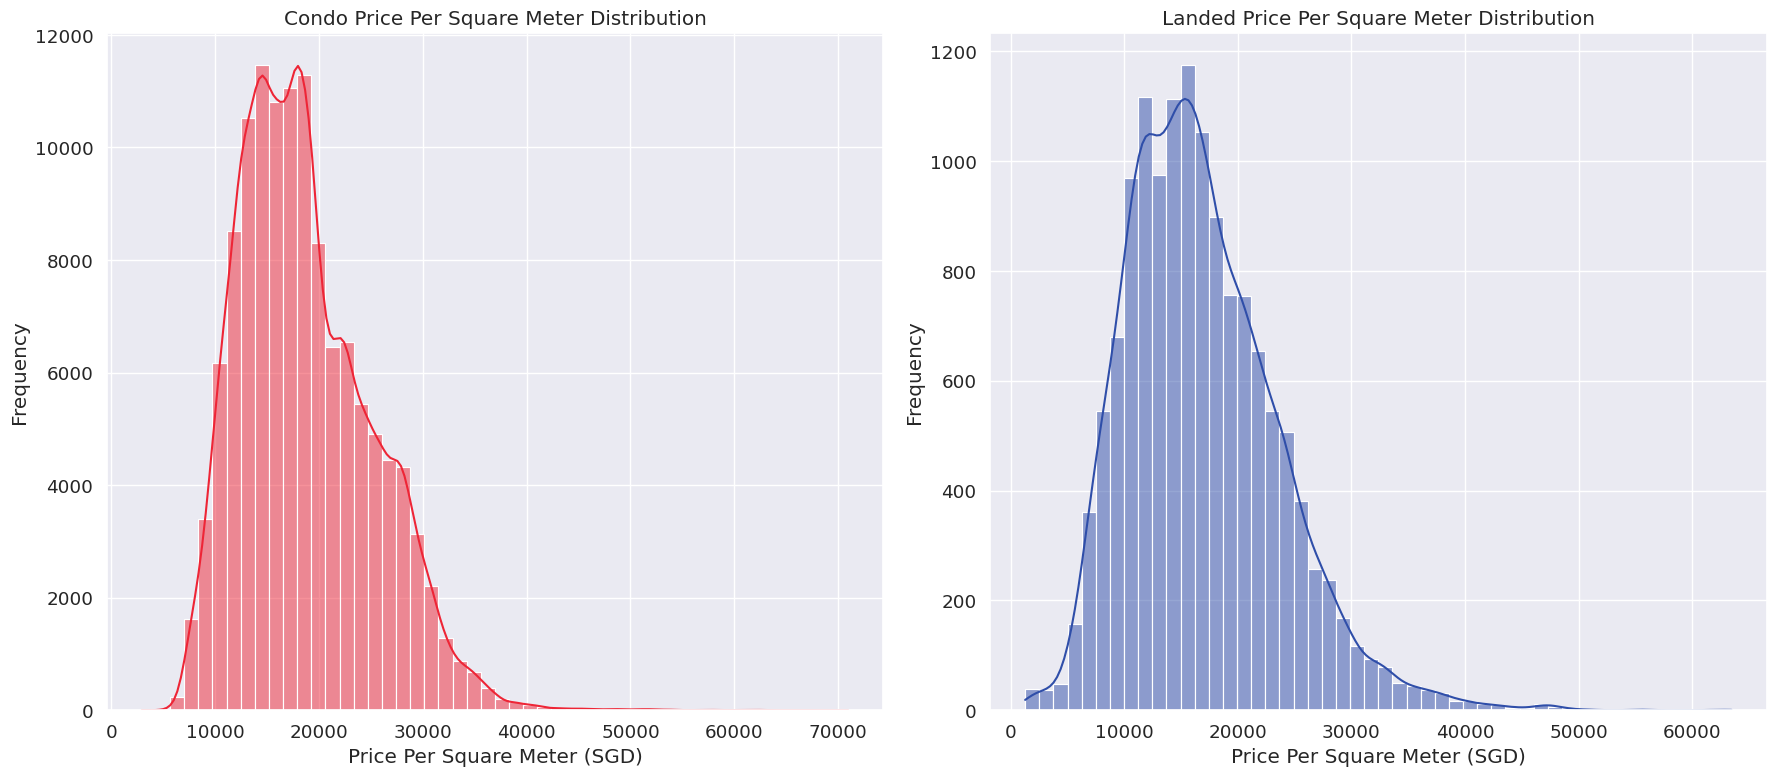

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.histplot(condo_data['price_psm'], kde=True, bins=50, ax=ax[0], color=sg_colors[0])
ax[0].set_title('Condo Price Per Square Meter Distribution')
ax[0].set_xlabel('Price Per Square Meter (SGD)')
ax[0].set_ylabel('Frequency')
ax[0].ticklabel_format(style='plain', axis='x')

sns.histplot(landed_data['price_psm'], kde=True, bins=50, ax=ax[1], color=sg_colors[2])
ax[1].set_title('Landed Price Per Square Meter Distribution')
ax[1].set_xlabel('Price Per Square Meter (SGD)')
ax[1].set_ylabel('Frequency')
ax[1].ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()

##PRice comparison by region

<ipython-input-37-9e8892fadcfd>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region', y='price_psm', data=condo_data, ax=ax[0], palette=sg_palette)
<ipython-input-37-9e8892fadcfd>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region', y='price_psm', data=landed_data, ax=ax[1], palette=sg_palette)


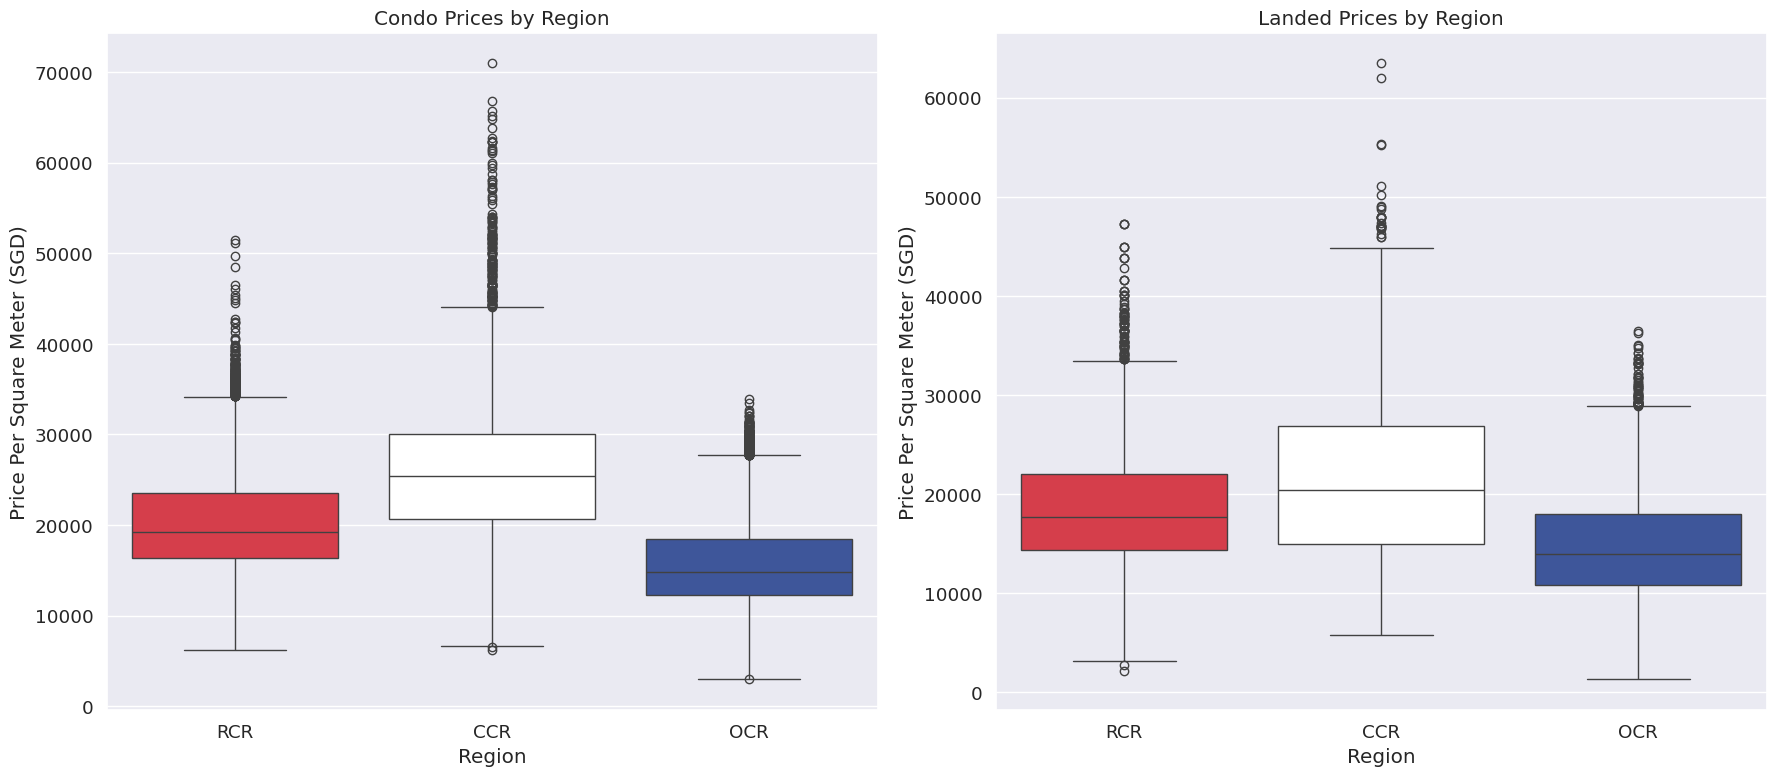

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.boxplot(x='region', y='price_psm', data=condo_data, ax=ax[0], palette=sg_palette)
ax[0].set_title('Condo Prices by Region')
ax[0].set_xlabel('Region')
ax[0].set_ylabel('Price Per Square Meter (SGD)')
ax[0].ticklabel_format(style='plain', axis='y')

sns.boxplot(x='region', y='price_psm', data=landed_data, ax=ax[1], palette=sg_palette)
ax[1].set_title('Landed Prices by Region')
ax[1].set_xlabel('Region')
ax[1].set_ylabel('Price Per Square Meter (SGD)')
ax[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

#Price trend over time

In [ ]:
condo_time_agg = condo_data.groupby(['transaction_year', 'transaction_quarter'])['price_psm'].median().reset_index()
condo_time_agg['year_quarter'] = condo_time_agg['transaction_year'].astype(str) + '-Q' + condo_time_agg['transaction_quarter'].astype(str)

landed_time_agg = landed_data.groupby(['transaction_year', 'transaction_quarter'])['price_psm'].median().reset_index()
landed_time_agg['year_quarter'] = landed_time_agg['transaction_year'].astype(str) + '-Q' + landed_time_agg['transaction_quarter'].astype(str)

condo_time_agg['sort_key'] = condo_time_agg['transaction_year'] * 10 + condo_time_agg['transaction_quarter']
landed_time_agg['sort_key'] = landed_time_agg['transaction_year'] * 10 + landed_time_agg['transaction_quarter']

condo_time_agg = condo_time_agg.sort_values('sort_key')
landed_time_agg = landed_time_agg.sort_values('sort_key')

fig, ax = plt.subplots(figsize=(14, 8))

plt.plot(condo_time_agg['year_quarter'], condo_time_agg['price_psm'], marker='o', linewidth=2, label='Condo', color=sg_colors[0])
plt.plot(landed_time_agg['year_quarter'], landed_time_agg['price_psm'], marker='s', linewidth=2, label='Landed', color=sg_colors[2])

plt.title('Median Price Per Square Meter Over Time')
plt.xlabel('Year-Quarter')
plt.ylabel('Median Price Per Square Meter (SGD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Transaction volume

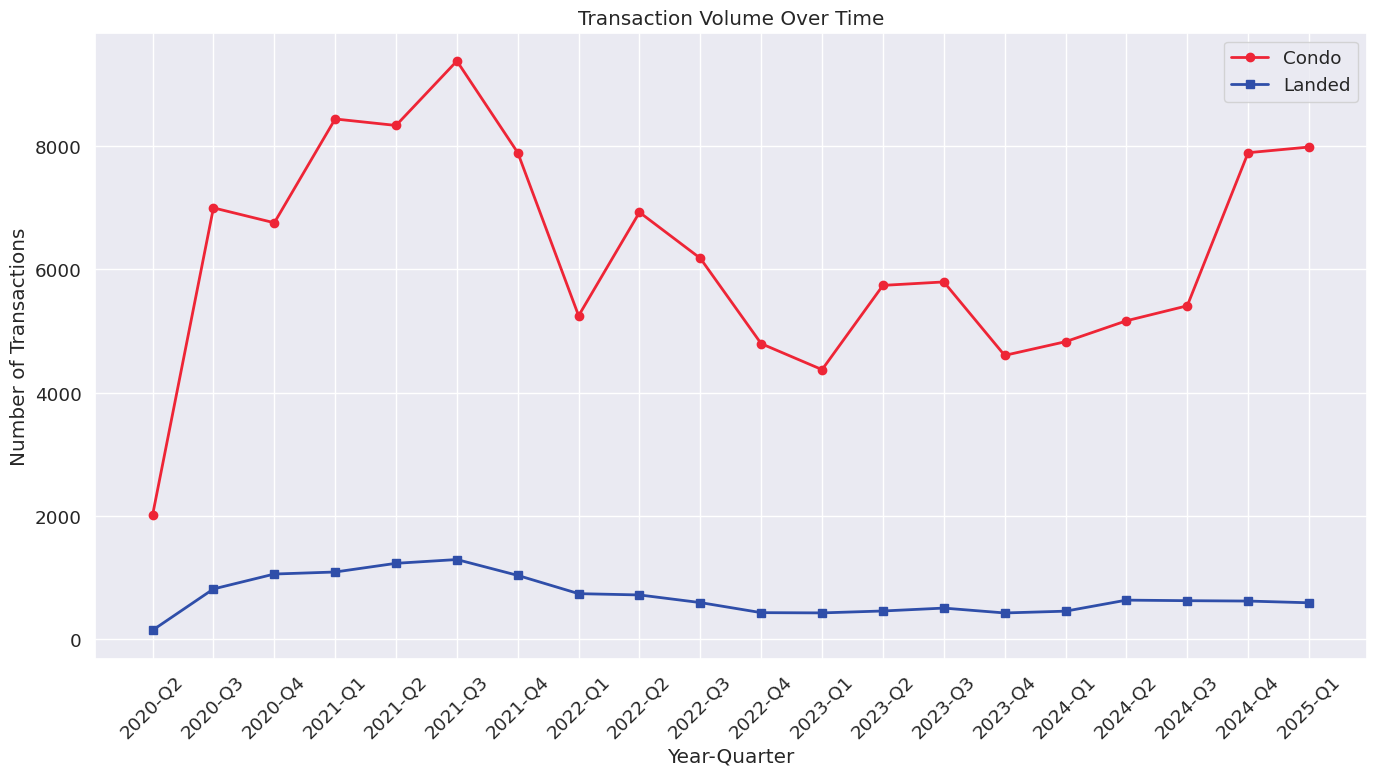

In [ ]:
condo_count = condo_data.groupby(['transaction_year', 'transaction_quarter']).size().reset_index(name='count')
condo_count['year_quarter'] = condo_count['transaction_year'].astype(str) + '-Q' + condo_count['transaction_quarter'].astype(str)
condo_count['sort_key'] = condo_count['transaction_year'] * 10 + condo_count['transaction_quarter']
condo_count = condo_count.sort_values('sort_key')

landed_count = landed_data.groupby(['transaction_year', 'transaction_quarter']).size().reset_index(name='count')
landed_count['year_quarter'] = landed_count['transaction_year'].astype(str) + '-Q' + landed_count['transaction_quarter'].astype(str)
landed_count['sort_key'] = landed_count['transaction_year'] * 10 + landed_count['transaction_quarter']
landed_count = landed_count.sort_values('sort_key')

fig, ax = plt.subplots(figsize=(14, 8))

plt.plot(condo_count['year_quarter'], condo_count['count'], marker='o', linewidth=2, label='Condo', color=sg_colors[0])
plt.plot(landed_count['year_quarter'], landed_count['count'], marker='s', linewidth=2, label='Landed', color=sg_colors[2])

plt.title('Transaction Volume Over Time')
plt.xlabel('Year-Quarter')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Property Size

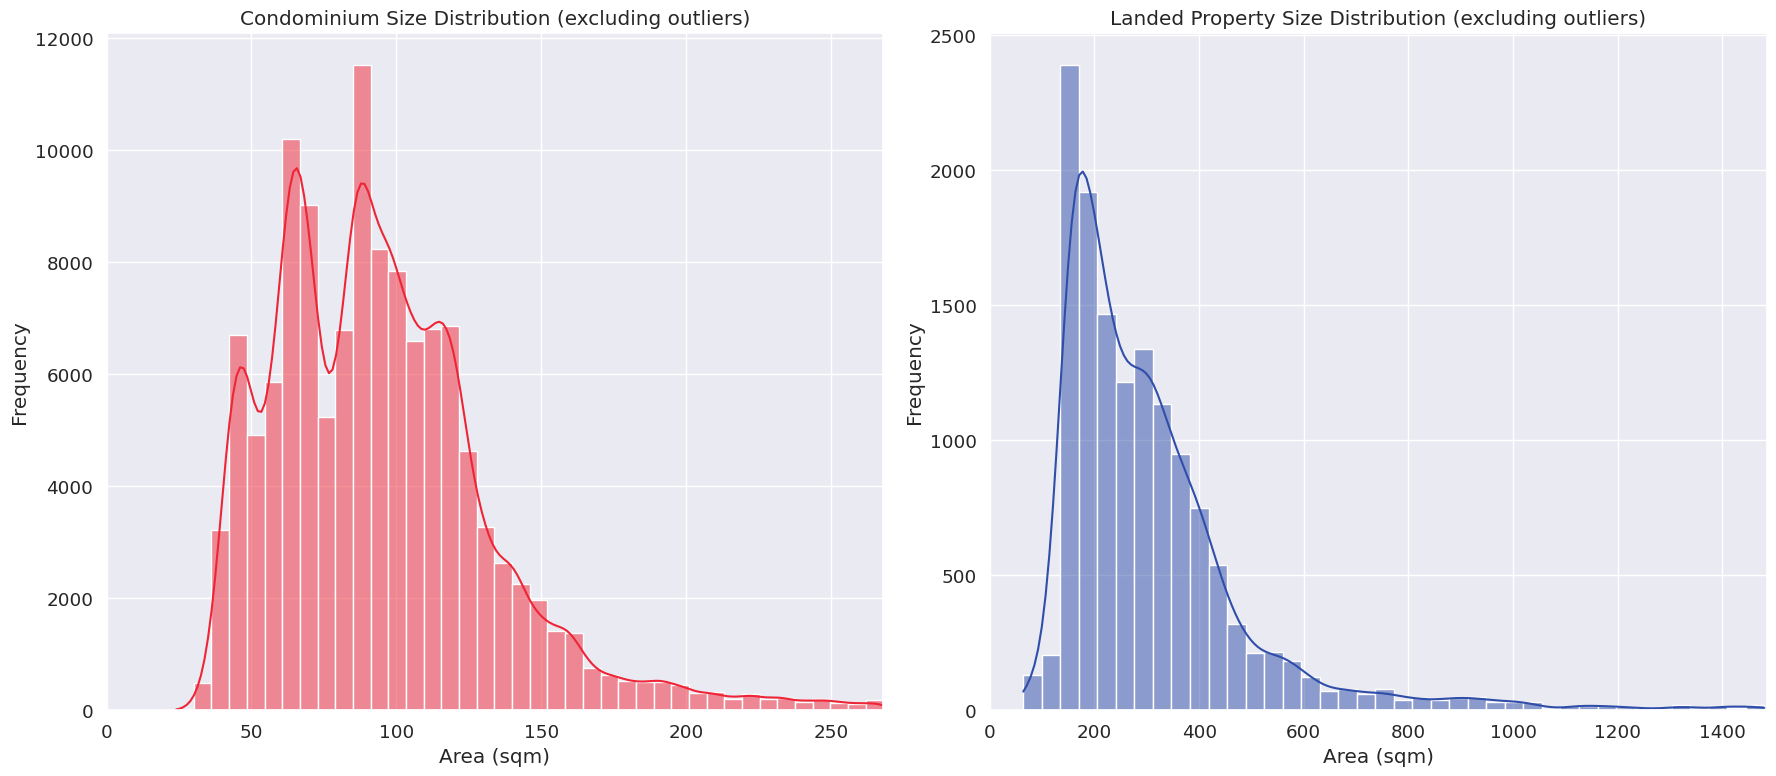

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

condo_upper_limit = np.percentile(condo_data['area_sqm'], 99)
landed_upper_limit = np.percentile(landed_data['area_sqm'], 99)

sns.histplot(condo_data[condo_data['area_sqm'] <= condo_upper_limit]['area_sqm'],
             kde=True, bins=40, ax=ax[0], color=sg_colors[0])
ax[0].set_title('Condominium Size Distribution (excluding outliers)')
ax[0].set_xlabel('Area (sqm)')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim(0, condo_upper_limit)

sns.histplot(landed_data[landed_data['area_sqm'] <= landed_upper_limit]['area_sqm'],
             kde=True, bins=40, ax=ax[1], color=sg_colors[2])
ax[1].set_title('Landed Property Size Distribution (excluding outliers)')
ax[1].set_xlabel('Area (sqm)')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim(0, landed_upper_limit)

plt.tight_layout()
plt.show()

SPecific size range

<ipython-input-66-ab533bf25bf3>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=condo_size_counts.index, y=condo_size_counts.values, ax=ax[0], palette='Reds')
<ipython-input-66-ab533bf25bf3>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
<ipython-input-66-ab533bf25bf3>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=landed_size_counts.index, y=landed_size_counts.values, ax=ax[1], palette='Blues')
<ipython-input-66-ab533bf25bf3>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or u

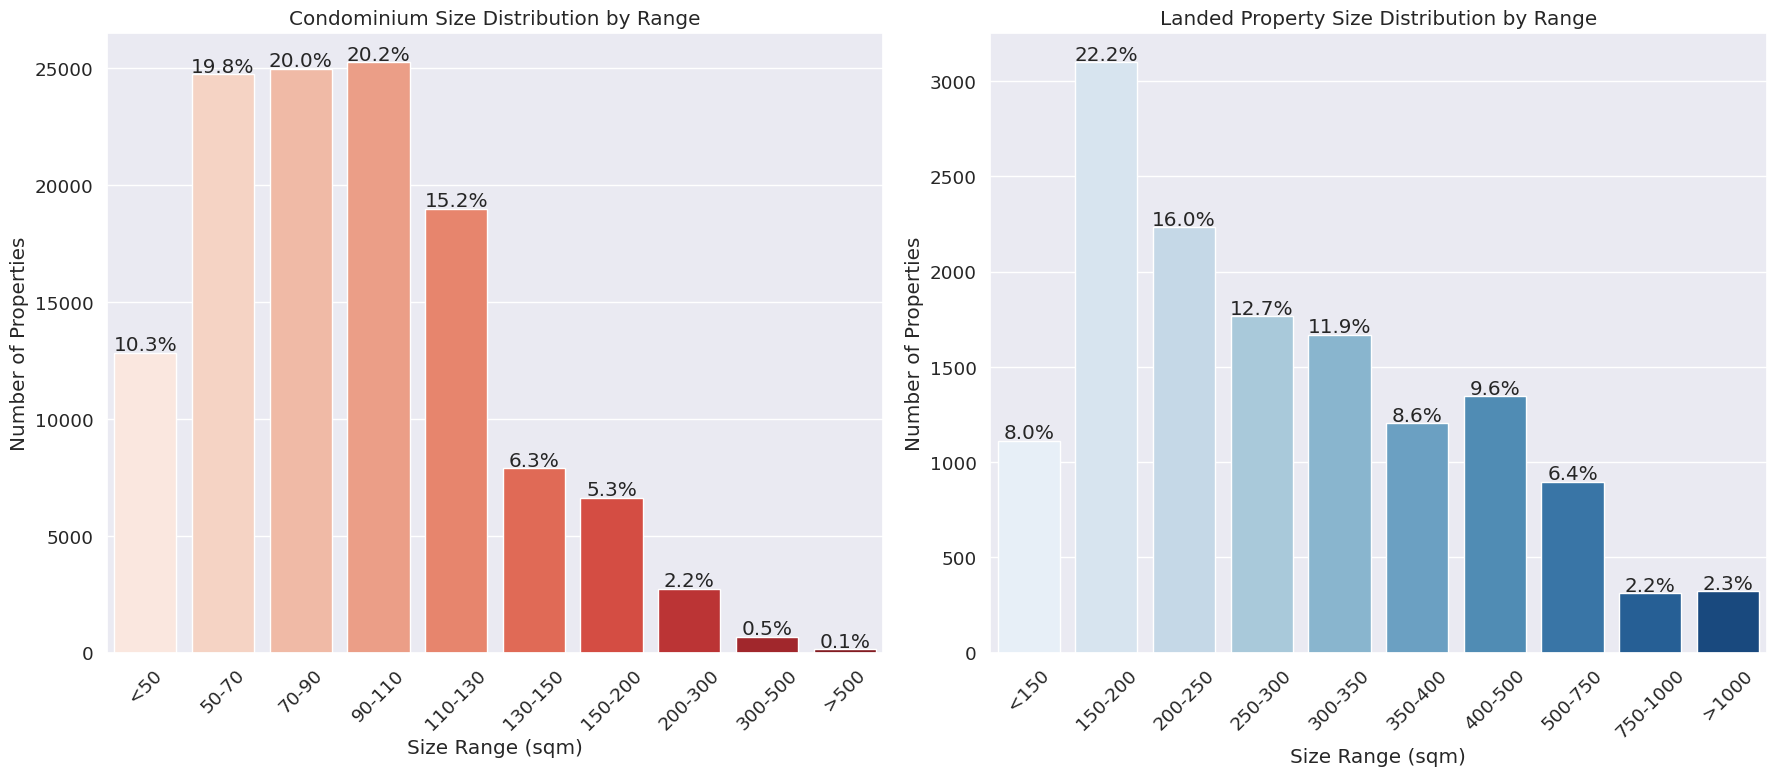

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

condo_bins = [0, 50, 70, 90, 110, 130, 150, 200, 300, 500, np.inf]
condo_labels = ['<50', '50-70', '70-90', '90-110', '110-130', '130-150', '150-200', '200-300', '300-500', '>500']
condo_size_cat = pd.cut(condo_data['area_sqm'], bins=condo_bins, labels=condo_labels)
condo_size_counts = condo_size_cat.value_counts().sort_index()

sns.barplot(x=condo_size_counts.index, y=condo_size_counts.values, ax=ax[0], palette='Reds')
ax[0].set_title('Condominium Size Distribution by Range')
ax[0].set_xlabel('Size Range (sqm)')
ax[0].set_ylabel('Number of Properties')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

total_condos = len(condo_data)
for i, v in enumerate(condo_size_counts):
    ax[0].text(i, v + 100, f"{v/total_condos*100:.1f}%", ha='center')

landed_bins = [0, 150, 200, 250, 300, 350, 400, 500, 750, 1000, np.inf]
landed_labels = ['<150', '150-200', '200-250', '250-300', '300-350', '350-400', '400-500', '500-750', '750-1000', '>1000']
landed_size_cat = pd.cut(landed_data['area_sqm'], bins=landed_bins, labels=landed_labels)
landed_size_counts = landed_size_cat.value_counts().sort_index()

sns.barplot(x=landed_size_counts.index, y=landed_size_counts.values, ax=ax[1], palette='Blues')
ax[1].set_title('Landed Property Size Distribution by Range')
ax[1].set_xlabel('Size Range (sqm)')
ax[1].set_ylabel('Number of Properties')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

total_landed = len(landed_data)
for i, v in enumerate(landed_size_counts):
    ax[1].text(i, v + 10, f"{v/total_landed*100:.1f}%", ha='center')

plt.tight_layout()
plt.show()

#size distributions across different property types and regions

<ipython-input-67-1688177fb061>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region', y='area_sqm', data=condo_data, ax=ax[0], palette=sns.color_palette("Reds"))
<ipython-input-67-1688177fb061>:5: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.boxplot(x='region', y='area_sqm', data=condo_data, ax=ax[0], palette=sns.color_palette("Reds"))
<ipython-input-67-1688177fb061>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region', y='area_sqm', data=landed_data, ax=ax[1], palette=sns.color_palette("Blues"))
<ipython-input-67-1688177fb061>:12: UserWarning: The palette list has more values (6) than needed (3), which may not be intend

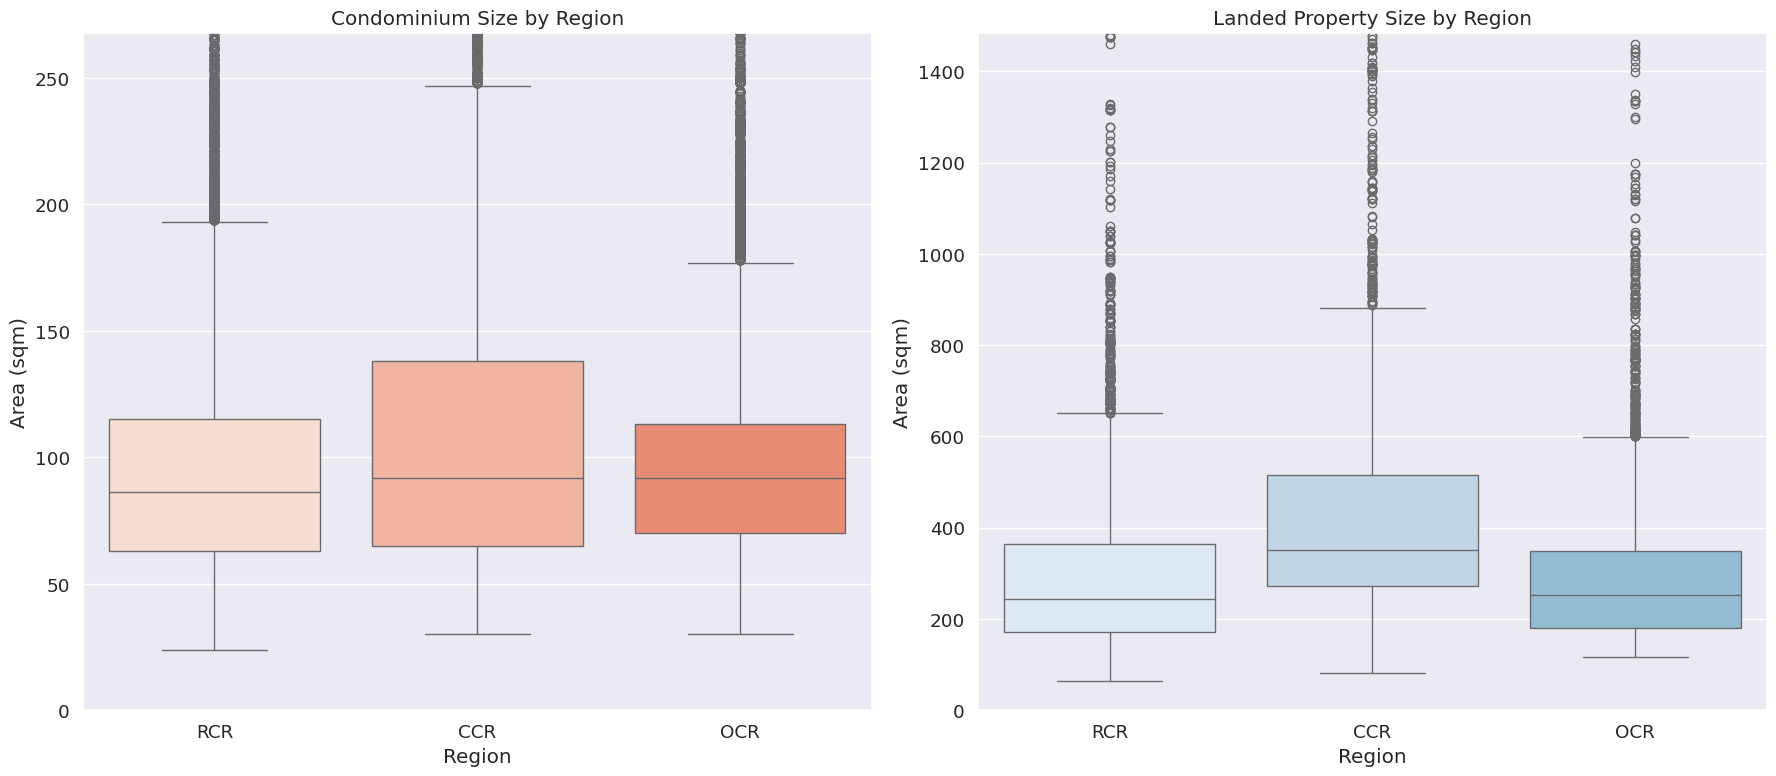

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.boxplot(x='region', y='area_sqm', data=condo_data, ax=ax[0], palette=sns.color_palette("Reds"))
ax[0].set_title('Condominium Size by Region')
ax[0].set_xlabel('Region')
ax[0].set_ylabel('Area (sqm)')
ax[0].set_ylim(0, condo_upper_limit)

sns.boxplot(x='region', y='area_sqm', data=landed_data, ax=ax[1], palette=sns.color_palette("Blues"))
ax[1].set_title('Landed Property Size by Region')
ax[1].set_xlabel('Region')
ax[1].set_ylabel('Area (sqm)')
ax[1].set_ylim(0, landed_upper_limit)

plt.tight_layout()
plt.show()

#Relationship between price and size

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

condo_sample = condo_data.sample(5000, random_state=42)
sns.scatterplot(x='area_sqm', y='price', hue='region', data=condo_sample, alpha=0.7, palette=sg_palette, ax=ax[0])
ax[0].set_title('Condominium: Price vs Size')
ax[0].set_xlabel('Area (sqm)')
ax[0].set_ylabel('Price (SGD)')
ax[0].ticklabel_format(style='plain', axis='y')

landed_sample = landed_data.sample(min(2000, len(landed_data)), random_state=42)
sns.scatterplot(x='area_sqm', y='price', hue='region', data=landed_sample, alpha=0.7, palette=sg_palette, ax=ax[1])
ax[1].set_title('Landed: Price vs Size')
ax[1].set_xlabel('Area (sqm)')
ax[1].set_ylabel('Price (SGD)')
ax[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

#regional distribution

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

condo_region_counts = condo_data['region'].value_counts()
landed_region_counts = landed_data['region'].value_counts()

ax[0].pie(condo_region_counts, labels=condo_region_counts.index, autopct='%1.1f%%',
          colors=[sg_colors[0], '#FF9999', '#FFCCCC'], startangle=90, shadow=False)
ax[0].set_title('Condominium Regional Distribution')

ax[1].pie(landed_region_counts, labels=landed_region_counts.index, autopct='%1.1f%%',
          colors=[sg_colors[2], '#9999FF', '#CCCCFF'], startangle=90, shadow=False)
ax[1].set_title('Landed Regional Distribution')

plt.tight_layout()
plt.show()

#prices by district

In [ ]:
top_condo_districts = condo_data.groupby('district')['price'].mean().nlargest(15).sort_values(ascending=True)
top_landed_districts = landed_data.groupby('district')['price'].mean().nlargest(15).sort_values(ascending=True)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.barplot(y=top_condo_districts.index.astype(str), x=top_condo_districts.values,
           color=sg_colors[0], ax=ax[0], orient='h')
ax[0].set_title('Top 15 Districts by Condo Mean Price')
ax[0].set_xlabel('Mean Price (SGD)')
ax[0].set_ylabel('District')
ax[0].ticklabel_format(style='plain', axis='x')

sns.barplot(y=top_landed_districts.index.astype(str), x=top_landed_districts.values,
           color=sg_colors[2], ax=ax[1], orient='h')
ax[1].set_title('Top 15 Districts by Landed Mean Price')
ax[1].set_xlabel('Mean Price (SGD)')
ax[1].set_ylabel('District')
ax[1].ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()

#specific property types

In [ ]:
if 'avg_floor' not in condo_data.columns and 'floor_range' in condo_data.columns:
    def extract_avg_floor(floor_range):
        try:
            if pd.isna(floor_range):
                return np.nan
            elif '-' in floor_range:
                parts = floor_range.split('-')
                lower = int(parts[0])
                upper = int(parts[1])
                return (lower + upper) / 2
            elif 'TO' in floor_range:
                parts = floor_range.split(' TO ')
                lower = int(parts[0])
                upper = int(parts[1])
                return (lower + upper) / 2
            else:
                return 1
        except:
            return np.nan

    condo_data['avg_floor'] = condo_data['floor_range'].apply(extract_avg_floor)

floor_price = condo_data.groupby(pd.cut(condo_data['avg_floor'],
                                        bins=[0, 5, 10, 15, 20, 25, 30, 50]))['price_psm'].mean().reset_index()
floor_price['avg_floor'] = floor_price['avg_floor'].astype(str)

plt.figure(figsize=(14, 8))
sns.barplot(x='avg_floor', y='price_psm', data=floor_price, color=sg_colors[0])
plt.title('Average Price per Square Meter by Floor Range (Condominiums)')
plt.xlabel('Floor Range')
plt.ylabel('Average Price Per Square Meter (SGD)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

<ipython-input-45-51dc6af14192>:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  floor_price = condo_data.groupby(pd.cut(condo_data['avg_floor'],


<ipython-input-46-08e5cb713f4d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=landed_type_price.index, y=landed_type_price.values, palette=sns.color_palette("Blues", len(landed_type_price)))


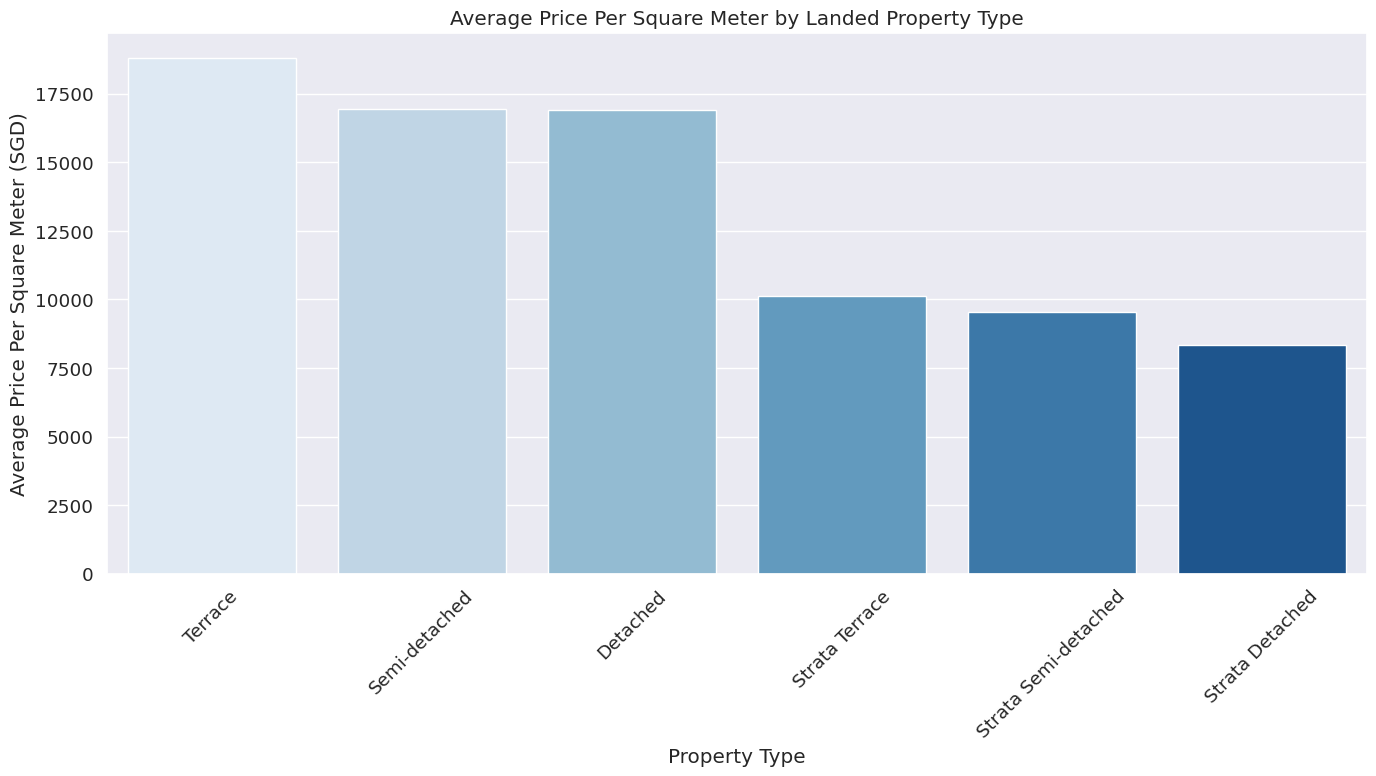

In [ ]:
if 'property_type' in landed_data.columns:
    landed_type_price = landed_data.groupby('property_type')['price_psm'].mean().sort_values(ascending=False)

    plt.figure(figsize=(14, 8))
    sns.barplot(x=landed_type_price.index, y=landed_type_price.values, palette=sns.color_palette("Blues", len(landed_type_price)))
    plt.title('Average Price Per Square Meter by Landed Property Type')
    plt.xlabel('Property Type')
    plt.ylabel('Average Price Per Square Meter (SGD)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

#Tenure Types

<ipython-input-48-47237e62342d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='tenure_type', y='price_psm', data=condo_data, ax=ax[0], palette=sns.color_palette("Reds", 3))
<ipython-input-48-47237e62342d>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='tenure_type', y='price_psm', data=landed_data, ax=ax[1], palette=sns.color_palette("Blues", 3))
<ipython-input-48-47237e62342d>:14: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(x='tenure_type', y='price_psm', data=landed_data, ax=ax[1], palette=sns.color_palette("Blues", 3))


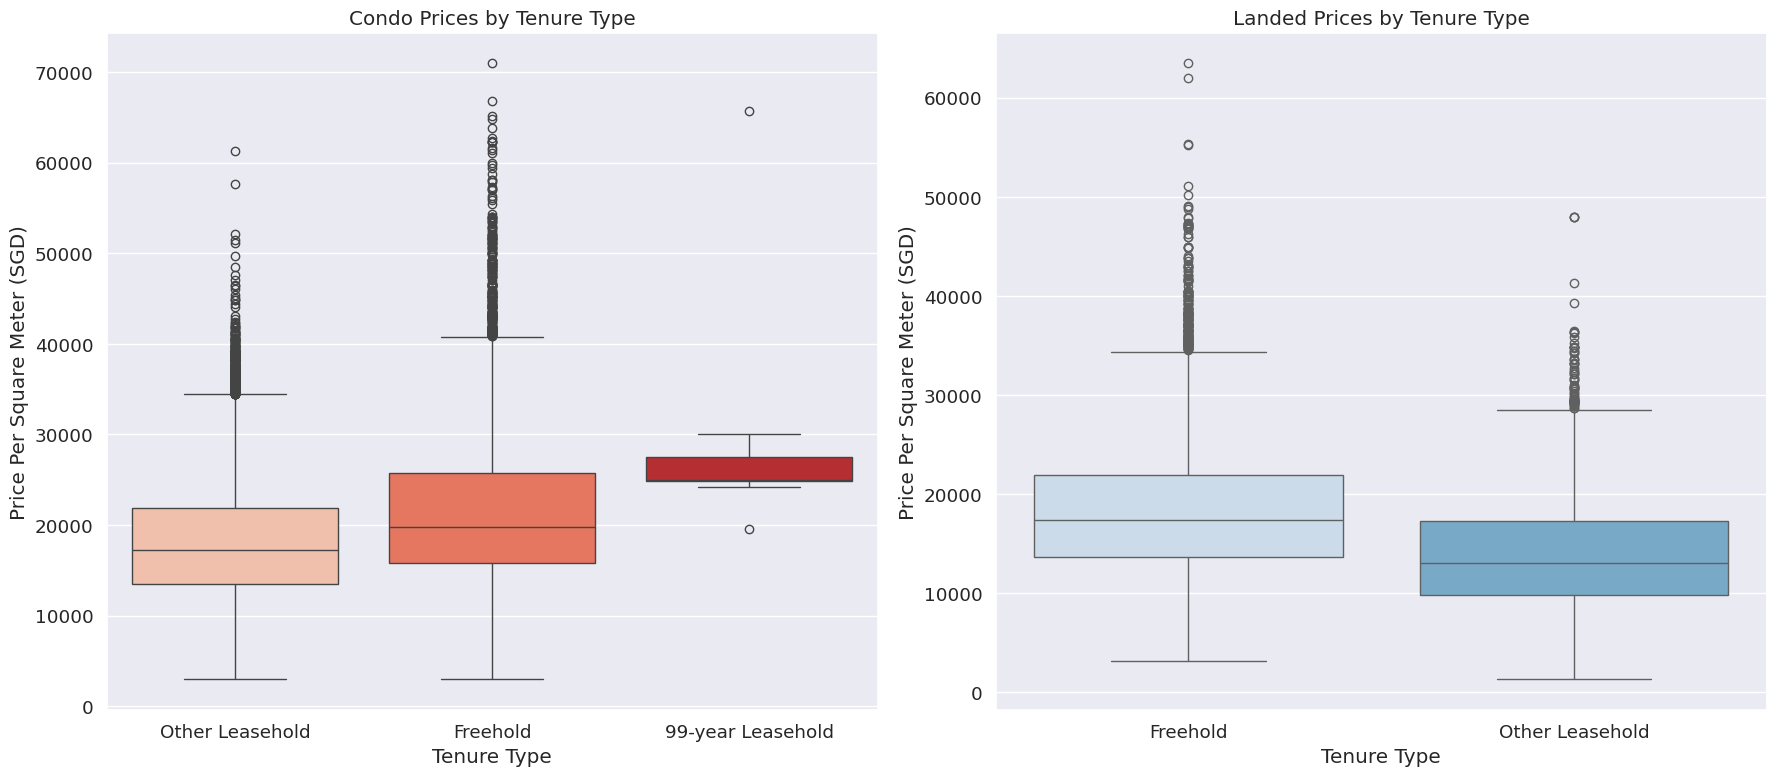

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

if 'tenure_type' in condo_data.columns:
    sns.boxplot(x='tenure_type', y='price_psm', data=condo_data, ax=ax[0], palette=sns.color_palette("Reds", 3))
    ax[0].set_title('Condo Prices by Tenure Type')
    ax[0].set_xlabel('Tenure Type')
    ax[0].set_ylabel('Price Per Square Meter (SGD)')
    ax[0].ticklabel_format(style='plain', axis='y')

if 'tenure_type' in landed_data.columns:
    sns.boxplot(x='tenure_type', y='price_psm', data=landed_data, ax=ax[1], palette=sns.color_palette("Blues", 3))
    ax[1].set_title('Landed Prices by Tenure Type')
    ax[1].set_xlabel('Tenure Type')
    ax[1].set_ylabel('Price Per Square Meter (SGD)')
    ax[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

#transaction types

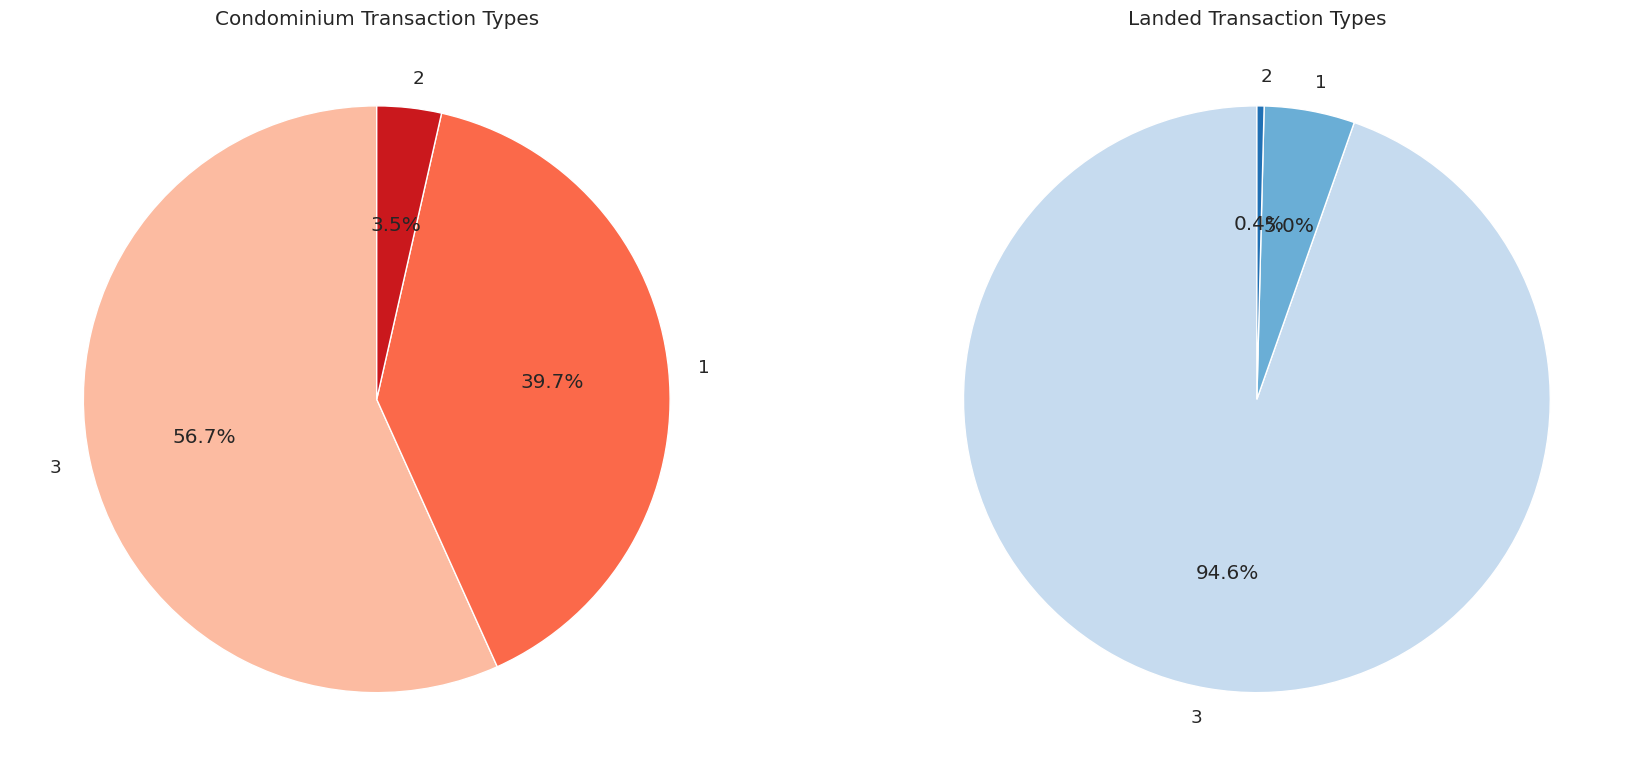

<ipython-input-49-34c2e47f61a9>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='type_of_sale', y='price_psm', data=condo_data, ax=ax[0], palette=sns.color_palette("Reds", 3))
<ipython-input-49-34c2e47f61a9>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='type_of_sale', y='price_psm', data=landed_data, ax=ax[1], palette=sns.color_palette("Blues", 3))


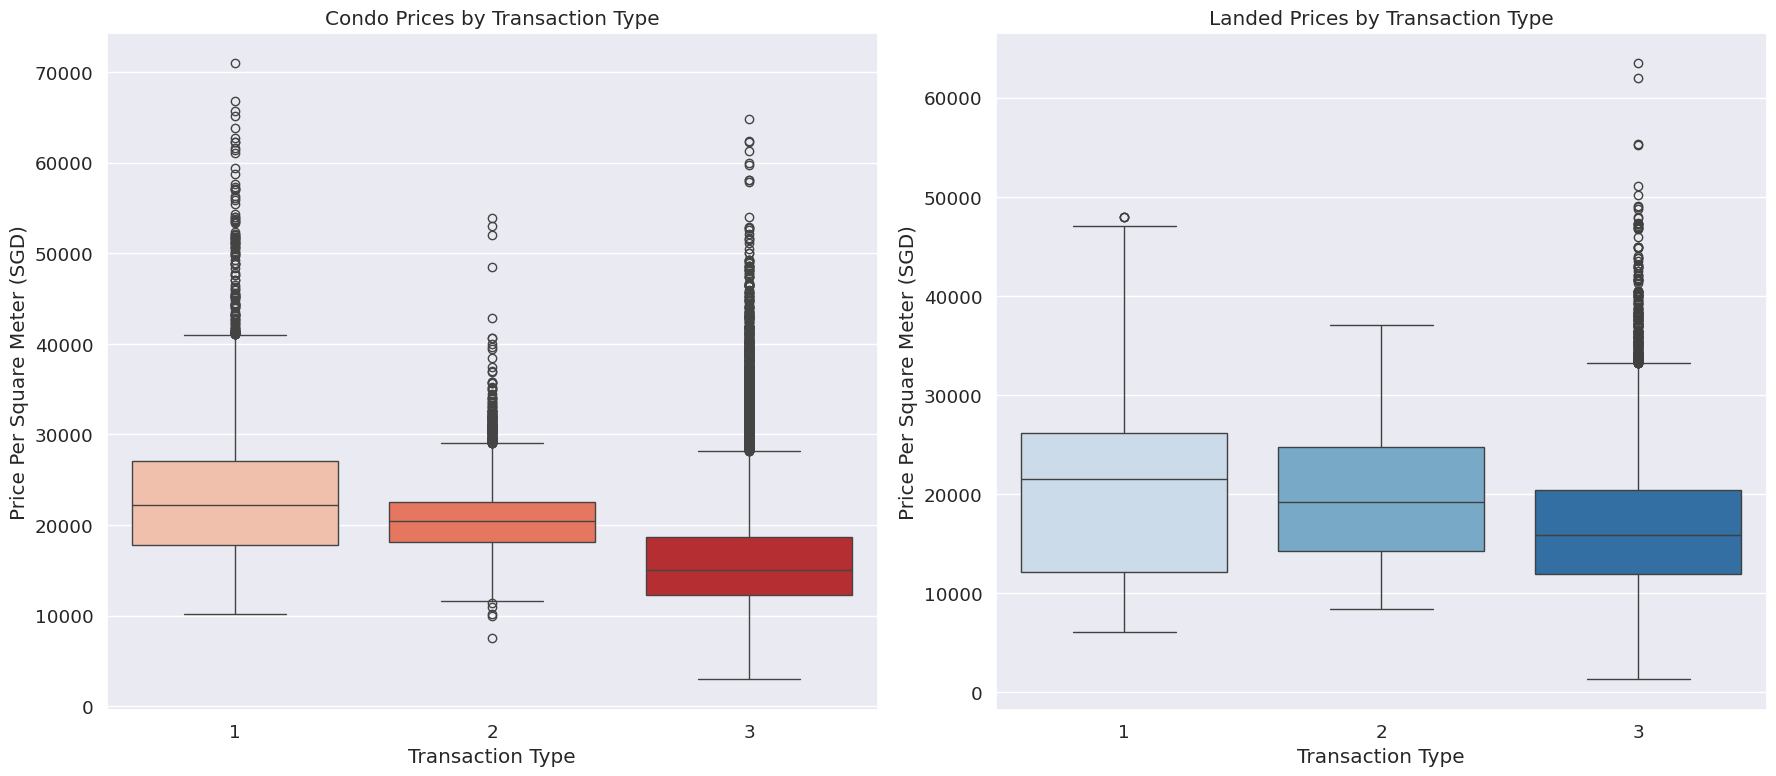

In [ ]:
if 'type_of_sale' in condo_data.columns and 'type_of_sale' in landed_data.columns:
    condo_trans_counts = condo_data['type_of_sale'].value_counts()
    landed_trans_counts = landed_data['type_of_sale'].value_counts()

    fig, ax = plt.subplots(1, 2, figsize=(18, 8))

    ax[0].pie(condo_trans_counts, labels=condo_trans_counts.index, autopct='%1.1f%%',
              colors=sns.color_palette("Reds", len(condo_trans_counts)), startangle=90)
    ax[0].set_title('Condominium Transaction Types')

    ax[1].pie(landed_trans_counts, labels=landed_trans_counts.index, autopct='%1.1f%%',
              colors=sns.color_palette("Blues", len(landed_trans_counts)), startangle=90)
    ax[1].set_title('Landed Transaction Types')

    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(18, 8))

    sns.boxplot(x='type_of_sale', y='price_psm', data=condo_data, ax=ax[0], palette=sns.color_palette("Reds", 3))
    ax[0].set_title('Condo Prices by Transaction Type')
    ax[0].set_xlabel('Transaction Type')
    ax[0].set_ylabel('Price Per Square Meter (SGD)')
    ax[0].ticklabel_format(style='plain', axis='y')

    sns.boxplot(x='type_of_sale', y='price_psm', data=landed_data, ax=ax[1], palette=sns.color_palette("Blues", 3))
    ax[1].set_title('Landed Prices by Transaction Type')
    ax[1].set_xlabel('Transaction Type')
    ax[1].set_ylabel('Price Per Square Meter (SGD)')
    ax[1].ticklabel_format(style='plain', axis='y')

    plt.tight_layout()
    plt.show()

#summary statistics

In [ ]:
condo_region_summary = condo_data.groupby('region').agg({
    'price': ['mean', 'median', 'min', 'max', 'count'],
    'price_psm': ['mean', 'median', 'min', 'max'],
    'area_sqm': ['mean', 'median', 'min', 'max']
})

landed_region_summary = landed_data.groupby('region').agg({
    'price': ['mean', 'median', 'min', 'max', 'count'],
    'price_psm': ['mean', 'median', 'min', 'max'],
    'area_sqm': ['mean', 'median', 'min', 'max']
})

print("Condominium Summary by Region:")
print(condo_region_summary)
print("\nLanded Summary by Region:")
print(landed_region_summary)

condo_year_summary = condo_data.groupby('transaction_year').agg({
    'price': ['mean', 'median', 'count'],
    'price_psm': ['mean', 'median'],
    'area_sqm': ['mean', 'median']
})

landed_year_summary = landed_data.groupby('transaction_year').agg({
    'price': ['mean', 'median', 'count'],
    'price_psm': ['mean', 'median'],
    'area_sqm': ['mean', 'median']
})

print("\nCondominium Summary by Year:")
print(condo_year_summary)
print("\nLanded Summary by Year:")
print(landed_year_summary)

Condominium Summary by Region:
               price                                          price_psm  \
                mean     median     min        max  count          mean   
region                                                                    
CCR     2.927487e+06  2252000.0  465000  550800000  18093  25627.257422   
OCR     1.460916e+06  1340000.0  340000  890000000  63378  15802.768269   
RCR     1.863874e+06  1638000.0  460000  392180000  43296  20029.924564   

                                                   area_sqm               \
              median          min           max        mean median   min   
region                                                                     
CCR     25438.596491  6198.347107  70963.503650  114.108390   92.0  30.0   
OCR     14855.555556  2949.898204  33953.846154   96.361252   92.0  30.0   
RCR     19210.526316  6252.873563  51488.095238   95.454677   86.5  24.0   

                 
            max  
region           
CCR    

#Regional price distribution

<ipython-input-51-4cf5e6fe29da>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='region', y='price_psm', data=condo_data, ax=ax[0], palette=sns.color_palette("Reds"))
<ipython-input-51-4cf5e6fe29da>:5: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.violinplot(x='region', y='price_psm', data=condo_data, ax=ax[0], palette=sns.color_palette("Reds"))
<ipython-input-51-4cf5e6fe29da>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='region', y='price_psm', data=landed_data, ax=ax[1], palette=sns.color_palette("Blues"))
<ipython-input-51-4cf5e6fe29da>:12: UserWarning: The palette list has more values (6) than needed (3), which may n

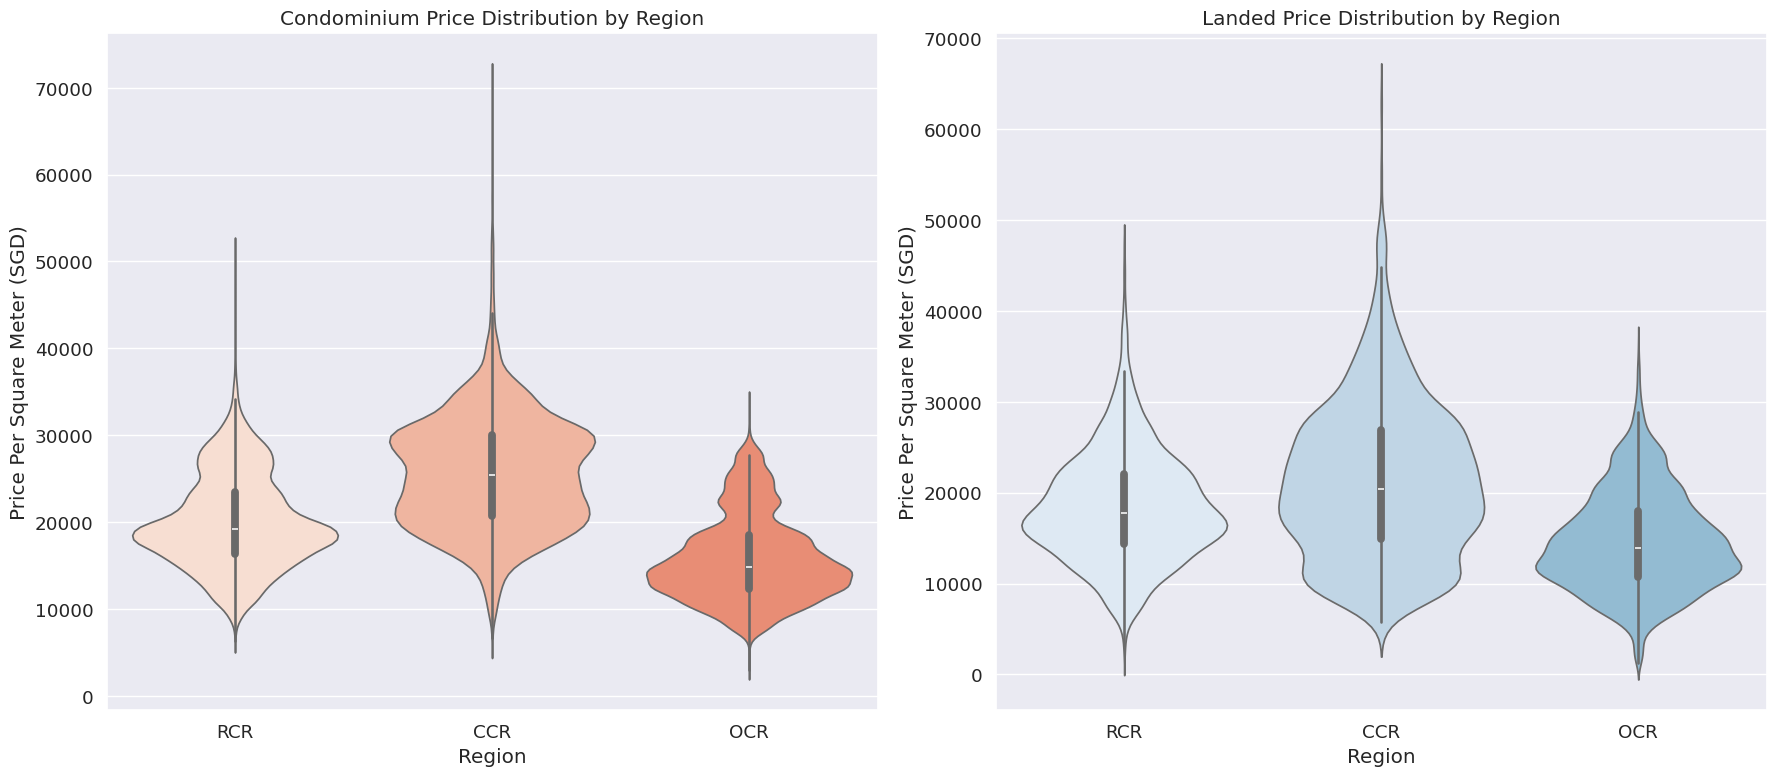

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.violinplot(x='region', y='price_psm', data=condo_data, ax=ax[0], palette=sns.color_palette("Reds"))
ax[0].set_title('Condominium Price Distribution by Region')
ax[0].set_xlabel('Region')
ax[0].set_ylabel('Price Per Square Meter (SGD)')
ax[0].ticklabel_format(style='plain', axis='y')

sns.violinplot(x='region', y='price_psm', data=landed_data, ax=ax[1], palette=sns.color_palette("Blues"))
ax[1].set_title('Landed Price Distribution by Region')
ax[1].set_xlabel('Region')
ax[1].set_ylabel('Price Per Square Meter (SGD)')
ax[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

#Size Distribution by Property Type

<ipython-input-52-c8ed9b2db513>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='property_type', y='area_sqm', data=condo_data, ax=ax[0], palette=sns.color_palette("Reds"))
<ipython-input-52-c8ed9b2db513>:6: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.boxplot(x='property_type', y='area_sqm', data=condo_data, ax=ax[0], palette=sns.color_palette("Reds"))
<ipython-input-52-c8ed9b2db513>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')
<ipython-input-52-c8ed9b2db513>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` 

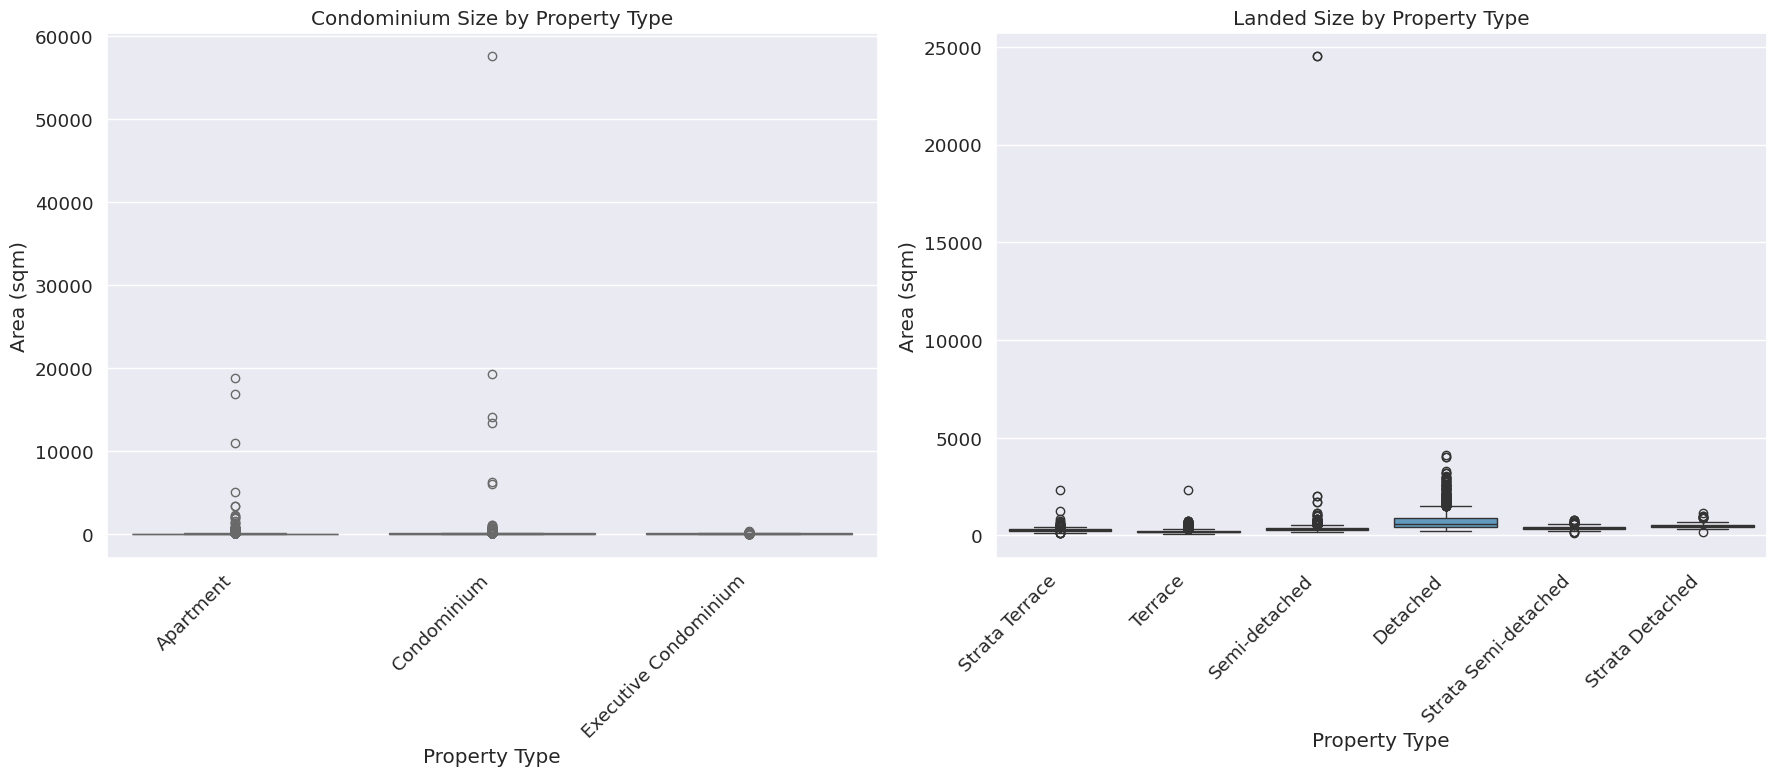

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

if 'property_type' in condo_data.columns:
    sns.boxplot(x='property_type', y='area_sqm', data=condo_data, ax=ax[0], palette=sns.color_palette("Reds"))
    ax[0].set_title('Condominium Size by Property Type')
    ax[0].set_xlabel('Property Type')
    ax[0].set_ylabel('Area (sqm)')
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')

if 'property_type' in landed_data.columns:
    sns.boxplot(x='property_type', y='area_sqm', data=landed_data, ax=ax[1], palette=sns.color_palette("Blues"))
    ax[1].set_title('Landed Size by Property Type')
    ax[1].set_xlabel('Property Type')
    ax[1].set_ylabel('Area (sqm)')
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

#Transaction Year Analysis

<ipython-input-53-7ca3a4aad7c7>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='transaction_year', y='price_psm', data=condo_data, ax=ax[0], palette=sns.color_palette("Reds"))
<ipython-input-53-7ca3a4aad7c7>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='transaction_year', y='price_psm', data=landed_data, ax=ax[1], palette=sns.color_palette("Blues"))


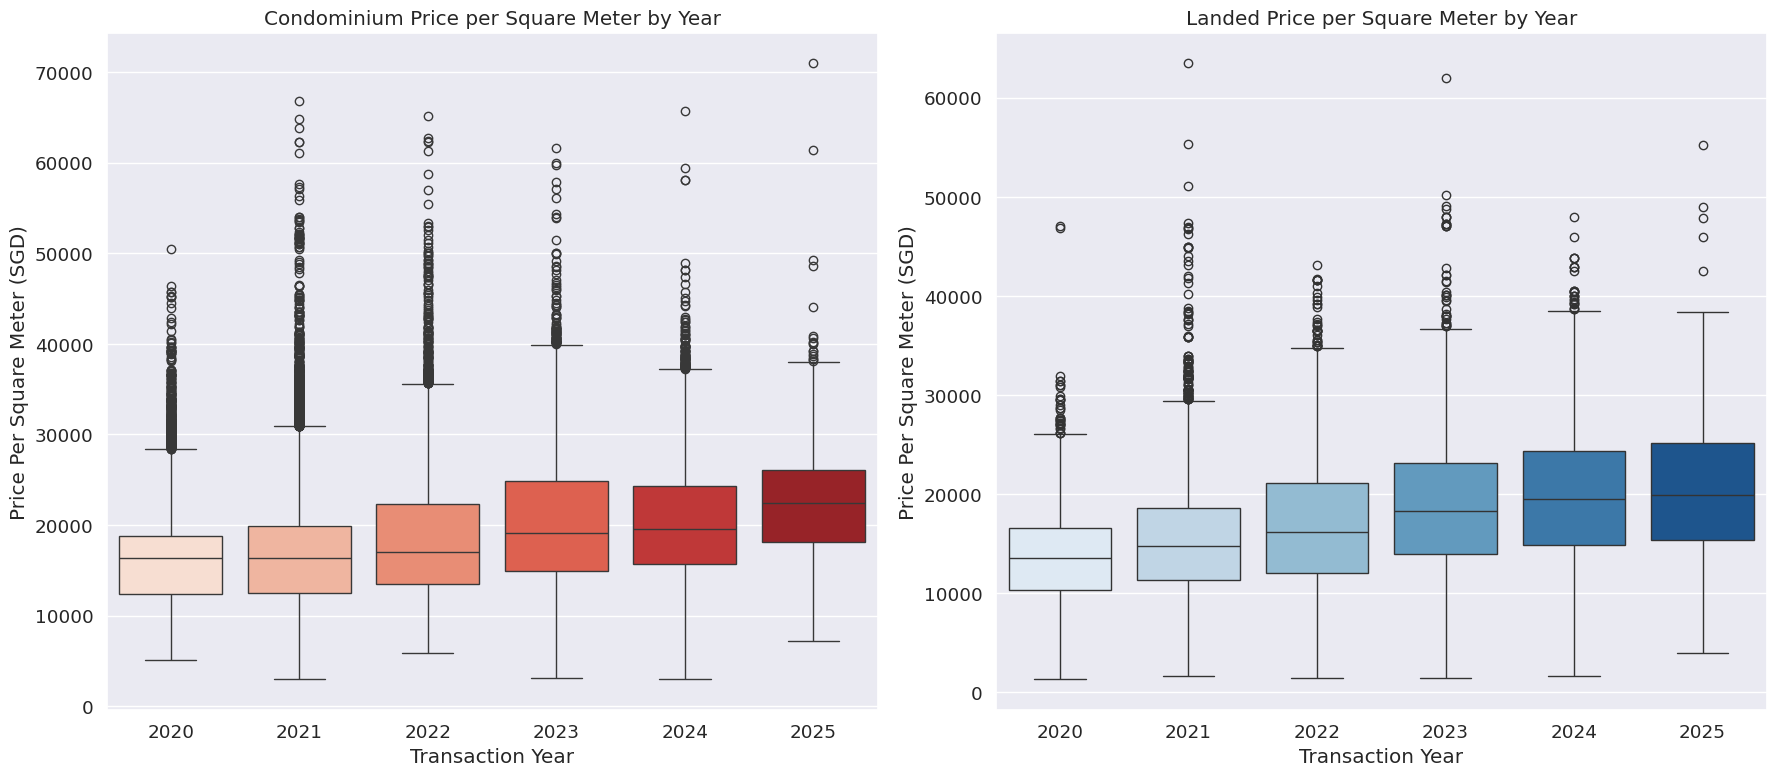

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.boxplot(x='transaction_year', y='price_psm', data=condo_data, ax=ax[0], palette=sns.color_palette("Reds"))
ax[0].set_title('Condominium Price per Square Meter by Year')
ax[0].set_xlabel('Transaction Year')
ax[0].set_ylabel('Price Per Square Meter (SGD)')
ax[0].ticklabel_format(style='plain', axis='y')

sns.boxplot(x='transaction_year', y='price_psm', data=landed_data, ax=ax[1], palette=sns.color_palette("Blues"))
ax[1].set_title('Landed Price per Square Meter by Year')
ax[1].set_xlabel('Transaction Year')
ax[1].set_ylabel('Price Per Square Meter (SGD)')
ax[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

#Regional Price Trends Over Time

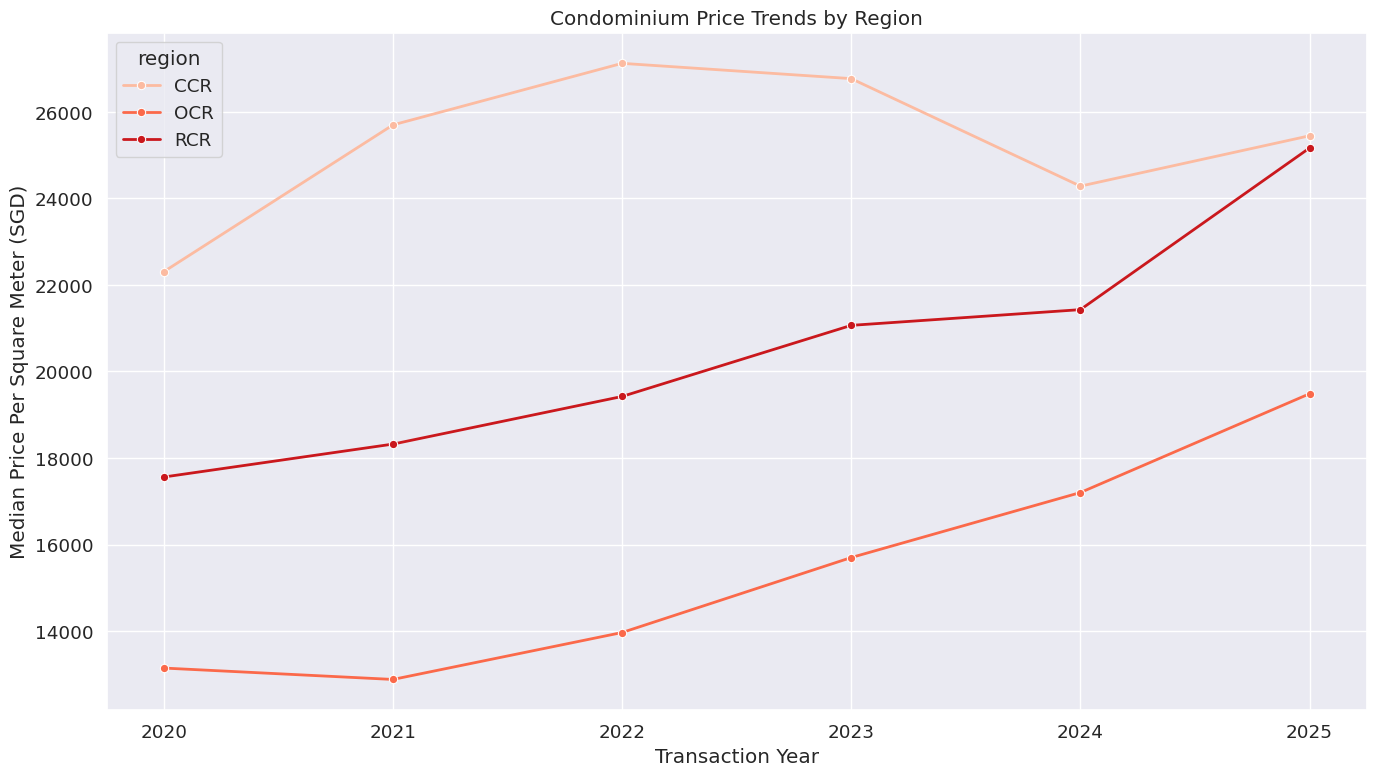

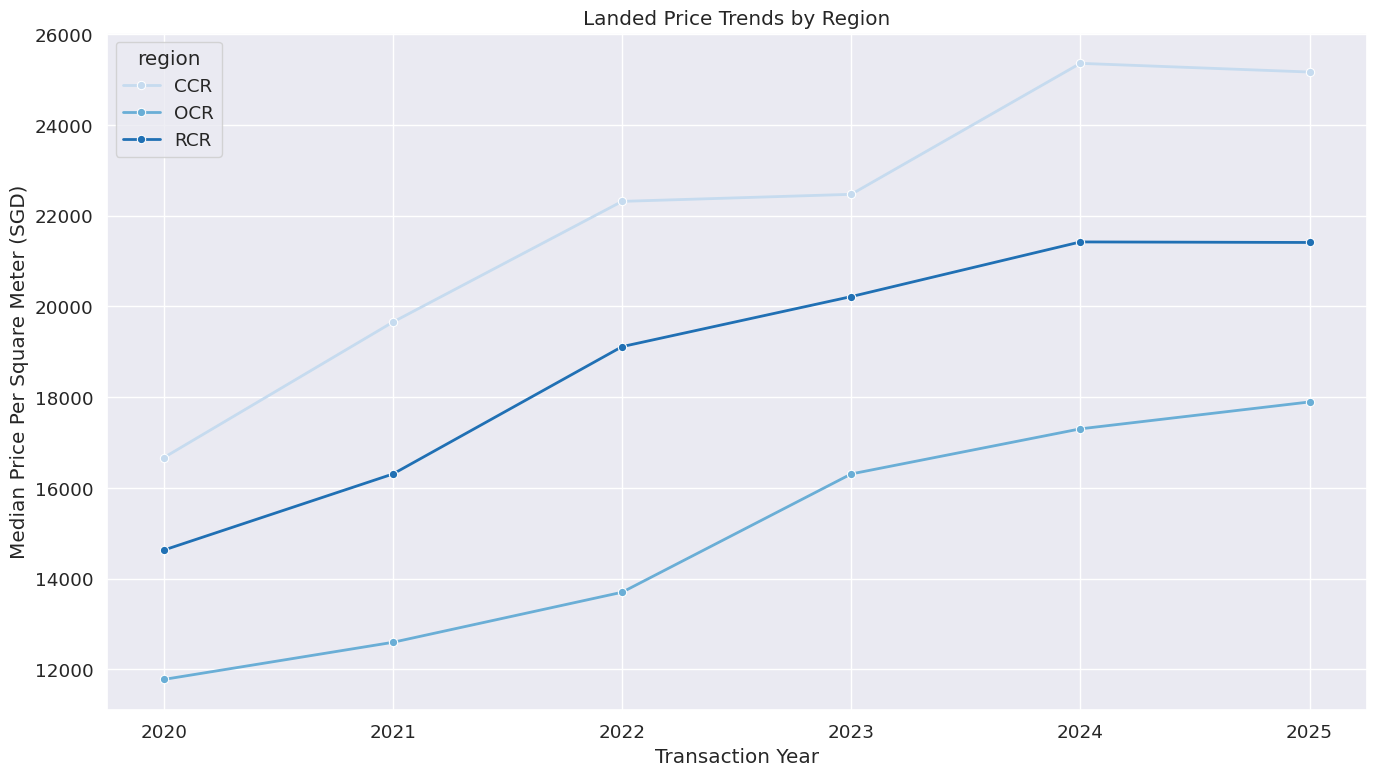

In [ ]:
condo_region_time = condo_data.groupby(['region', 'transaction_year'])['price_psm'].median().reset_index()

plt.figure(figsize=(14, 8))
sns.lineplot(x='transaction_year', y='price_psm', hue='region', data=condo_region_time,
             palette=sns.color_palette("Reds", 3), marker='o', linewidth=2)
plt.title('Condominium Price Trends by Region')
plt.xlabel('Transaction Year')
plt.ylabel('Median Price Per Square Meter (SGD)')
plt.grid(True)
plt.tight_layout()
plt.show()

landed_region_time = landed_data.groupby(['region', 'transaction_year'])['price_psm'].median().reset_index()

plt.figure(figsize=(14, 8))
sns.lineplot(x='transaction_year', y='price_psm', hue='region', data=landed_region_time,
             palette=sns.color_palette("Blues", 3), marker='o', linewidth=2)
plt.title('Landed Price Trends by Region')
plt.xlabel('Transaction Year')
plt.ylabel('Median Price Per Square Meter (SGD)')
plt.grid(True)
plt.tight_layout()
plt.show()

Property Size Categories Analysis

<ipython-input-55-da65bc8ccdec>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  condo_size_cat = condo_data.groupby('size_category')['price_psm'].mean().reset_index()
<ipython-input-55-da65bc8ccdec>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='size_category', y='price_psm', data=condo_size_cat, ax=ax[0], palette=sns.color_palette("Reds"))
<ipython-input-55-da65bc8ccdec>:7: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(x='size_category', y='price_psm', data=condo_size_cat, ax=ax[0], palette=sns.color_palette("Reds"))
<ipython-input-55-da65bc8ccdec>:11: UserWarning: set_ticklabels()

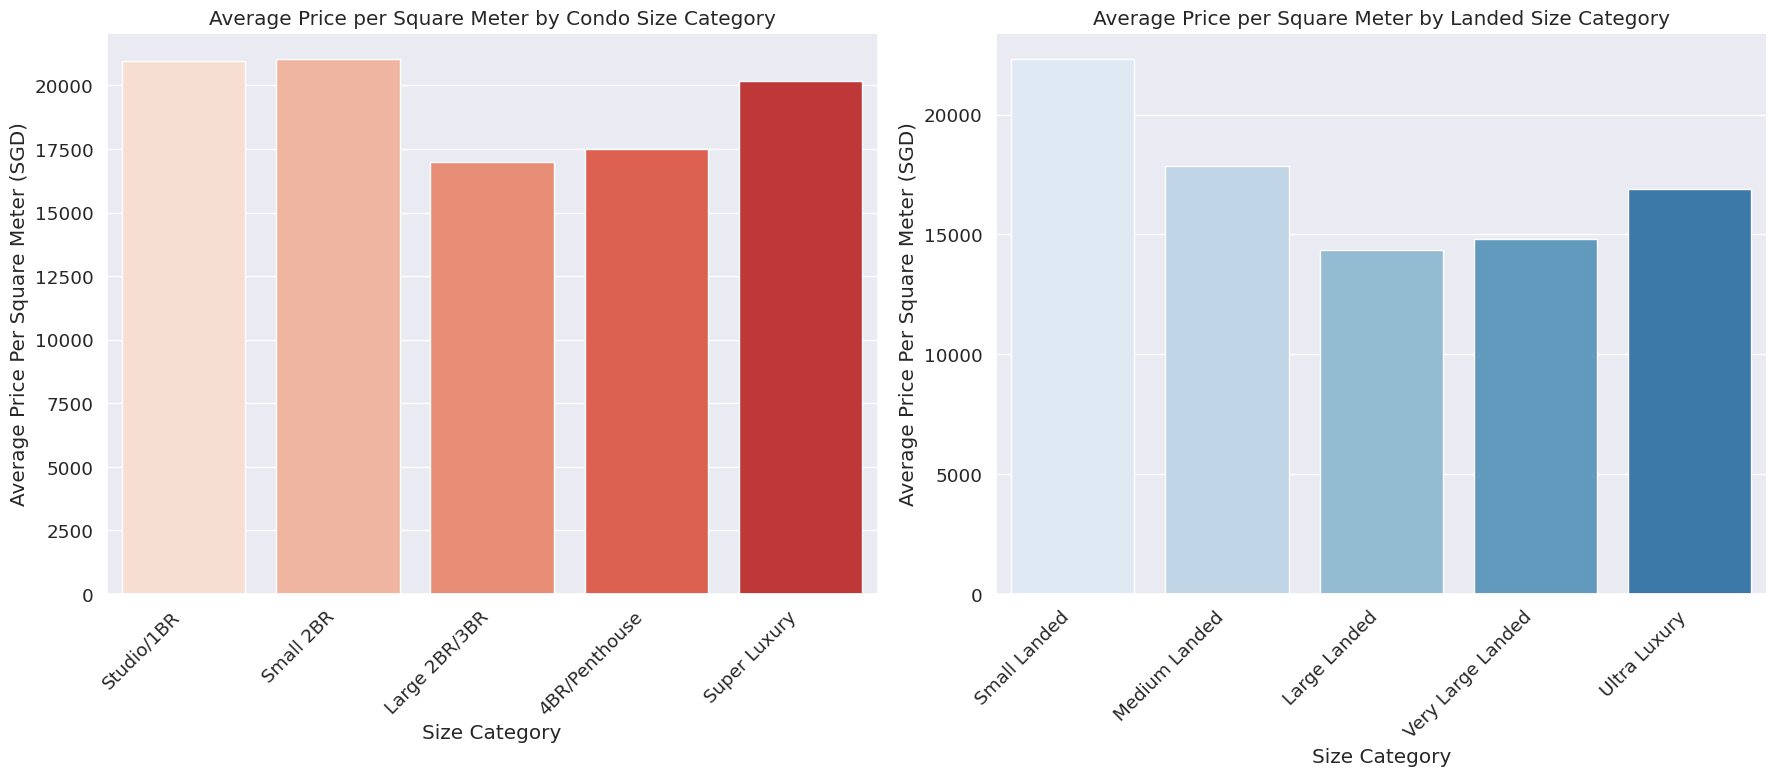

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

if 'size_category' in condo_data.columns:
    condo_size_cat = condo_data.groupby('size_category')['price_psm'].mean().reset_index()
    sns.barplot(x='size_category', y='price_psm', data=condo_size_cat, ax=ax[0], palette=sns.color_palette("Reds"))
    ax[0].set_title('Average Price per Square Meter by Condo Size Category')
    ax[0].set_xlabel('Size Category')
    ax[0].set_ylabel('Average Price Per Square Meter (SGD)')
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')

if 'size_category' in landed_data.columns:
    landed_size_cat = landed_data.groupby('size_category')['price_psm'].mean().reset_index()
    sns.barplot(x='size_category', y='price_psm', data=landed_size_cat, ax=ax[1], palette=sns.color_palette("Blues"))
    ax[1].set_title('Average Price per Square Meter by Landed Size Category')
    ax[1].set_xlabel('Size Category')
    ax[1].set_ylabel('Average Price Per Square Meter (SGD)')
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

Price Tier Analysis

<ipython-input-56-d7cb89084fac>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=condo_tier_counts.index, y=condo_tier_counts.values, ax=ax[0], palette=sns.color_palette("Reds"))
<ipython-input-56-d7cb89084fac>:7: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(x=condo_tier_counts.index, y=condo_tier_counts.values, ax=ax[0], palette=sns.color_palette("Reds"))
<ipython-input-56-d7cb89084fac>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=landed_tier_counts.index, y=landed_tier_counts.values, ax=ax[1], palette=sns.color_palette("Blues"))
<ipython-input-56-d7cb89084fac>:20: UserWarning: The palette list has more values (6) tha

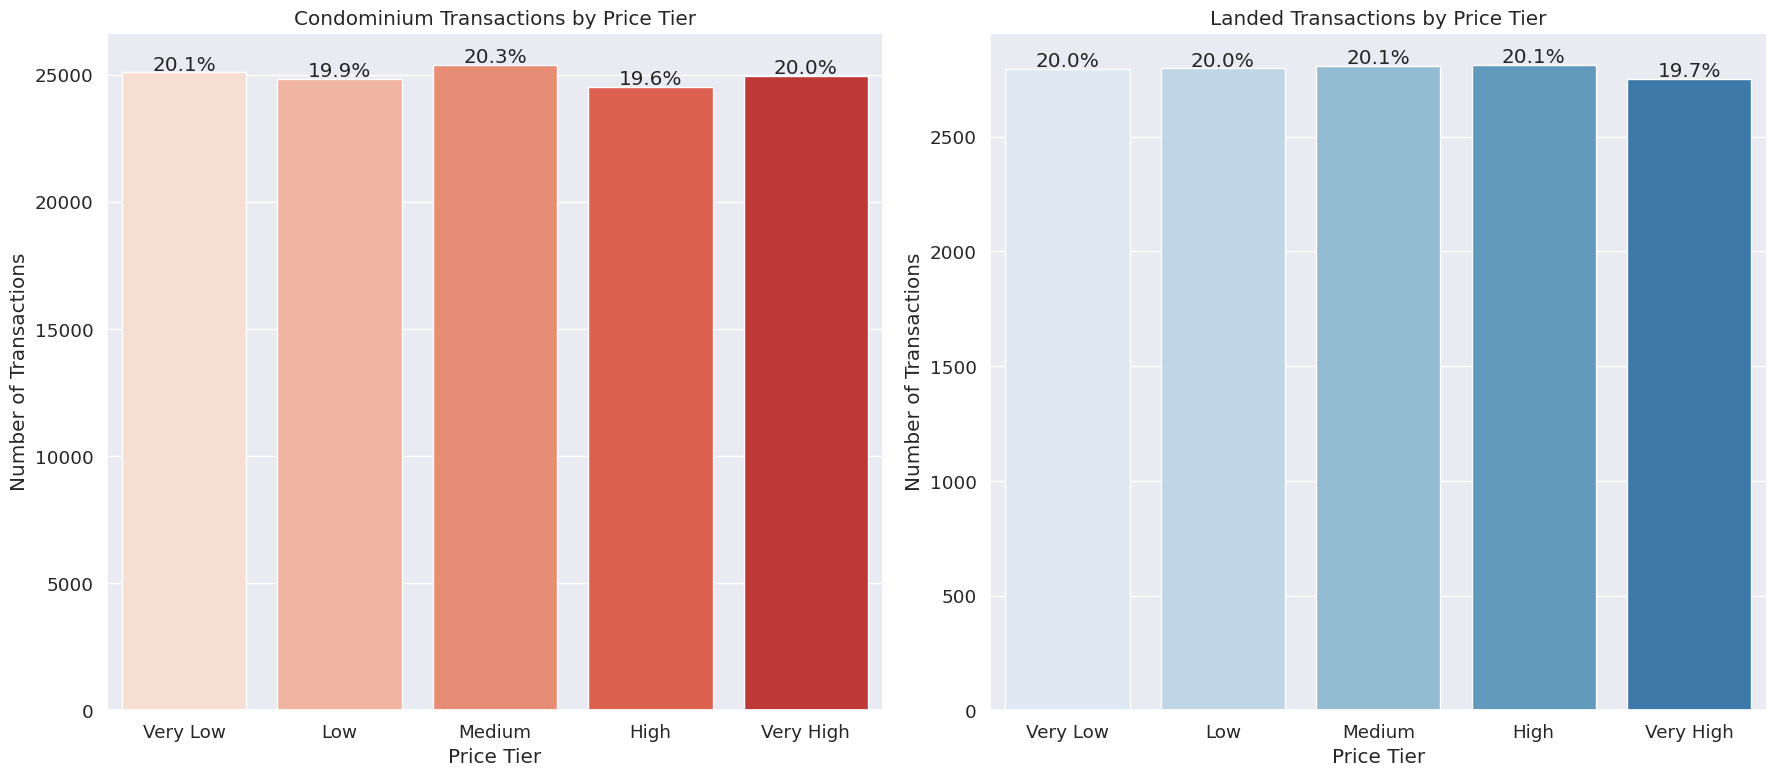

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

if 'price_tier' in condo_data.columns:
    condo_tier_counts = condo_data['price_tier'].value_counts().sort_index()
    sns.barplot(x=condo_tier_counts.index, y=condo_tier_counts.values, ax=ax[0], palette=sns.color_palette("Reds"))
    ax[0].set_title('Condominium Transactions by Price Tier')
    ax[0].set_xlabel('Price Tier')
    ax[0].set_ylabel('Number of Transactions')

    total = sum(condo_tier_counts)
    for i, v in enumerate(condo_tier_counts):
        ax[0].text(i, v + 100, f"{v/total*100:.1f}%", ha='center')

if 'price_tier' in landed_data.columns:
    landed_tier_counts = landed_data['price_tier'].value_counts().sort_index()
    sns.barplot(x=landed_tier_counts.index, y=landed_tier_counts.values, ax=ax[1], palette=sns.color_palette("Blues"))
    ax[1].set_title('Landed Transactions by Price Tier')
    ax[1].set_xlabel('Price Tier')
    ax[1].set_ylabel('Number of Transactions')

    total = sum(landed_tier_counts)
    for i, v in enumerate(landed_tier_counts):
        ax[1].text(i, v + 10, f"{v/total*100:.1f}%", ha='center')

plt.tight_layout()
plt.show()

#Correlation Heatmap

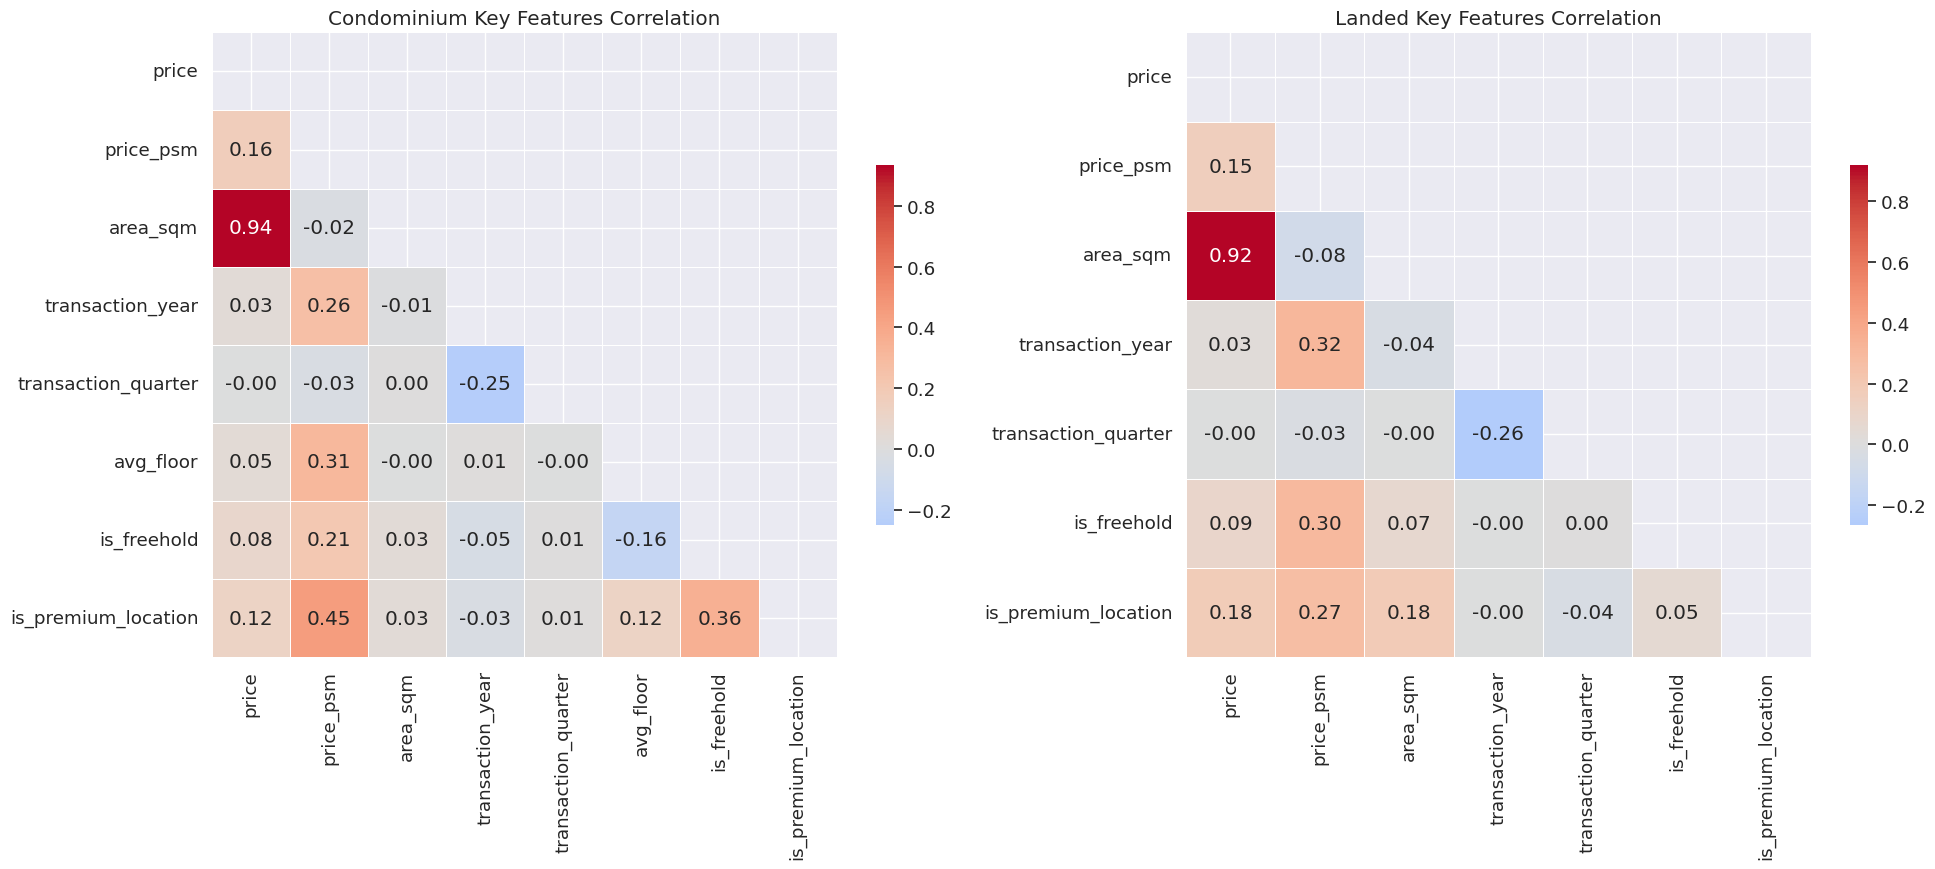

In [ ]:
key_features = ['price', 'price_psm', 'area_sqm', 'transaction_year', 'transaction_quarter']

if 'avg_floor' in condo_data.columns:
    key_features.append('avg_floor')
if 'is_freehold' in condo_data.columns:
    key_features.append('is_freehold')
if 'is_premium_location' in condo_data.columns:
    key_features.append('is_premium_location')

fig, ax = plt.subplots(1, 2, figsize=(20, 9))

condo_key_corr = condo_data[key_features].corr()
condo_mask = np.triu(np.ones_like(condo_key_corr, dtype=bool))
sns.heatmap(condo_key_corr, mask=condo_mask, annot=True, fmt=".2f", cmap='coolwarm',
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax[0])
ax[0].set_title('Condominium Key Features Correlation')

landed_key_features = [f for f in key_features if f in landed_data.columns]
landed_key_corr = landed_data[landed_key_features].corr()
landed_mask = np.triu(np.ones_like(landed_key_corr, dtype=bool))
sns.heatmap(landed_key_corr, mask=landed_mask, annot=True, fmt=".2f", cmap='coolwarm',
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax[1])
ax[1].set_title('Landed Key Features Correlation')

plt.tight_layout()
plt.show()

#Transaction Analysis by Month

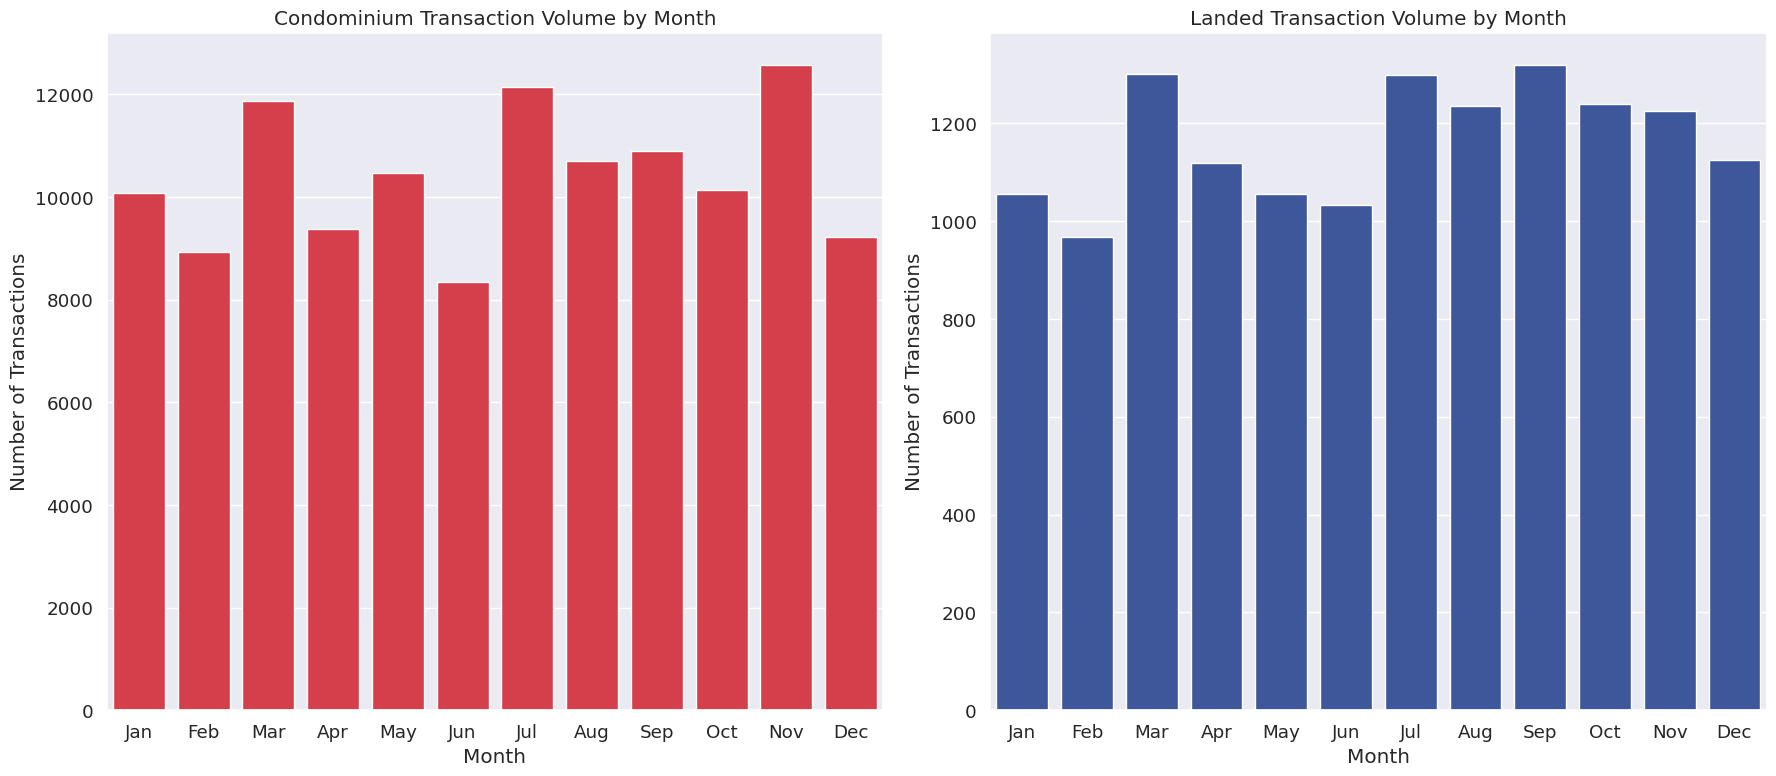

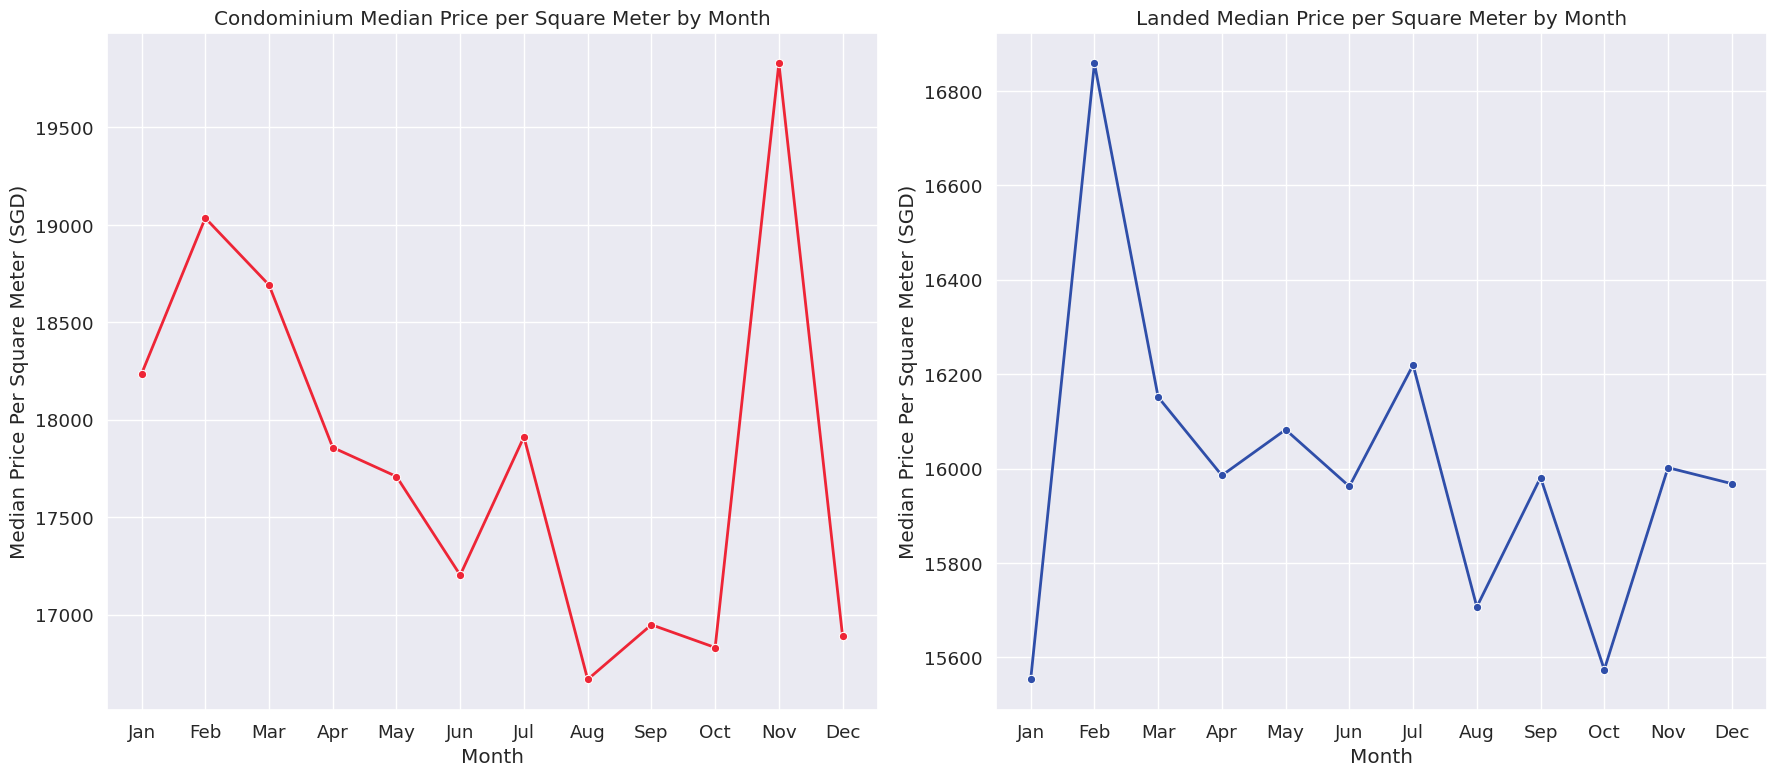

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

condo_month_counts = condo_data.groupby('transaction_month').size()
sns.barplot(x=condo_month_counts.index, y=condo_month_counts.values, ax=ax[0], color=sg_colors[0])
ax[0].set_title('Condominium Transaction Volume by Month')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Number of Transactions')
ax[0].set_xticks(range(12))
ax[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

landed_month_counts = landed_data.groupby('transaction_month').size()
sns.barplot(x=landed_month_counts.index, y=landed_month_counts.values, ax=ax[1], color=sg_colors[2])
ax[1].set_title('Landed Transaction Volume by Month')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Number of Transactions')
ax[1].set_xticks(range(12))
ax[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

condo_month_price = condo_data.groupby('transaction_month')['price_psm'].median().reset_index()
sns.lineplot(x='transaction_month', y='price_psm', data=condo_month_price, ax=ax[0],
             color=sg_colors[0], marker='o', linewidth=2)
ax[0].set_title('Condominium Median Price per Square Meter by Month')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Median Price Per Square Meter (SGD)')
ax[0].set_xticks(range(1, 13))
ax[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax[0].grid(True)

landed_month_price = landed_data.groupby('transaction_month')['price_psm'].median().reset_index()
sns.lineplot(x='transaction_month', y='price_psm', data=landed_month_price, ax=ax[1],
             color=sg_colors[2], marker='o', linewidth=2)
ax[1].set_title('Landed Median Price per Square Meter by Month')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Median Price Per Square Meter (SGD)')
ax[1].set_xticks(range(1, 13))
ax[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax[1].grid(True)

plt.tight_layout()
plt.show()

High Floor vs Low Floor Analysis (Condo Only)

<ipython-input-59-f073bdfcfb9c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_high_floor', y='price_psm', data=condo_data, ax=axes[0],
<ipython-input-59-f073bdfcfb9c>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Low Floor', 'High Floor'])


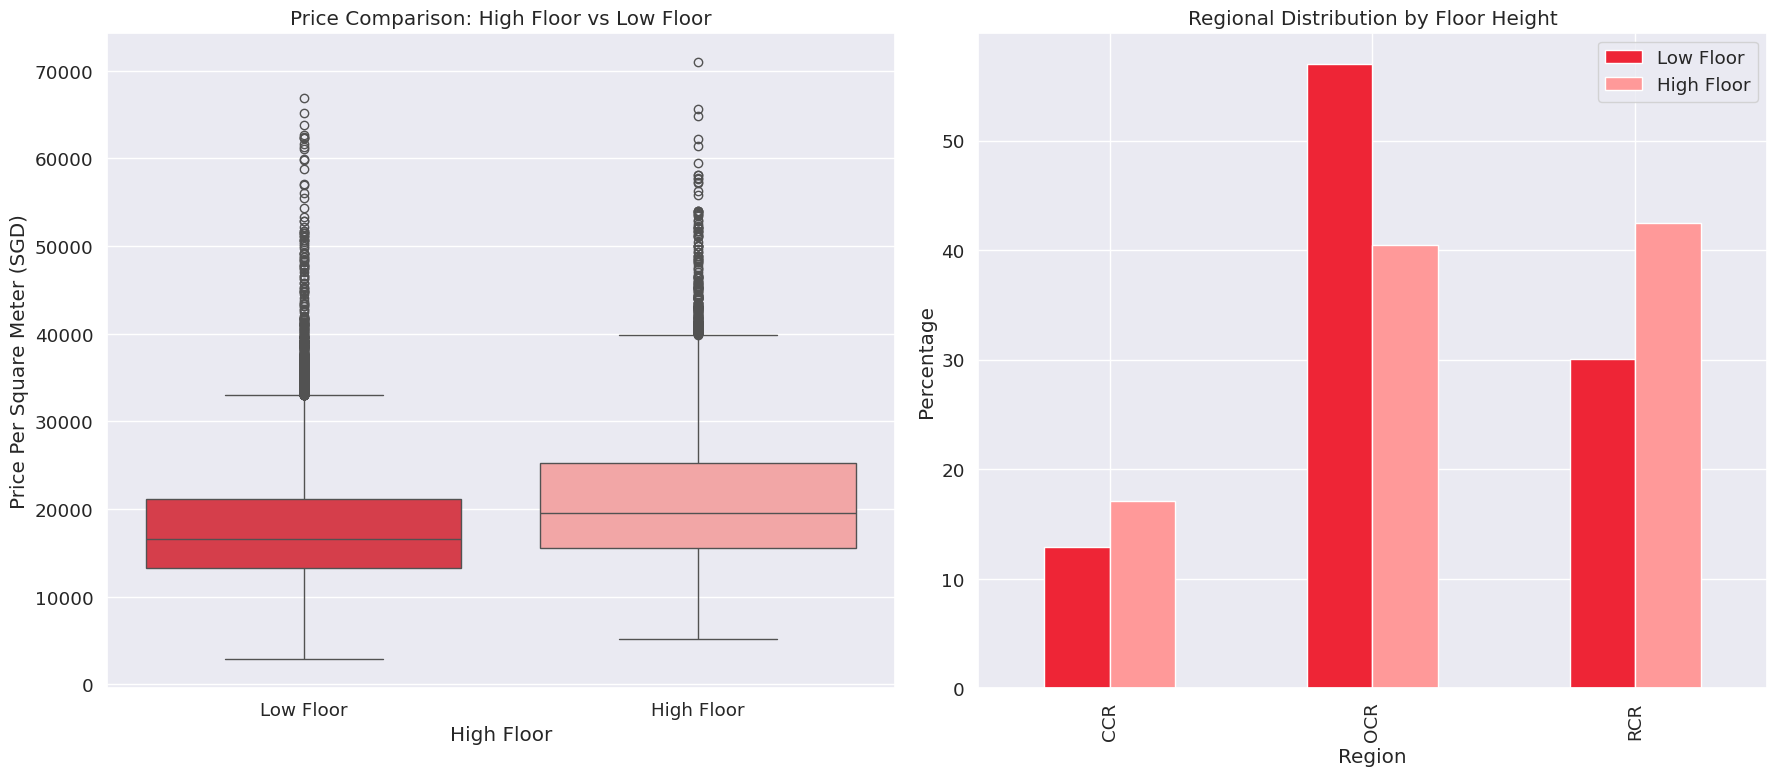

In [ ]:
if 'is_high_floor' in condo_data.columns:
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    sns.boxplot(x='is_high_floor', y='price_psm', data=condo_data, ax=axes[0],
                palette=[sg_colors[0], '#FF9999'])
    axes[0].set_title('Price Comparison: High Floor vs Low Floor')
    axes[0].set_xlabel('High Floor')
    axes[0].set_ylabel('Price Per Square Meter (SGD)')
    axes[0].set_xticklabels(['Low Floor', 'High Floor'])

    high_floor_region = pd.crosstab(condo_data['region'], condo_data['is_high_floor'],
                                    normalize='columns') * 100
    high_floor_region.plot(kind='bar', ax=axes[1], color=[sg_colors[0], '#FF9999'])
    axes[1].set_title('Regional Distribution by Floor Height')
    axes[1].set_xlabel('Region')
    axes[1].set_ylabel('Percentage')
    axes[1].legend(['Low Floor', 'High Floor'])

    plt.tight_layout()
    plt.show()

Premium Location

<ipython-input-60-090aad5be29a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_premium_location', y='price_psm', data=condo_data, ax=axes[0, 0],
<ipython-input-60-090aad5be29a>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Non-Premium', 'Premium'])
<ipython-input-60-090aad5be29a>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_premium_location', y='price_psm', data=landed_data, ax=axes[0, 1],
<ipython-input-60-090aad5be29a>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axe

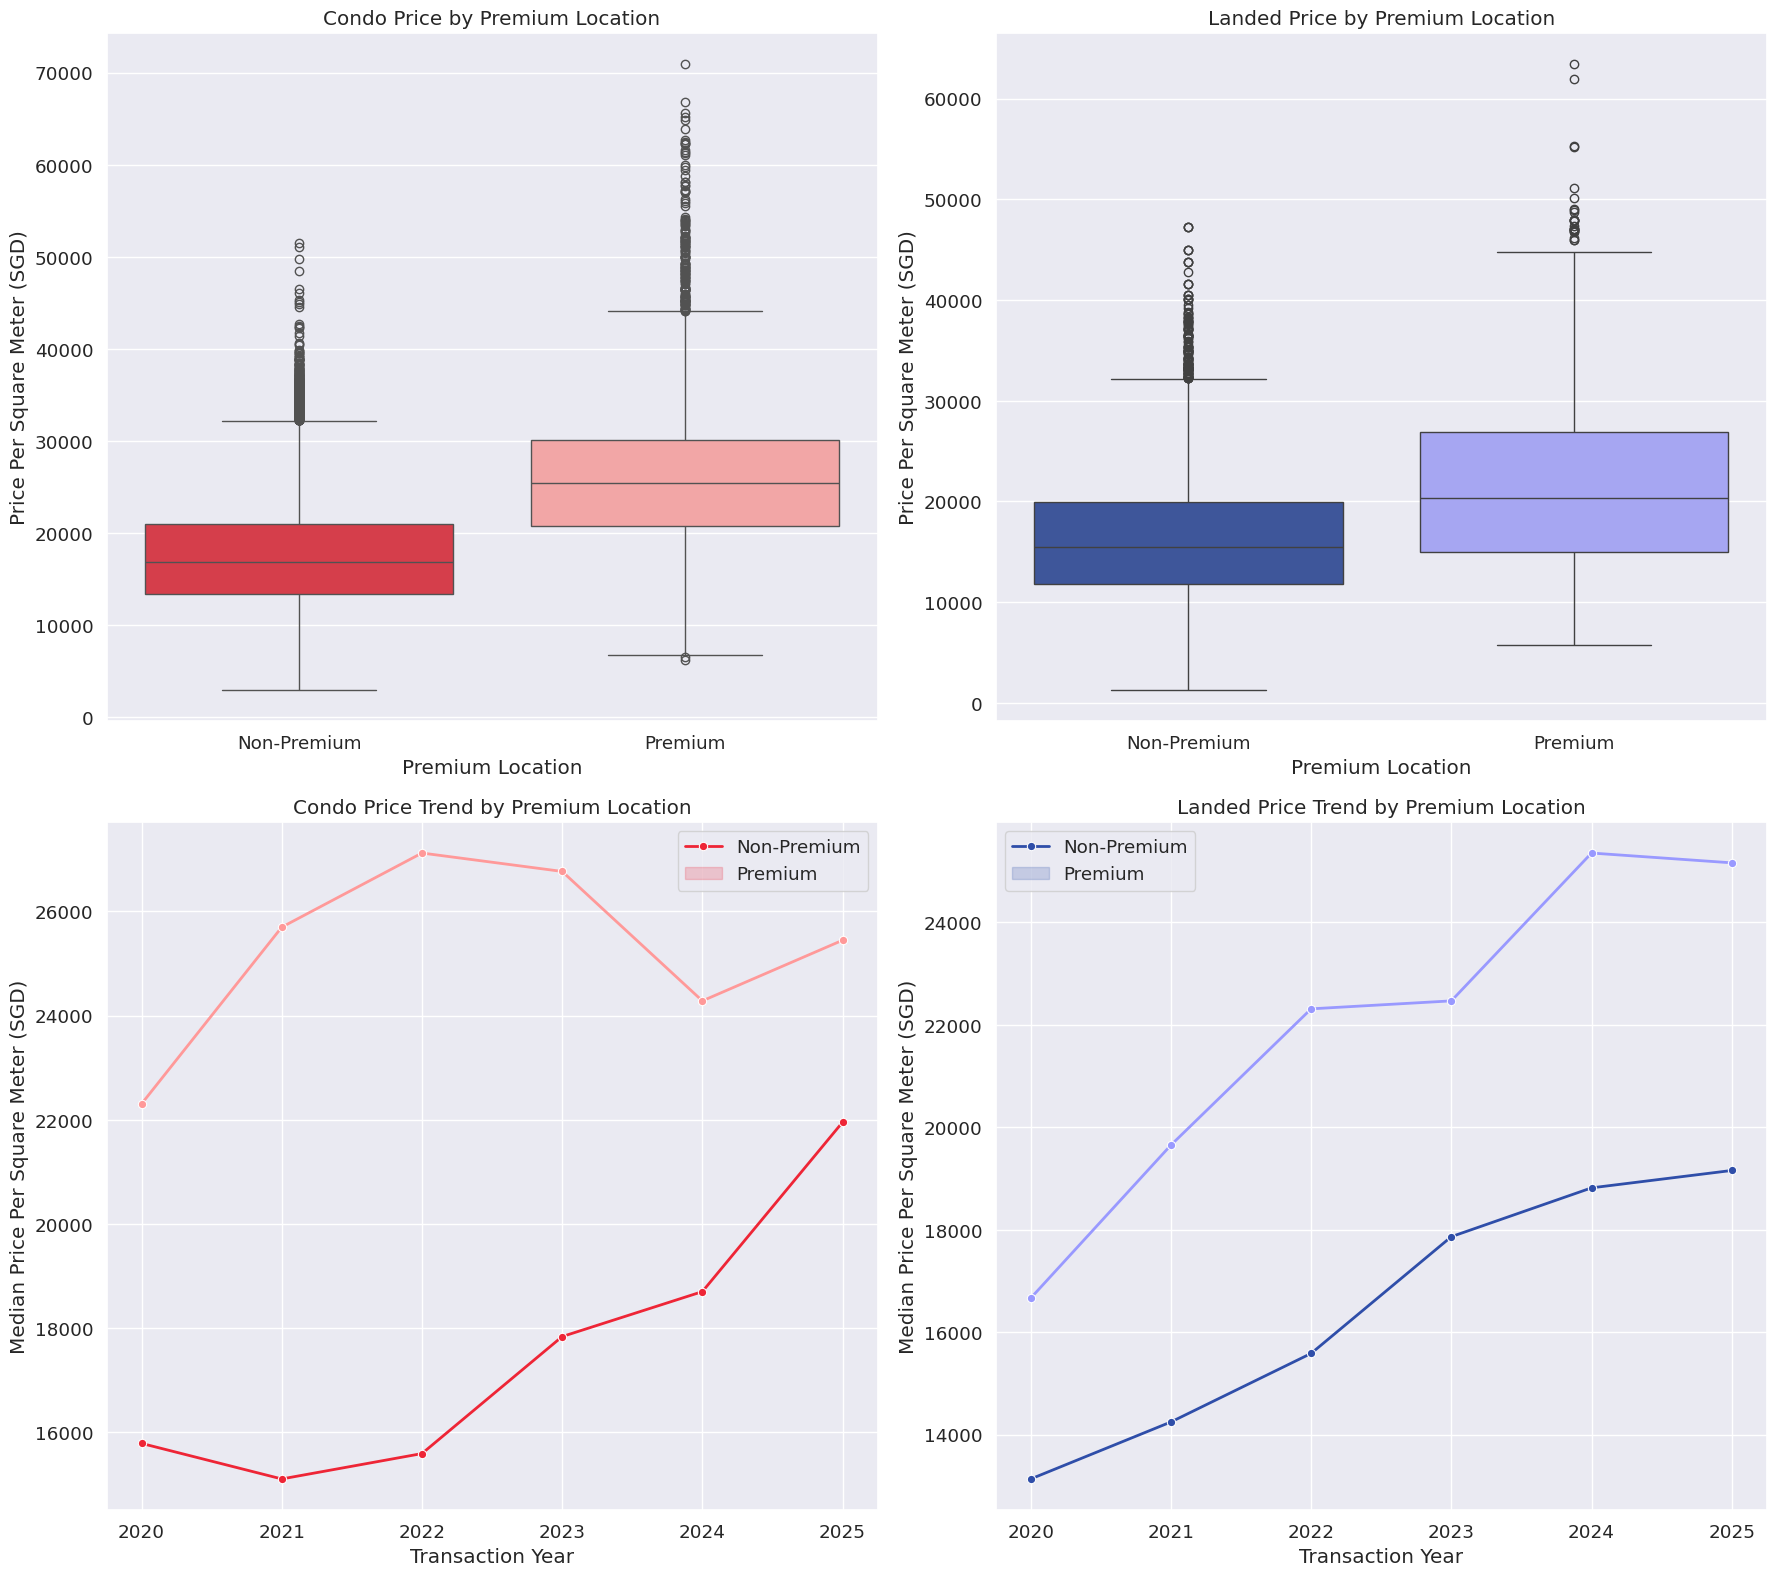

In [ ]:
if 'is_premium_location' in condo_data.columns and 'is_premium_location' in landed_data.columns:
    fig, axes = plt.subplots(2, 2, figsize=(18, 16))

    sns.boxplot(x='is_premium_location', y='price_psm', data=condo_data, ax=axes[0, 0],
                palette=[sg_colors[0], '#FF9999'])
    axes[0, 0].set_title('Condo Price by Premium Location')
    axes[0, 0].set_xlabel('Premium Location')
    axes[0, 0].set_ylabel('Price Per Square Meter (SGD)')
    axes[0, 0].set_xticklabels(['Non-Premium', 'Premium'])

    sns.boxplot(x='is_premium_location', y='price_psm', data=landed_data, ax=axes[0, 1],
                palette=[sg_colors[2], '#9999FF'])
    axes[0, 1].set_title('Landed Price by Premium Location')
    axes[0, 1].set_xlabel('Premium Location')
    axes[0, 1].set_ylabel('Price Per Square Meter (SGD)')
    axes[0, 1].set_xticklabels(['Non-Premium', 'Premium'])

    condo_premium_trend = condo_data.groupby(['transaction_year', 'is_premium_location'])['price_psm'].median().reset_index()
    sns.lineplot(x='transaction_year', y='price_psm', hue='is_premium_location',
                 data=condo_premium_trend, ax=axes[1, 0], palette=[sg_colors[0], '#FF9999'],
                 marker='o', linewidth=2)
    axes[1, 0].set_title('Condo Price Trend by Premium Location')
    axes[1, 0].set_xlabel('Transaction Year')
    axes[1, 0].set_ylabel('Median Price Per Square Meter (SGD)')
    axes[1, 0].legend(['Non-Premium', 'Premium'])
    axes[1, 0].grid(True)

    landed_premium_trend = landed_data.groupby(['transaction_year', 'is_premium_location'])['price_psm'].median().reset_index()
    sns.lineplot(x='transaction_year', y='price_psm', hue='is_premium_location',
                 data=landed_premium_trend, ax=axes[1, 1], palette=[sg_colors[2], '#9999FF'],
                 marker='o', linewidth=2)
    axes[1, 1].set_title('Landed Price Trend by Premium Location')
    axes[1, 1].set_xlabel('Transaction Year')
    axes[1, 1].set_ylabel('Median Price Per Square Meter (SGD)')
    axes[1, 1].legend(['Non-Premium', 'Premium'])
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

#Analysis

Geocoding Summary:
Total records: 138735
Successfully geocoded: 138735 (100.00%)
Failed geocoding: 0 (0.00%)

Geocoding Success Rate by District:
          Success Rate (%)  Count
district                         
1                    100.0   1156
2                    100.0   1237
3                    100.0   4732
4                    100.0   2155
5                    100.0   9888
6                    100.0    691
7                    100.0   1345
8                    100.0   1546
9                    100.0   5356
10                   100.0   8174
11                   100.0   3486
12                   100.0   3249
13                   100.0   2983
14                   100.0   6056
15                   100.0  12166
16                   100.0   5096
17                   100.0   2686
18                   100.0  10940
19                   100.0  17650
20                   100.0   3887
21                   100.0   6604
22                   100.0   2897
23                   100.0   8590
24  

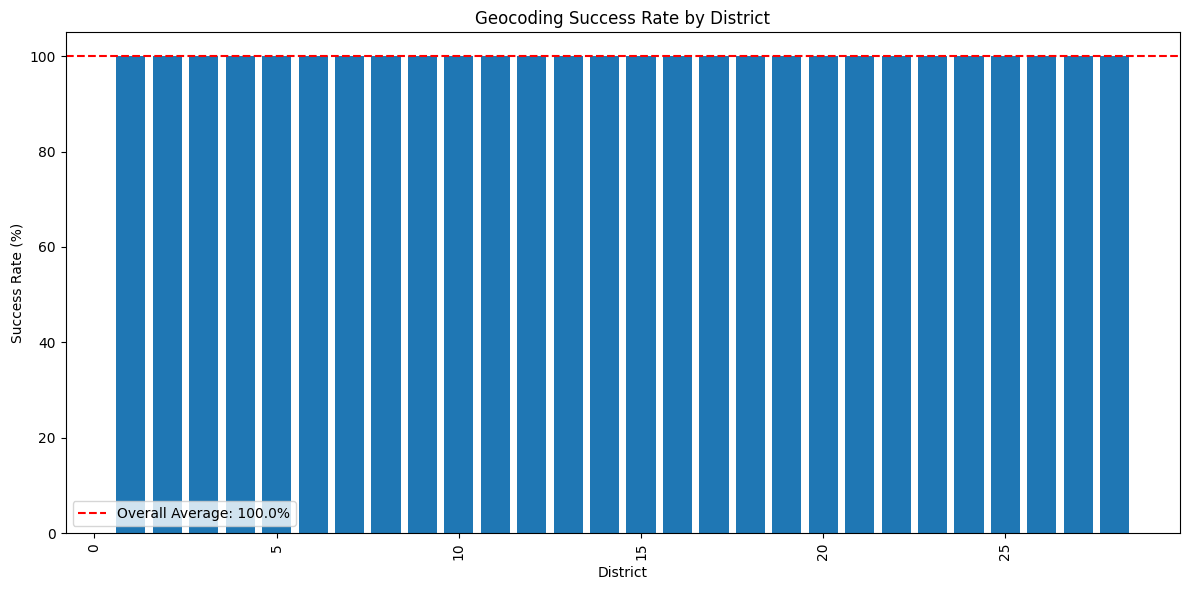

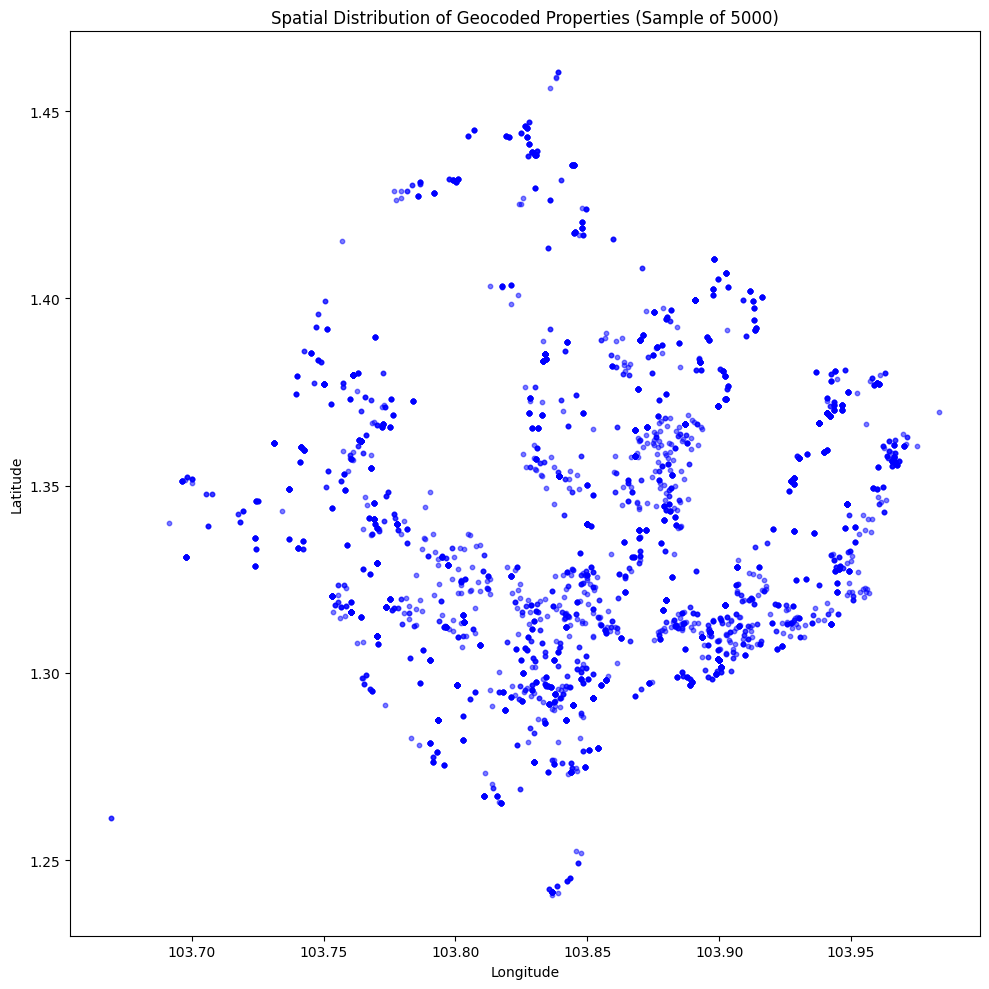

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

geocoded_df = pd.read_csv('data/ura/processed/geocoded_properties_full.csv')

total_records = len(geocoded_df)
successful_geocodes = (geocoded_df['geocoding_success'] == True).sum()
success_rate = (successful_geocodes / total_records) * 100

print(f"Geocoding Summary:")
print(f"Total records: {total_records}")
print(f"Successfully geocoded: {successful_geocodes} ({success_rate:.2f}%)")
print(f"Failed geocoding: {total_records - successful_geocodes} ({100 - success_rate:.2f}%)")

if 'district' in geocoded_df.columns:
    district_success = geocoded_df.groupby('district')['geocoding_success'].mean() * 100
    district_count = geocoded_df.groupby('district').size()

    district_results = pd.DataFrame({
        'Success Rate (%)': district_success,
        'Count': district_count
    }).sort_values('Success Rate (%)')

    print("\nGeocoding Success Rate by District:")
    print(district_results)

    plt.figure(figsize=(12, 6))
    plt.bar(district_results.index, district_results['Success Rate (%)'])
    plt.axhline(y=success_rate, color='r', linestyle='--', label=f'Overall Average: {success_rate:.1f}%')
    plt.xlabel('District')
    plt.ylabel('Success Rate (%)')
    plt.title('Geocoding Success Rate by District')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig('data/ura/processed/geocoding_success_by_district.png')
    plt.show()

if 'property_category' in geocoded_df.columns:
    property_success = geocoded_df.groupby('property_category')['geocoding_success'].mean() * 100
    property_count = geocoded_df.groupby('property_category').size()

    print("\nGeocoding Success Rate by Property Type:")
    pd.DataFrame({
        'Success Rate (%)': property_success,
        'Count': property_count
    }).sort_values('Success Rate (%)')

if successful_geocodes > 0:
    geocoded_sample = geocoded_df[geocoded_df['geocoding_success'] == True].sample(min(5000, successful_geocodes))

    plt.figure(figsize=(10, 10))
    plt.scatter(geocoded_sample['longitude'], geocoded_sample['latitude'],
                alpha=0.5, s=10, c='blue')
    plt.title(f'Spatial Distribution of Geocoded Properties (Sample of {len(geocoded_sample)})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    plt.savefig('data/ura/processed/geocoded_properties_map.png')
    plt.show()

In [ ]:
condo_data

street   project_name      x_coord       y_coord  \
0            BEACH ROAD          AUREA          NaN           NaN   
1            BEACH ROAD          AUREA          NaN           NaN   
2            BEACH ROAD          AUREA          NaN           NaN   
3            BEACH ROAD          AUREA          NaN           NaN   
4            BEACH ROAD          AUREA          NaN           NaN   
...                 ...            ...          ...           ...   
124762  HILLVIEW AVENUE  GLENDALE PARK  20422.96503  38290.242780   
124763  HILLVIEW AVENUE  GLENDALE PARK  20422.96503  38290.242780   
124764  HILLVIEW AVENUE  GLENDALE PARK  20422.96503  38290.242780   
124765  HILLVIEW AVENUE  GLENDALE PARK  20422.96503  38290.242780   
124766    GOODLINK PARK  GOODLINK PARK  27055.87048  45402.904304   

       market_segment  area_sqm floor_range  units  contract_date_raw  \
0                 CCR     167.0       21-25      1                325   
1                 CCR     167.0       21-25      1                325   
2                 CCR     167.0       21-25      1                325   
3                 CCR     167.0       26-30      1                325   
4                 CCR     134.0       11-15      1                325   
...               ...       ...         ...    ...                ...   
124762            OCR     110.0       01-05      1               1024   
124763            OCR     116.0       06-10      1               1223   
124764            OCR      96.0       01-05      1               1224   
124765            OCR     112.0       06-10      1                125   
124766            OCR     193.0       01-05      1                521   

        type_of_sale  ...  is_ec is_apartment      tenure_type is_freehold  \
0                  1  ...  False         True  Other Leasehold       False   
1                  1  ...  False         True  Other Leasehold       False   
2                  1  ...  False         True  Other Leasehold       False   
3                  1  ...  False         True  Other Leasehold       False   
4                  1  ...  False         True  Other Leasehold       False   
...              ...  ...    ...          ...              ...         ...   
124762             3  ...  False        False         Freehold        True   
124763             3  ...  False        False         Freehold        True   
124764             3  ...  False        False         Freehold        True   
124765             3  ...  False        False         Freehold        True   
124766             3  ...  False         True         Freehold        True   

       is_new_sale is_resale  is_subsale  log_price    log_psm  log_area  
0            False     False       False  15.572558  10.454564  5.117994  
1            False     False       False  15.585237  10.467243  5.117994  
2            False     False       False  15.584890  10.466896  5.117994  
3            False     False       False  15.622465  10.504471  5.117994  
4            False     False       False  15.276707  10.378867  4.897840  
...            ...       ...         ...        ...        ...       ...  
124762       False     False       False  14.386490   9.686010  4.700480  
124763       False     False       False  14.523546   9.769956  4.753590  
124764       False     False       False  14.430696   9.866348  4.564348  
124765       False     False       False  14.430696   9.712197  4.718499  
124766       False     False       False  14.077875   8.815185  5.262690  

[124767 rows x 43 columns]

In [ ]:
landed_data

street   project_name      x_coord       y_coord  \
0            BEACH ROAD          AUREA          NaN           NaN   
1            BEACH ROAD          AUREA          NaN           NaN   
2            BEACH ROAD          AUREA          NaN           NaN   
3            BEACH ROAD          AUREA          NaN           NaN   
4            BEACH ROAD          AUREA          NaN           NaN   
...                 ...            ...          ...           ...   
124762  HILLVIEW AVENUE  GLENDALE PARK  20422.96503  38290.242780   
124763  HILLVIEW AVENUE  GLENDALE PARK  20422.96503  38290.242780   
124764  HILLVIEW AVENUE  GLENDALE PARK  20422.96503  38290.242780   
124765  HILLVIEW AVENUE  GLENDALE PARK  20422.96503  38290.242780   
124766    GOODLINK PARK  GOODLINK PARK  27055.87048  45402.904304   

       market_segment  area_sqm floor_range  units  contract_date_raw  \
0                 CCR     167.0       21-25      1                325   
1                 CCR     167.0       21-25      1                325   
2                 CCR     167.0       21-25      1                325   
3                 CCR     167.0       26-30      1                325   
4                 CCR     134.0       11-15      1                325   
...               ...       ...         ...    ...                ...   
124762            OCR     110.0       01-05      1               1024   
124763            OCR     116.0       06-10      1               1223   
124764            OCR      96.0       01-05      1               1224   
124765            OCR     112.0       06-10      1                125   
124766            OCR     193.0       01-05      1                521   

        type_of_sale  ...  is_terrace is_strata      tenure_type is_freehold  \
0                  1  ...       False     False  Other Leasehold       False   
1                  1  ...       False     False  Other Leasehold       False   
2                  1  ...       False     False  Other Leasehold       False   
3                  1  ...       False     False  Other Leasehold       False   
4                  1  ...       False     False  Other Leasehold       False   
...              ...  ...         ...       ...              ...         ...   
124762             3  ...       False     False         Freehold        True   
124763             3  ...       False     False         Freehold        True   
124764             3  ...       False     False         Freehold        True   
124765             3  ...       False     False         Freehold        True   
124766             3  ...       False     False         Freehold        True   

       is_new_sale is_resale  is_subsale  log_price    log_psm  log_area  
0            False     False       False  15.572558  10.454564  5.117994  
1            False     False       False  15.585237  10.467243  5.117994  
2            False     False       False  15.584890  10.466896  5.117994  
3            False     False       False  15.622465  10.504471  5.117994  
4            False     False       False  15.276707  10.378867  4.897840  
...            ...       ...         ...        ...        ...       ...  
124762       False     False       False  14.386490   9.686010  4.700480  
124763       False     False       False  14.523546   9.769956  4.753590  
124764       False     False       False  14.430696   9.866348  4.564348  
124765       False     False       False  14.430696   9.712197  4.718499  
124766       False     False       False  14.077875   8.815185  5.262690  

[124767 rows x 45 columns]

In [ ]:
condo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124767 entries, 0 to 124766
Data columns (total 43 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   street                124767 non-null  object 
 1   project_name          124767 non-null  object 
 2   x_coord               111150 non-null  float64
 3   y_coord               111150 non-null  float64
 4   market_segment        124767 non-null  object 
 5   area_sqm              124767 non-null  float64
 6   floor_range           124767 non-null  object 
 7   units                 124767 non-null  int64  
 8   contract_date_raw     124767 non-null  int64  
 9   type_of_sale          124767 non-null  int64  
 10  price                 124767 non-null  int64  
 11  property_type         124767 non-null  object 
 12  district              124767 non-null  int64  
 13  type_of_area          124767 non-null  object 
 14  tenure                124767 non-null  object 
 15  

In [ ]:
landed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124767 entries, 0 to 124766
Data columns (total 45 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   street                124767 non-null  object 
 1   project_name          124767 non-null  object 
 2   x_coord               111150 non-null  float64
 3   y_coord               111150 non-null  float64
 4   market_segment        124767 non-null  object 
 5   area_sqm              124767 non-null  float64
 6   floor_range           124767 non-null  object 
 7   units                 124767 non-null  int64  
 8   contract_date_raw     124767 non-null  int64  
 9   type_of_sale          124767 non-null  int64  
 10  price                 124767 non-null  int64  
 11  property_type         124767 non-null  object 
 12  district              124767 non-null  int64  
 13  type_of_area          124767 non-null  object 
 14  tenure                124767 non-null  object 
 15  

#Model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb

In [ ]:
engineered_features = [
    'property_type', 'district', 'region', 'area_sqm', 'floor_range',
    'transaction_date', 'transaction_year', 'transaction_quarter', 'price_psm',

    'log_price', 'log_psm', 'log_area',
    'tenure_type', 'is_freehold',
    'size_category',
    'is_premium_location',
    'transaction_month', 'year_quarter_num',

    'avg_floor', 'lower_floor', 'upper_floor', 'is_high_floor',
    'is_ec', 'is_apartment',
    'is_detached', 'is_semi_detached', 'is_terrace', 'is_strata',
    'is_multi_level',

    'is_new_sale', 'is_resale', 'is_subsale'
]

target_variable = 'price'

In [ ]:
engineered_features

['property_type',
 'district',
 'region',
 'area_sqm',
 'floor_range',
 'transaction_date',
 'transaction_year',
 'transaction_quarter',
 'price_psm',
 'log_price',
 'log_psm',
 'log_area',
 'tenure_type',
 'is_freehold',
 'size_category',
 'is_premium_location',
 'transaction_month',
 'year_quarter_num',
 'avg_floor',
 'lower_floor',
 'upper_floor',
 'is_high_floor',
 'is_ec',
 'is_apartment',
 'is_detached',
 'is_semi_detached',
 'is_terrace',
 'is_strata',
 'is_multi_level',
 'is_new_sale',
 'is_resale',
 'is_subsale']

Prepare Data for Modeling

In [ ]:
def prepare_modeling_data(condo_data, landed_data):
    """Prepare the already processed data for modeling with detailed output"""

    print("=== Data Preparation for Modeling ===")

    print("\nChecking condominium data...")
    print(f"Initial shape: {condo_data.shape}")

    key_columns = ['price', 'area_sqm', 'district', 'region', 'transaction_year']
    missing_columns = [col for col in key_columns if col not in condo_data.columns]

    if missing_columns:
        print(f"WARNING: Missing key columns in condo data: {missing_columns}")
    else:
        print("All key columns present in condo data")

    if not missing_columns:
        for col in key_columns:
            missing_count = condo_data[col].isnull().sum()
            missing_pct = missing_count / len(condo_data) * 100
            print(f"Column '{col}': {missing_count} missing values ({missing_pct:.2f}%)")

            if missing_pct > 5:
                print(f"WARNING: More than 5% missing values in '{col}'")

    print("\nChecking landed data...")
    print(f"Initial shape: {landed_data.shape}")

    missing_columns = [col for col in key_columns if col not in landed_data.columns]

    if missing_columns:
        print(f"WARNING: Missing key columns in landed data: {missing_columns}")
    else:
        print("All key columns present in landed data")

    if not missing_columns:
        for col in key_columns:
            missing_count = landed_data[col].isnull().sum()
            missing_pct = missing_count / len(landed_data) * 100
            print(f"Column '{col}': {missing_count} missing values ({missing_pct:.2f}%)")

            if missing_pct > 5:
                print(f"WARNING: More than 5% missing values in '{col}'")

    print("\nHandling missing values...")

    condo_data_clean = condo_data.copy()
    landed_data_clean = landed_data.copy()

    for df_name, df in [("Condo", condo_data_clean), ("Landed", landed_data_clean)]:
        missing_before = df.isnull().sum().sum()

        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
        for col in numerical_cols:
            if df[col].isnull().sum() > 0:
                print(f"Filling {df[col].isnull().sum()} missing values in {df_name} - {col} with median")
                df[col].fillna(df[col].median(), inplace=True)

        categorical_cols = df.select_dtypes(include=['object', 'category']).columns
        for col in categorical_cols:
            if df[col].isnull().sum() > 0:
                print(f"Filling {df[col].isnull().sum()} missing values in {df_name} - {col} with mode")
                df[col].fillna(df[col].mode()[0], inplace=True)

        missing_after = df.isnull().sum().sum()
        print(f"{df_name}: Filled {missing_before - missing_after} missing values. Remaining: {missing_after}")

    print("\nVerifying data is ready for modeling...")

    for df_name, df in [("Condo", condo_data_clean), ("Landed", landed_data_clean)]:
        inf_count = np.isinf(df.select_dtypes(include=['float64']).values).sum()
        if inf_count > 0:
            print(f"WARNING: {df_name} data contains {inf_count} infinite values")

        for col in df.select_dtypes(include=['float64']).columns:
            min_val = df[col].min()
            max_val = df[col].max()

            if min_val < -1e10 or max_val > 1e10:
                print(f"WARNING: {df_name} - {col} has extreme values: min={min_val}, max={max_val}")

    print("\nData preparation complete!")
    print(f"Condominium data: {condo_data_clean.shape[0]} rows, {condo_data_clean.shape[1]} columns")
    print(f"Landed data: {landed_data_clean.shape[0]} rows, {landed_data_clean.shape[1]} columns")

    return condo_data_clean, landed_data_clean

In [ ]:
condo_data_prepared, landed_data_prepared = prepare_modeling_data(condo_data, landed_data)

print("\nSample of prepared condominium data:")
print(condo_data_prepared[['price', 'area_sqm', 'district', 'region', 'transaction_year']].head())

print("\nSample of prepared landed data:")
print(landed_data_prepared[['price', 'area_sqm', 'district', 'region', 'transaction_year']].head())

=== Data Preparation for Modeling ===

Checking condominium data...
Initial shape: (124767, 43)
All key columns present in condo data
Column 'price': 0 missing values (0.00%)
Column 'area_sqm': 0 missing values (0.00%)
Column 'district': 0 missing values (0.00%)
Column 'region': 0 missing values (0.00%)
Column 'transaction_year': 0 missing values (0.00%)

Checking landed data...
Initial shape: (124767, 45)
All key columns present in landed data
Column 'price': 0 missing values (0.00%)
Column 'area_sqm': 0 missing values (0.00%)
Column 'district': 0 missing values (0.00%)
Column 'region': 0 missing values (0.00%)
Column 'transaction_year': 0 missing values (0.00%)

Handling missing values...
Filling 13617 missing values in Condo - x_coord with median
Filling 13617 missing values in Condo - y_coord with median


<ipython-input-25-5e4f352a8373>:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


Condo: Filled 27234 missing values. Remaining: 0
Filling 13617 missing values in Landed - x_coord with median
Filling 13617 missing values in Landed - y_coord with median


<ipython-input-25-5e4f352a8373>:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


Landed: Filled 27234 missing values. Remaining: 0

Verifying data is ready for modeling...

Data preparation complete!
Condominium data: 124767 rows, 43 columns
Landed data: 124767 rows, 45 columns

Sample of prepared condominium data:
     price  area_sqm  district region  transaction_year
0  5795300     167.0         7    RCR              2025
1  5869248     167.0         7    RCR              2025
2  5867210     167.0         7    RCR              2025
3  6091865     167.0         7    RCR              2025
4  4311115     134.0         7    RCR              2025

Sample of prepared landed data:
     price  area_sqm  district region  transaction_year
0  5795300     167.0         7    RCR              2025
1  5869248     167.0         7    RCR              2025
2  5867210     167.0         7    RCR              2025
3  6091865     167.0         7    RCR              2025
4  4311115     134.0         7    RCR              2025


Define Feature types for preprocessing

In [ ]:
def identify_feature_types(df):
    """Identify categorical and numerical features for preprocessing"""

    boolean_cols = [col for col in df.columns
                   if col != target_variable and df[col].dtype == bool]

    for col in boolean_cols:
        df[col] = df[col].astype(int)

    categorical_cols = [col for col in df.columns
                       if col != target_variable and
                       (df[col].dtype == 'object' or
                        df[col].dtype.name == 'category' or
                        col in ['region', 'district', 'tenure_type', 'size_category',
                                'floor_range', 'property_type'])]

    numerical_cols = [col for col in df.columns
                     if col != target_variable and
                     col not in categorical_cols and
                     col not in boolean_cols]

    print(f"Identified {len(numerical_cols)} numerical features")
    print(f"Identified {len(categorical_cols)} categorical features")
    print(f"Identified {len(boolean_cols)} boolean features (already encoded)")

    return numerical_cols, categorical_cols, boolean_cols

Build Modeling Pipeline

In [ ]:
def create_modeling_pipeline(numerical_cols, categorical_cols, boolean_cols):
    """Create preprocessing and modeling pipeline"""

    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])


    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols),
        ],
        remainder='passthrough'
    )

    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.01),
        'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
        'LightGBM': lgb.LGBMRegressor(objective='regression', random_state=42)
    }

    return preprocessor, models

Segment-Specific Modeling

In [ ]:
def train_segment_specific_models(condo_data, landed_data):
    """Train separate models for each property segment based on EDA findings"""

    segment_models = {}

    regions = ['CCR', 'RCR', 'OCR']

    print("\n=== Training Condominium Models ===")
    for region in regions:
        print(f"\nTraining model for {region} Condominiums")

        region_data = condo_data[condo_data['region'] == region].copy()

        if len(region_data) < 100:
            print(f"Insufficient data for {region} Condominiums. Skipping.")
            continue

        print(f"Using {len(region_data)} records")

        numerical_cols, categorical_cols, boolean_cols = identify_feature_types(region_data)

        preprocessor, models = create_modeling_pipeline(numerical_cols, categorical_cols, boolean_cols)

        X = region_data.drop(target_variable, axis=1)
        y = region_data[target_variable]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        best_model, best_score, all_results = evaluate_models(
            X_train, X_test, y_train, y_test,
            preprocessor, models
        )

        segment_name = f"{region} Condominium"
        segment_models[segment_name] = {
            'model': best_model,
            'score': best_score,
            'results': all_results,
            'numerical_cols': numerical_cols,
            'categorical_cols': categorical_cols,
            'boolean_cols': boolean_cols,
            'preprocessor': preprocessor
        }

    print("\n=== Training Landed Property Models ===")
    for region in regions:
        print(f"\nTraining model for {region} Landed Properties")

        region_data = landed_data[landed_data['region'] == region].copy()

        if len(region_data) < 100:
            print(f"Insufficient data for {region} Landed Properties. Skipping.")
            continue

        print(f"Using {len(region_data)} records")

        numerical_cols, categorical_cols, boolean_cols = identify_feature_types(region_data)

        preprocessor, models = create_modeling_pipeline(numerical_cols, categorical_cols, boolean_cols)

        X = region_data.drop(target_variable, axis=1)
        y = region_data[target_variable]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        best_model, best_score, all_results = evaluate_models(
            X_train, X_test, y_train, y_test,
            preprocessor, models
        )

        segment_name = f"{region} Landed"
        segment_models[segment_name] = {
            'model': best_model,
            'score': best_score,
            'results': all_results,
            'numerical_cols': numerical_cols,
            'categorical_cols': categorical_cols,
            'boolean_cols': boolean_cols,
            'preprocessor': preprocessor
        }

    return segment_models

Model Evaluation Function

In [ ]:
def evaluate_models(X_train, X_test, y_train, y_test, preprocessor, models):
    """Train and evaluate multiple models, return the best one"""

    results = {}
    best_model = None
    best_score = float('inf')

    for name, model in models.items():
        print(f"Training {name}...")

        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        percentage_error = np.abs((y_test - y_pred) / y_test) * 100
        mape = np.mean(percentage_error)

        within_5pct = (percentage_error <= 5).mean() * 100
        within_10pct = (percentage_error <= 10).mean() * 100
        within_15pct = (percentage_error <= 15).mean() * 100

        results[name] = {
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'MAPE': mape,
            'Within 5%': within_5pct,
            'Within 10%': within_10pct,
            'Within 15%': within_15pct,
            'pipeline': pipeline
        }

        print(f"  MAE: ${mae:,.2f}")
        print(f"  RMSE: ${rmse:,.2f}")
        print(f"  R²: {r2:.4f}")
        print(f"  MAPE: {mape:.2f}%")
        print(f"  Within 5%: {within_5pct:.2f}%")
        print(f"  Within 10%: {within_10pct:.2f}%")
        print(f"  Within 15%: {within_15pct:.2f}%")

        if rmse < best_score:
            best_score = rmse
            best_model = pipeline

    print(f"\nBest model: {min(results.items(), key=lambda x: x[1]['RMSE'])[0]}")
    print(f"Best RMSE: ${best_score:,.2f}")

    return best_model, best_score, results

Feature Importance Analysis

In [ ]:
def analyze_feature_importance(model_info, segment_name):
    """Analyze feature importance from the trained model"""

    print(f"\nAnalyzing feature importance for {segment_name} model")

    pipeline = model_info['model']
    model = pipeline.named_steps['model']

    preprocessor = pipeline.named_steps['preprocessor']

    if hasattr(model, 'feature_importances_'):
        importance_type = 'Feature Importance'

        cat_cols = model_info['categorical_cols']
        num_cols = model_info['numerical_cols']
        bool_cols = model_info['boolean_cols']

        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        cat_features = ohe.get_feature_names_out(cat_cols)

        feature_names = list(num_cols) + list(cat_features) + list(bool_cols)

        importances = model.feature_importances_

    elif hasattr(model, 'coef_'):
        importance_type = 'Coefficient Magnitude'

        cat_cols = model_info['categorical_cols']
        num_cols = model_info['numerical_cols']
        bool_cols = model_info['boolean_cols']

        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        cat_features = ohe.get_feature_names_out(cat_cols)

        feature_names = list(num_cols) + list(cat_features) + list(bool_cols)

        importances = np.abs(model.coef_)

    else:
        print("Model doesn't provide feature importance or coefficients.")
        return None

    if len(feature_names) != len(importances):
        print(f"Warning: Feature names ({len(feature_names)}) and importance scores ({len(importances)}) have different lengths.")
        return None

    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title(f'Top 20 Features by {importance_type} - {segment_name}')
    plt.tight_layout()
    plt.show()

    return feature_importance

Property Valuation Function

In [ ]:
def create_valuation_function(segment_models):
    """Create a function to predict property values based on input features"""

    def predict_property_value(property_details):
        """
        Predict property value based on property details.

        Args:
            property_details: Dictionary with property features
                Required keys: 'property_type' ('Condominium' or 'Landed'),
                               'region' ('CCR', 'RCR', or 'OCR'),
                               other features used by the model

        Returns:
            Predicted property value in SGD
        """
        property_type = property_details.get('property_type', '')
        region = property_details.get('region', '')

        if 'Condominium' in property_type or property_type in ['Apartment', 'Executive Condominium']:
            segment = f"{region} Condominium"
        else:
            segment = f"{region} Landed"

        if segment not in segment_models:
            raise ValueError(f"No valuation model available for {segment}")

        model_info = segment_models[segment]
        pipeline = model_info['model']

        input_df = pd.DataFrame([property_details])

        predicted_value = pipeline.predict(input_df)[0]

        rmse = model_info['score']
        lower_bound = predicted_value - 1.96 * rmse
        upper_bound = predicted_value + 1.96 * rmse

        range_percent = (upper_bound - lower_bound) / predicted_value * 100

        return {
            'segment': segment,
            'predicted_value': predicted_value,
            'lower_bound': max(0, lower_bound),
            'upper_bound': upper_bound,
            'confidence_range_percent': range_percent
        }

    return predict_property_value

Model Validation and Benchmarking

In [ ]:
def validate_models(segment_models, condo_data, landed_data):
    """Validate models on test cases and benchmark against actual transactions"""

    test_cases = []

    for region in ['CCR', 'RCR', 'OCR']:
        latest_year = condo_data['transaction_year'].max()
        region_sample = condo_data[(condo_data['region'] == region) &
                                   (condo_data['transaction_year'] == latest_year)].sample(5)

        for _, row in region_sample.iterrows():
            test_case = {
                'actual_price': row['price'],
                'features': row.drop('price').to_dict()
            }
            test_cases.append(test_case)

    for region in ['CCR', 'RCR', 'OCR']:
        latest_year = landed_data['transaction_year'].max()
        region_sample = landed_data[(landed_data['region'] == region) &
                                    (landed_data['transaction_year'] == latest_year)].sample(5)

        for _, row in region_sample.iterrows():
            test_case = {
                'actual_price': row['price'],
                'features': row.drop('price').to_dict()
            }
            test_cases.append(test_case)

    predict_value = create_valuation_function(segment_models)

    results = []

    for i, test_case in enumerate(test_cases):
        try:
            prediction = predict_value(test_case['features'])

            actual = test_case['actual_price']
            predicted = prediction['predicted_value']
            error = predicted - actual
            error_percent = error / actual * 100

            within_interval = (actual >= prediction['lower_bound'] and
                               actual <= prediction['upper_bound'])

            result = {
                'Test Case': i + 1,
                'Segment': prediction['segment'],
                'Actual Price': actual,
                'Predicted Price': predicted,
                'Error': error,
                'Error %': error_percent,
                'Within CI': within_interval
            }
            results.append(result)

        except Exception as e:
            print(f"Error predicting test case {i + 1}: {e}")

    results_df = pd.DataFrame(results)

    print("\n=== Model Validation Results ===")
    print(f"Total test cases: {len(results)}")
    print(f"Mean Absolute Error: ${results_df['Error'].abs().mean():,.2f}")
    print(f"Mean Absolute Percentage Error: {results_df['Error %'].abs().mean():.2f}%")
    print(f"Cases within 5% of actual: {(results_df['Error %'].abs() <= 5).mean() * 100:.2f}%")
    print(f"Cases within 10% of actual: {(results_df['Error %'].abs() <= 10).mean() * 100:.2f}%")
    print(f"Cases within 15% of actual: {(results_df['Error %'].abs() <= 15).mean() * 100:.2f}%")
    print(f"Cases within confidence interval: {results_df['Within CI'].mean() * 100:.2f}%")

    print("\n=== Results by Segment ===")
    segment_results = results_df.groupby('Segment')[['Error %', 'Within CI']].agg({
        'Error %': ['mean', 'std', 'min', 'max'],
        'Within CI': 'mean'
    })
    print(segment_results)

    return results_df

Main Execution Function

In [ ]:
def build_property_valuation_model(condo_data, landed_data):
    """Main function to build the property valuation model"""

    print("=== Preparing Data ===")
    condo_modeling_data, landed_modeling_data = prepare_modeling_data(condo_data, landed_data)

    print("\n=== Training Models ===")
    segment_models = train_segment_specific_models(condo_modeling_data, landed_modeling_data)

    print("\n=== Analyzing Feature Importance ===")
    for segment_name, model_info in segment_models.items():
        feature_importance = analyze_feature_importance(model_info, segment_name)
        model_info['feature_importance'] = feature_importance

    print("\n=== Creating Valuation Function ===")
    property_valuation_function = create_valuation_function(segment_models)

    print("\n=== Validating Models ===")
    validation_results = validate_models(segment_models, condo_modeling_data, landed_modeling_data)

    return {
        'segment_models': segment_models,
        'valuation_function': property_valuation_function,
        'validation_results': validation_results
    }

Usage Example

In [ ]:
def train_segment_specific_models(condo_data, landed_data):
    """Train separate models for each property segment while handling datetime columns properly"""

    segment_models = {}

    regions = ['CCR', 'RCR', 'OCR']

    print("\n=== Training Condominium Models ===")
    for region in regions:
        print(f"\nTraining model for {region} Condominiums")

        region_data = condo_data[condo_data['region'] == region].copy()

        if len(region_data) < 100:
            print(f"Insufficient data for {region} Condominiums. Skipping.")
            continue

        print(f"Using {len(region_data)} records")

        datetime_cols = region_data.select_dtypes(include=['datetime64']).columns.tolist()
        print(f"Removing {len(datetime_cols)} datetime columns: {datetime_cols}")

        region_data_model = region_data.drop(columns=datetime_cols)

        numerical_cols = region_data_model.select_dtypes(include=['int64', 'float64']).columns.tolist()

        if 'price' in numerical_cols:
            numerical_cols.remove('price')

        categorical_cols = region_data_model.select_dtypes(include=['object', 'category']).columns.tolist()

        bool_cols = [col for col in region_data_model.columns
                    if col != 'price' and
                    col not in numerical_cols and
                    col not in categorical_cols and
                    col.startswith('is_')]

        print(f"Identified {len(numerical_cols)} numerical features")
        print(f"Identified {len(categorical_cols)} categorical features")
        print(f"Identified {len(bool_cols)} boolean features (already encoded)")

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
            ],
            remainder='passthrough'
        )

        models = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(alpha=1.0),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
        }

        X = region_data_model.drop('price', axis=1)
        y = region_data_model['price']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        best_model = None
        best_score = float('inf')
        all_results = {}

        for name, model in models.items():
            print(f"Training {name}...")

            try:
                pipeline = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('model', model)
                ])

                pipeline.fit(X_train, y_train)

                y_pred = pipeline.predict(X_test)

                mae = mean_absolute_error(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                r2 = r2_score(y_test, y_pred)

                percentage_error = np.abs((y_test - y_pred) / y_test) * 100
                mape = np.mean(percentage_error)

                within_5pct = (percentage_error <= 5).mean() * 100
                within_10pct = (percentage_error <= 10).mean() * 100
                within_15pct = (percentage_error <= 15).mean() * 100

                all_results[name] = {
                    'MAE': mae,
                    'RMSE': rmse,
                    'R2': r2,
                    'MAPE': mape,
                    'Within 5%': within_5pct,
                    'Within 10%': within_10pct,
                    'Within 15%': within_15pct,
                    'pipeline': pipeline
                }

                print(f"  MAE: ${mae:,.2f}")
                print(f"  RMSE: ${rmse:,.2f}")
                print(f"  R²: {r2:.4f}")
                print(f"  MAPE: {mape:.2f}%")
                print(f"  Within 5%: {within_5pct:.2f}%")
                print(f"  Within 10%: {within_10pct:.2f}%")
                print(f"  Within 15%: {within_15pct:.2f}%")

                if rmse < best_score:
                    best_score = rmse
                    best_model = pipeline

            except Exception as e:
                print(f"  Error training {name}: {e}")

        if best_model is not None:
            segment_name = f"{region} Condominium"
            segment_models[segment_name] = {
                'model': best_model,
                'score': best_score,
                'results': all_results,
                'numerical_cols': numerical_cols,
                'categorical_cols': categorical_cols,
                'bool_cols': bool_cols,
                'datetime_cols': datetime_cols
            }

            print(f"\nBest model: {min(all_results.items(), key=lambda x: x[1]['RMSE'])[0]}")
            print(f"Best RMSE: ${best_score:,.2f}")
        else:
            print(f"\nNo successful models for {region} Condominiums")

    print("\n=== Training Landed Property Models ===")
    for region in regions:
        print(f"\nTraining model for {region} Landed Properties")

        region_data = landed_data[landed_data['region'] == region].copy()

        if len(region_data) < 100:
            print(f"Insufficient data for {region} Landed Properties. Skipping.")
            continue

        print(f"Using {len(region_data)} records")

        datetime_cols = region_data.select_dtypes(include=['datetime64']).columns.tolist()
        print(f"Removing {len(datetime_cols)} datetime columns: {datetime_cols}")

        region_data_model = region_data.drop(columns=datetime_cols)

        numerical_cols = region_data_model.select_dtypes(include=['int64', 'float64']).columns.tolist()

        if 'price' in numerical_cols:
            numerical_cols.remove('price')

        categorical_cols = region_data_model.select_dtypes(include=['object', 'category']).columns.tolist()

        bool_cols = [col for col in region_data_model.columns
                    if col != 'price' and
                    col not in numerical_cols and
                    col not in categorical_cols and
                    col.startswith('is_')]

        print(f"Identified {len(numerical_cols)} numerical features")
        print(f"Identified {len(categorical_cols)} categorical features")
        print(f"Identified {len(bool_cols)} boolean features (already encoded)")

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
            ],
            remainder='passthrough'
        )

        models = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(alpha=1.0),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
        }

        X = region_data_model.drop('price', axis=1)
        y = region_data_model['price']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        best_model = None
        best_score = float('inf')
        all_results = {}

        for name, model in models.items():
            print(f"Training {name}...")

            try:
                pipeline = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('model', model)
                ])

                pipeline.fit(X_train, y_train)

                y_pred = pipeline.predict(X_test)

                mae = mean_absolute_error(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                r2 = r2_score(y_test, y_pred)

                percentage_error = np.abs((y_test - y_pred) / y_test) * 100
                mape = np.mean(percentage_error)

                within_5pct = (percentage_error <= 5).mean() * 100
                within_10pct = (percentage_error <= 10).mean() * 100
                within_15pct = (percentage_error <= 15).mean() * 100

                all_results[name] = {
                    'MAE': mae,
                    'RMSE': rmse,
                    'R2': r2,
                    'MAPE': mape,
                    'Within 5%': within_5pct,
                    'Within 10%': within_10pct,
                    'Within 15%': within_15pct,
                    'pipeline': pipeline
                }

                print(f"  MAE: ${mae:,.2f}")
                print(f"  RMSE: ${rmse:,.2f}")
                print(f"  R²: {r2:.4f}")
                print(f"  MAPE: {mape:.2f}%")
                print(f"  Within 5%: {within_5pct:.2f}%")
                print(f"  Within 10%: {within_10pct:.2f}%")
                print(f"  Within 15%: {within_15pct:.2f}%")

                if rmse < best_score:
                    best_score = rmse
                    best_model = pipeline

            except Exception as e:
                print(f"  Error training {name}: {e}")

        if best_model is not None:
            segment_name = f"{region} Landed"
            segment_models[segment_name] = {
                'model': best_model,
                'score': best_score,
                'results': all_results,
                'numerical_cols': numerical_cols,
                'categorical_cols': categorical_cols,
                'bool_cols': bool_cols,
                'datetime_cols': datetime_cols
            }

            print(f"\nBest model: {min(all_results.items(), key=lambda x: x[1]['RMSE'])[0]}")
            print(f"Best RMSE: ${best_score:,.2f}")
        else:
            print(f"\nNo successful models for {region} Landed Properties")

    return segment_models

In [ ]:
def create_valuation_function(segment_models):
    """Create a function to predict property values based on input features,
    handling the modified model structure"""

    def predict_property_value(property_details):
        """
        Predict property value based on property details.

        Args:
            property_details: Dictionary with property features
                Required keys: 'property_type' ('Condominium' or 'Landed'),
                               'region' ('CCR', 'RCR', or 'OCR'),
                               other features used by the model

        Returns:
            Predicted property value in SGD
        """
        property_type = property_details.get('property_type', '')
        region = property_details.get('region', '')

        if 'Condominium' in property_type or property_type in ['Apartment', 'Executive Condominium']:
            segment = f"{region} Condominium"
        else:
            segment = f"{region} Landed"

        if segment not in segment_models:
            raise ValueError(f"No valuation model available for {segment}")

        model_info = segment_models[segment]
        pipeline = model_info['model']

        datetime_cols = model_info.get('datetime_cols', [])
        input_features = {k: v for k, v in property_details.items() if k not in datetime_cols}

        input_df = pd.DataFrame([input_features])

        for feature_type in ['numerical_cols', 'categorical_cols', 'bool_cols']:
            if feature_type in model_info:
                for feature in model_info[feature_type]:
                    if feature not in input_df.columns:
                        if feature_type == 'bool_cols':
                            input_df[feature] = False
                        elif feature_type == 'numerical_cols':
                            input_df[feature] = 0
                        else:
                            input_df[feature] = 'Unknown'

        predicted_value = pipeline.predict(input_df)[0]

        rmse = model_info['score']
        lower_bound = predicted_value - 1.96 * rmse
        upper_bound = predicted_value + 1.96 * rmse

        range_percent = (upper_bound - lower_bound) / predicted_value * 100

        return {
            'segment': segment,
            'predicted_value': predicted_value,
            'lower_bound': max(0, lower_bound),
            'upper_bound': upper_bound,
            'confidence_range_percent': range_percent
        }

    return predict_property_value

Create Valuation function - modified

In [ ]:
def create_valuation_function(segment_models):
    """Create a function to predict property values based on input features,
    handling all required columns correctly"""

    def predict_property_value(property_details):
        """
        Predict property value based on property details.

        Args:
            property_details: Dictionary with property features
                Required keys: 'property_type' ('Condominium' or 'Landed'),
                               'region' ('CCR', 'RCR', or 'OCR')

        Returns:
            Predicted property value in SGD
        """
        property_type = property_details.get('property_type', '')
        region = property_details.get('region', '')

        if 'Condominium' in property_type or property_type in ['Apartment', 'Executive Condominium']:
            segment = f"{region} Condominium"
        else:
            segment = f"{region} Landed"

        if segment not in segment_models:
            raise ValueError(f"No valuation model available for {segment}")

        model_info = segment_models[segment]
        pipeline = model_info['model']

        input_df = pd.DataFrame([property_details])

        all_required_cols = set()

        for feature_type in ['numerical_cols', 'categorical_cols', 'bool_cols']:
            if feature_type in model_info:
                all_required_cols.update(model_info[feature_type])

        if 'all_columns' in model_info:
            all_required_cols.update(model_info['all_columns'])

        additional_required = {'transaction_month', 'geocoding_success', 'is_premium_location',
                              'is_high_floor', 'is_resale', 'is_new_sale', 'is_subsale',
                              'log_price', 'log_psm', 'log_area', 'price_psm'}
        all_required_cols.update(additional_required)

        datetime_cols = model_info.get('datetime_cols', [])
        all_required_cols = all_required_cols - set(datetime_cols)

        print(f"Total required columns: {len(all_required_cols)}")

        for col in all_required_cols:
            if col not in input_df.columns:
                if col == 'transaction_month':
                    if 'transaction_quarter' in input_df.columns:
                        quarter = input_df['transaction_quarter'].iloc[0]
                        input_df[col] = quarter * 3 - 1
                    else:
                        input_df[col] = 5
                elif col == 'geocoding_success':
                    input_df[col] = True
                elif col == 'price_psm':
                    if 'area_sqm' in input_df.columns:
                        region_val = input_df['region'].iloc[0]
                        if region_val == 'CCR':
                            input_df[col] = 3000.0
                        elif region_val == 'RCR':
                            input_df[col] = 2000.0
                        else:
                            input_df[col] = 1500.0
                    else:
                        input_df[col] = 2000.0
                elif col == 'log_price':
                    input_df[col] = np.log(2000000.0)
                elif col == 'log_psm':
                    if 'price_psm' in input_df.columns and input_df['price_psm'].iloc[0] > 0:
                        input_df[col] = np.log(input_df['price_psm'].iloc[0])
                    else:
                        input_df[col] = np.log(2000.0)
                elif col == 'log_area':
                    if 'area_sqm' in input_df.columns and input_df['area_sqm'].iloc[0] > 0:
                        input_df[col] = np.log(input_df['area_sqm'].iloc[0])
                    else:
                        input_df[col] = np.log(100.0)
                elif col.startswith('is_'):
                    input_df[col] = False
                elif col in model_info.get('numerical_cols', []):
                    input_df[col] = 0.0
                elif col in model_info.get('categorical_cols', []):
                    input_df[col] = 'Unknown'
                else:
                    input_df[col] = 'Unknown'

        for col in model_info.get('categorical_cols', []):
            if col in input_df.columns:
                input_df[col] = input_df[col].astype(str)

        for col in model_info.get('numerical_cols', []):
            if col in input_df.columns:
                input_df[col] = pd.to_numeric(input_df[col], errors='coerce').fillna(0)

                if np.isinf(input_df[col]).any():
                    if col.startswith('log_'):
                        input_df[col] = np.log(100)
                    else:
                        input_df[col] = 0.0

        try:
            predicted_value = pipeline.predict(input_df)[0]

            rmse = model_info['score']
            lower_bound = predicted_value - 1.96 * rmse
            upper_bound = predicted_value + 1.96 * rmse

            range_percent = (upper_bound - lower_bound) / predicted_value * 100

            return {
                'segment': segment,
                'predicted_value': predicted_value,
                'lower_bound': max(0, lower_bound),
                'upper_bound': upper_bound,
                'confidence_range_percent': range_percent
            }
        except Exception as e:
            print(f"Error during prediction: {e}")
            print(f"Input data shape: {input_df.shape}")
            print(f"Input columns: {sorted(input_df.columns.tolist())}")

            if 'all_columns' in model_info:
                model_cols = set(model_info['all_columns'])
                input_cols = set(input_df.columns)
                missing = model_cols - input_cols
                extra = input_cols - model_cols
                if missing:
                    print(f"Still missing columns: {missing}")
                if extra:
                    print(f"Extra columns: {extra}")

            raise

    return predict_property_value

In [ ]:
def build_property_valuation_model(condo_data, landed_data):
    """Main function to build the property valuation model"""

    print("=== Preparing Data ===")
    condo_modeling_data, landed_modeling_data = prepare_modeling_data(condo_data, landed_data)

    print("\n=== Training Models ===")
    segment_models = train_segment_specific_models(condo_modeling_data, landed_modeling_data)

    print("\n=== Creating Valuation Function ===")
    property_valuation_function = create_valuation_function(segment_models)

    return {
        'segment_models': segment_models,
        'valuation_function': property_valuation_function
    }

In [ ]:
valuation_model = build_property_valuation_model(condo_data, landed_data)

sample_property = {
    'property_type': 'Condominium',
    'region': 'CCR',
    'district': 10,
    'area_sqm': 120,
    'floor_range': '11-15',
    'transaction_year': 2025,
    'transaction_quarter': 2,
    'is_freehold': True,
    'is_high_floor': True,
    'is_premium_location': True
}

valuation = valuation_model['valuation_function'](sample_property)

print("\n=== Property Valuation Result ===")
print(f"Property: {sample_property['area_sqm']} sqm {sample_property['property_type']} in {sample_property['region']} (District {sample_property['district']})")
print(f"Estimated Value: S${valuation['predicted_value']:,.2f}")
print(f"Valuation Range: S${valuation['lower_bound']:,.2f} - S${valuation['upper_bound']:,.2f}")
print(f"Confidence Range: ±{valuation['confidence_range_percent']:.2f}%")

=== Preparing Data ===
=== Data Preparation for Modeling ===

Checking condominium data...
Initial shape: (124767, 43)
All key columns present in condo data
Column 'price': 0 missing values (0.00%)
Column 'area_sqm': 0 missing values (0.00%)
Column 'district': 0 missing values (0.00%)
Column 'region': 0 missing values (0.00%)
Column 'transaction_year': 0 missing values (0.00%)

Checking landed data...
Initial shape: (124767, 45)
All key columns present in landed data
Column 'price': 0 missing values (0.00%)
Column 'area_sqm': 0 missing values (0.00%)
Column 'district': 0 missing values (0.00%)
Column 'region': 0 missing values (0.00%)
Column 'transaction_year': 0 missing values (0.00%)

Handling missing values...
Filling 13617 missing values in Condo - x_coord with median
Filling 13617 missing values in Condo - y_coord with median


<ipython-input-25-5e4f352a8373>:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


Condo: Filled 27234 missing values. Remaining: 0
Filling 13617 missing values in Landed - x_coord with median
Filling 13617 missing values in Landed - y_coord with median


<ipython-input-25-5e4f352a8373>:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


Landed: Filled 27234 missing values. Remaining: 0

Verifying data is ready for modeling...

Data preparation complete!
Condominium data: 124767 rows, 43 columns
Landed data: 124767 rows, 45 columns

=== Training Models ===

=== Training Condominium Models ===

Training model for CCR Condominiums
Using 18093 records
Removing 0 datetime columns: []
Identified 18 numerical features
Identified 16 categorical features
Identified 7 boolean features (already encoded)
Training Linear Regression...
  MAE: $307,183.68
  RMSE: $963,527.89
  R²: 0.8665
  MAPE: 12.30%
  Within 5%: 35.65%
  Within 10%: 59.08%
  Within 15%: 74.39%
Training Ridge Regression...
  MAE: $305,110.93
  RMSE: $878,903.01
  R²: 0.8889
  MAPE: 12.37%
  Within 5%: 35.15%
  Within 10%: 58.58%
  Within 15%: 74.39%
Training Random Forest...
  MAE: $12,018.18
  RMSE: $299,394.48
  R²: 0.9871
  MAPE: 0.34%
  Within 5%: 99.81%
  Within 10%: 99.89%
  Within 15%: 99.89%
Training Gradient Boosting...
  MAE: $32,115.59
  RMSE: $120,078.

Train the model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import xgboost as xgb
import pickle
import time
import os

start_time = time.time()

print("=== Loading Engineered Data ===")
condo_path = '/content/drive/MyDrive/singapore-property-prediction/data/ura/processed/condo_data_engineered.csv'
landed_path = '/content/drive/MyDrive/singapore-property-prediction/data/ura/processed/landed_data_engineered.csv'

condo_data = pd.read_csv(condo_path)
landed_data = pd.read_csv(landed_path)

print(f"Loaded condominium data: {len(condo_data)} records, {len(condo_data.columns)} columns")
print(f"Loaded landed data: {len(landed_data)} records, {len(landed_data.columns)} columns")

print("\n=== Adding Missing Columns ===")
if 'geocoding_success' not in condo_data.columns:
    print("Adding geocoding_success column to condo data")
    condo_data['geocoding_success'] = True

if 'geocoding_success' not in landed_data.columns:
    print("Adding geocoding_success column to landed data")
    landed_data['geocoding_success'] = True

for df in [condo_data, landed_data]:
    for col in ['log_price', 'log_psm', 'log_area']:
        if col not in df.columns and 'price' in df.columns:
            print(f"Creating {col}")
            if col == 'log_price':
                df[col] = np.log(df['price'])
            elif col == 'log_psm' and 'price_psm' in df.columns:
                df[col] = np.log(df['price_psm'])
            elif col == 'log_area' and 'area_sqm' in df.columns:
                df[col] = np.log(df['area_sqm'])

print("\n=== Checking for Missing Values ===")
for name, df in [("Condo", condo_data), ("Landed", landed_data)]:
    missing_values = df.isnull().sum()
    cols_with_missing = missing_values[missing_values > 0]
    if not cols_with_missing.empty:
        print(f"\n{name} data has missing values in {len(cols_with_missing)} columns:")
        print(cols_with_missing)
    else:
        print(f"{name} data has no missing values.")

def train_segment_specific_models(condo_data, landed_data):
    """Train separate models for each property segment with missing value handling"""

    segment_models = {}

    regions = ['CCR', 'RCR', 'OCR']

    print("\n=== Training Condominium Models ===")
    for region in regions:
        print(f"\nTraining model for {region} Condominiums")

        region_data = condo_data[condo_data['region'] == region].copy()

        if len(region_data) < 100:
            print(f"Insufficient data for {region} Condominiums. Skipping.")
            continue

        print(f"Using {len(region_data)} records")

        datetime_cols = region_data.select_dtypes(include=['datetime64']).columns.tolist()
        print(f"Removing {len(datetime_cols)} datetime columns: {datetime_cols}")

        region_data_model = region_data.drop(columns=datetime_cols)

        numerical_cols = region_data_model.select_dtypes(include=['int64', 'float64']).columns.tolist()

        if 'price' in numerical_cols:
            numerical_cols.remove('price')

        categorical_cols = region_data_model.select_dtypes(include=['object', 'category']).columns.tolist()

        bool_cols = [col for col in region_data_model.columns
                    if col != 'price' and
                    col not in numerical_cols and
                    col not in categorical_cols and
                    col.startswith('is_')]

        print(f"Identified {len(numerical_cols)} numerical features")
        print(f"Identified {len(categorical_cols)} categorical features")
        print(f"Identified {len(bool_cols)} boolean features (already encoded)")

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', StandardScaler())
                ]), numerical_cols),
                ('cat', Pipeline([
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'))
                ]), categorical_cols)
            ],
            remainder='passthrough'
        )

        models = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(alpha=1.0),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
        }

        X = region_data_model.drop('price', axis=1)
        y = region_data_model['price']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        best_model = None
        best_score = float('inf')
        all_results = {}

        for name, model in models.items():
            print(f"Training {name}...")

            try:
                pipeline = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('model', model)
                ])

                pipeline.fit(X_train, y_train)

                y_pred = pipeline.predict(X_test)

                mae = mean_absolute_error(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                r2 = r2_score(y_test, y_pred)

                percentage_error = np.abs((y_test - y_pred) / y_test) * 100
                mape = np.mean(percentage_error)

                within_5pct = (percentage_error <= 5).mean() * 100
                within_10pct = (percentage_error <= 10).mean() * 100
                within_15pct = (percentage_error <= 15).mean() * 100

                all_results[name] = {
                    'MAE': mae,
                    'RMSE': rmse,
                    'R2': r2,
                    'MAPE': mape,
                    'Within 5%': within_5pct,
                    'Within 10%': within_10pct,
                    'Within 15%': within_15pct,
                    'pipeline': pipeline
                }

                print(f"  MAE: ${mae:,.2f}")
                print(f"  RMSE: ${rmse:,.2f}")
                print(f"  R²: {r2:.4f}")
                print(f"  MAPE: {mape:.2f}%")
                print(f"  Within 5%: {within_5pct:.2f}%")
                print(f"  Within 10%: {within_10pct:.2f}%")
                print(f"  Within 15%: {within_15pct:.2f}%")

                if rmse < best_score:
                    best_score = rmse
                    best_model = pipeline

            except Exception as e:
                print(f"  Error training {name}: {e}")

        if best_model is not None:
            all_columns = list(X.columns)

            segment_name = f"{region} Condominium"
            segment_models[segment_name] = {
                'model': best_model,
                'score': best_score,
                'results': all_results,
                'numerical_cols': numerical_cols,
                'categorical_cols': categorical_cols,
                'bool_cols': bool_cols,
                'datetime_cols': datetime_cols,
                'all_columns': all_columns
            }

            print(f"\nBest model: {min(all_results.items(), key=lambda x: x[1]['RMSE'])[0]}")
            print(f"Best RMSE: ${best_score:,.2f}")
        else:
            print(f"\nNo successful models for {region} Condominiums")

    print("\n=== Training Landed Property Models ===")
    for region in regions:
        print(f"\nTraining model for {region} Landed Properties")

        region_data = landed_data[landed_data['region'] == region].copy()

        if len(region_data) < 100:
            print(f"Insufficient data for {region} Landed Properties. Skipping.")
            continue

        print(f"Using {len(region_data)} records")

        datetime_cols = region_data.select_dtypes(include=['datetime64']).columns.tolist()
        print(f"Removing {len(datetime_cols)} datetime columns: {datetime_cols}")

        region_data_model = region_data.drop(columns=datetime_cols)

        numerical_cols = region_data_model.select_dtypes(include=['int64', 'float64']).columns.tolist()

        if 'price' in numerical_cols:
            numerical_cols.remove('price')

        categorical_cols = region_data_model.select_dtypes(include=['object', 'category']).columns.tolist()

        bool_cols = [col for col in region_data_model.columns
                    if col != 'price' and
                    col not in numerical_cols and
                    col not in categorical_cols and
                    col.startswith('is_')]

        print(f"Identified {len(numerical_cols)} numerical features")
        print(f"Identified {len(categorical_cols)} categorical features")
        print(f"Identified {len(bool_cols)} boolean features (already encoded)")

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', StandardScaler())
                ]), numerical_cols),
                ('cat', Pipeline([
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'))
                ]), categorical_cols)
            ],
            remainder='passthrough'
        )

        models = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(alpha=1.0),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
        }

        X = region_data_model.drop('price', axis=1)
        y = region_data_model['price']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        best_model = None
        best_score = float('inf')
        all_results = {}

        for name, model in models.items():
            print(f"Training {name}...")

            try:
                pipeline = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('model', model)
                ])

                pipeline.fit(X_train, y_train)

                y_pred = pipeline.predict(X_test)

                mae = mean_absolute_error(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                r2 = r2_score(y_test, y_pred)

                percentage_error = np.abs((y_test - y_pred) / y_test) * 100
                mape = np.mean(percentage_error)

                within_5pct = (percentage_error <= 5).mean() * 100
                within_10pct = (percentage_error <= 10).mean() * 100
                within_15pct = (percentage_error <= 15).mean() * 100

                all_results[name] = {
                    'MAE': mae,
                    'RMSE': rmse,
                    'R2': r2,
                    'MAPE': mape,
                    'Within 5%': within_5pct,
                    'Within 10%': within_10pct,
                    'Within 15%': within_15pct,
                    'pipeline': pipeline
                }

                print(f"  MAE: ${mae:,.2f}")
                print(f"  RMSE: ${rmse:,.2f}")
                print(f"  R²: {r2:.4f}")
                print(f"  MAPE: {mape:.2f}%")
                print(f"  Within 5%: {within_5pct:.2f}%")
                print(f"  Within 10%: {within_10pct:.2f}%")
                print(f"  Within 15%: {within_15pct:.2f}%")

                if rmse < best_score:
                    best_score = rmse
                    best_model = pipeline

            except Exception as e:
                print(f"  Error training {name}: {e}")

        if best_model is not None:
            all_columns = list(X.columns)

            segment_name = f"{region} Landed"
            segment_models[segment_name] = {
                'model': best_model,
                'score': best_score,
                'results': all_results,
                'numerical_cols': numerical_cols,
                'categorical_cols': categorical_cols,
                'bool_cols': bool_cols,
                'datetime_cols': datetime_cols,
                'all_columns': all_columns
            }

            print(f"\nBest model: {min(all_results.items(), key=lambda x: x[1]['RMSE'])[0]}")
            print(f"Best RMSE: ${best_score:,.2f}")
        else:
            print(f"\nNo successful models for {region} Landed Properties")

    return segment_models

def create_valuation_function(segment_models):
    """Create a function to predict property values based on input features"""

    def predict_property_value(property_details):
        """
        Predict property value based on property details.

        Args:
            property_details: Dictionary with property features
                Required keys: 'property_type' ('Condominium' or 'Landed'),
                               'region' ('CCR', 'RCR', or 'OCR'),
                               other features used by the model

        Returns:
            Predicted property value in SGD
        """
        property_type = property_details.get('property_type', '')
        region = property_details.get('region', '')

        if 'Condominium' in property_type or property_type in ['Apartment', 'Executive Condominium']:
            segment = f"{region} Condominium"
        else:
            segment = f"{region} Landed"

        if segment not in segment_models:
            raise ValueError(f"No valuation model available for {segment}")

        model_info = segment_models[segment]
        pipeline = model_info['model']

        all_columns = model_info.get('all_columns', [])
        if not all_columns:
            print("Warning: No column list available in model info")
            all_columns = model_info.get('numerical_cols', []) + \
                         model_info.get('categorical_cols', []) + \
                         model_info.get('bool_cols', [])

        input_df = pd.DataFrame([property_details])

        missing_columns = set(all_columns) - set(input_df.columns)
        if missing_columns:
            print(f"Adding default values for {len(missing_columns)} missing columns")
            for col in missing_columns:
                if col.startswith('is_'):
                    input_df[col] = False
                elif col == 'geocoding_success':
                    input_df[col] = True
                elif col in ['x_coord', 'y_coord', 'latitude', 'longitude']:
                    input_df[col] = 0.0
                elif col in ['transaction_month'] and 'transaction_quarter' in input_df.columns:
                    input_df[col] = input_df['transaction_quarter'] * 3 - 1
                else:
                    input_df[col] = 0 if col != 'size_category' else 'Unknown'

        extra_columns = set(input_df.columns) - set(all_columns) - {'price'}
        if extra_columns:
            print(f"Removing {len(extra_columns)} extra columns not used by the model")
            input_df = input_df.drop(columns=list(extra_columns))

        try:
            input_df = input_df[all_columns]

            predicted_value = pipeline.predict(input_df)[0]

            rmse = model_info['score']
            lower_bound = predicted_value - 1.96 * rmse
            upper_bound = predicted_value + 1.96 * rmse

            range_percent = (upper_bound - lower_bound) / predicted_value * 100

            return {
                'segment': segment,
                'predicted_value': predicted_value,
                'lower_bound': max(0, lower_bound),
                'upper_bound': upper_bound,
                'confidence_range_percent': range_percent
            }
        except Exception as e:
            print(f"Error during prediction: {e}")
            raise

    return predict_property_value

# Main function
def build_property_valuation_model(condo_data, landed_data):
    """Main function to build the property valuation model"""

    print("\n=== Training Models ===")
    segment_models = train_segment_specific_models(condo_data, landed_data)

    print("\n=== Creating Valuation Function ===")
    property_valuation_function = create_valuation_function(segment_models)

    return {
        'segment_models': segment_models,
        'valuation_function': property_valuation_function
    }

print("\n=== Building Property Valuation Model ===")
valuation_model = build_property_valuation_model(condo_data, landed_data)

print("\n=== Testing Property Valuation Model ===")

sample_condo = {
    'property_type': 'Condominium',
    'region': 'CCR',
    'district': 10,
    'area_sqm': 120,
    'floor_range': '11-15',
    'transaction_year': 2025,
    'transaction_quarter': 2,
    'transaction_month': 5,
    'is_freehold': True,
    'is_high_floor': True,
    'is_premium_location': True,
    'geocoding_success': True,
    'market_segment': 'CCR',
    'type_of_sale': 'Resale',
    'is_resale': True,
    'is_new_sale': False,
    'is_subsale': False
}

try:
    condo_valuation = valuation_model['valuation_function'](sample_condo)

    print("\nSample Condominium Valuation:")
    print(f"Property: {sample_condo['area_sqm']} sqm {sample_condo['property_type']} in {sample_condo['region']} (District {sample_condo['district']})")
    print(f"Estimated Value: S${condo_valuation['predicted_value']:,.2f}")
    print(f"Valuation Range: S${condo_valuation['lower_bound']:,.2f} - S${condo_valuation['upper_bound']:,.2f}")
    print(f"Confidence Range: ±{condo_valuation['confidence_range_percent']:.2f}%")
except Exception as e:
    print(f"Error in condominium valuation: {e}")

sample_landed = {
    'property_type': 'Detached',
    'region': 'CCR',
    'district': 10,
    'area_sqm': 500,
    'transaction_year': 2025,
    'transaction_quarter': 2,
    'transaction_month': 5,
    'is_freehold': True,
    'is_premium_location': True,
    'is_detached': True,
    'is_strata': False,
    'is_semi_detached': False,
    'is_terrace': False,
    'geocoding_success': True,
    'market_segment': 'CCR',
    'type_of_sale': 'Resale',
    'is_resale': True,
    'is_new_sale': False,
    'is_subsale': False
}

try:
    landed_valuation = valuation_model['valuation_function'](sample_landed)

    print("\nSample Landed Property Valuation:")
    print(f"Property: {sample_landed['area_sqm']} sqm {sample_landed['property_type']} in {sample_landed['region']} (District {sample_landed['district']})")
    print(f"Estimated Value: S${landed_valuation['predicted_value']:,.2f}")
    print(f"Valuation Range: S${landed_valuation['lower_bound']:,.2f} - S${landed_valuation['upper_bound']:,.2f}")
    print(f"Confidence Range: ±{landed_valuation['confidence_range_percent']:.2f}%")
except Exception as e:
    print(f"Error in landed property valuation: {e}")

print("\n=== Saving Property Valuation Model ===")
model_dir = '/content/drive/MyDrive/singapore-property-prediction/models/'
if not os.path.exists(model_dir):
    print(f"Creating directory: {model_dir}")
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, 'property_valuation_model.pkl')

with open(model_path, 'wb') as f:
    pickle.dump(valuation_model, f)

print(f"Model saved to: {model_path}")

end_time = time.time()
execution_time = end_time - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")

=== Loading Engineered Data ===
Loaded condominium data: 124767 records, 40 columns
Loaded landed data: 124767 records, 42 columns

=== Adding Missing Columns ===
Creating log_price
Creating log_psm
Creating log_area
Creating log_price
Creating log_psm
Creating log_area

=== Checking for Missing Values ===

Condo data has missing values in 2 columns:
x_coord    13617
y_coord    13617
dtype: int64

Landed data has missing values in 2 columns:
x_coord    13617
y_coord    13617
dtype: int64

=== Building Property Valuation Model ===

=== Training Models ===

=== Training Condominium Models ===

Training model for CCR Condominiums
Using 18093 records
Removing 0 datetime columns: []
Identified 18 numerical features
Identified 16 categorical features
Identified 7 boolean features (already encoded)
Training Linear Regression...
  MAE: $307,272.25
  RMSE: $963,448.39
  R²: 0.8665
  MAPE: 12.30%
  Within 5%: 35.65%
  Within 10%: 59.10%
  Within 15%: 74.39%
Training Ridge Regression...
  MAE: $3

AttributeError: Can't pickle local object 'create_valuation_function.<locals>.predict_property_value'

In [ ]:
segment_models = valuation_model['segment_models']

def predict_property_value(property_details, segment_models):
    """
    Predict property value based on property details.

    Args:
        property_details: Dictionary with property features
        segment_models: Dictionary of trained models by segment

    Returns:
        Predicted property value in SGD
    """
    property_type = property_details.get('property_type', '')
    region = property_details.get('region', '')

    if 'Condominium' in property_type or property_type in ['Apartment', 'Executive Condominium']:
        segment = f"{region} Condominium"
    else:
        segment = f"{region} Landed"

    if segment not in segment_models:
        raise ValueError(f"No valuation model available for {segment}")

    model_info = segment_models[segment]
    pipeline = model_info['model']

    all_columns = model_info.get('all_columns', [])

    input_df = pd.DataFrame([property_details])

    missing_columns = set(all_columns) - set(input_df.columns)
    if missing_columns:
        print(f"Adding default values for {len(missing_columns)} missing columns")
        for col in missing_columns:
            if col in model_info.get('numerical_cols', []):
                input_df[col] = 0.0
            elif col in model_info.get('categorical_cols', []):
                input_df[col] = 'Unknown'
            elif col.startswith('is_'):
                input_df[col] = False
            else:
                input_df[col] = 'Unknown'

    extra_columns = set(input_df.columns) - set(all_columns) - {'price'}
    if extra_columns:
        print(f"Removing {len(extra_columns)} extra columns not used by the model")
        input_df = input_df.drop(columns=list(extra_columns))

    try:
        input_df = input_df[all_columns]

        predicted_value = pipeline.predict(input_df)[0]

        rmse = model_info['score']
        lower_bound = predicted_value - 1.96 * rmse
        upper_bound = predicted_value + 1.96 * rmse

        range_percent = (upper_bound - lower_bound) / predicted_value * 100

        return {
            'segment': segment,
            'predicted_value': predicted_value,
            'lower_bound': max(0, lower_bound),
            'upper_bound': upper_bound,
            'confidence_range_percent': range_percent
        }
    except Exception as e:
        print(f"Error during prediction: {e}")
        raise

print("\n=== Testing Property Valuation Model ===")

sample_condo = {
    'property_type': 'Condominium',
    'region': 'CCR',
    'district': 10,
    'area_sqm': 120,
    'floor_range': '11-15',
    'transaction_year': 2025,
    'transaction_quarter': 2,
    'transaction_month': 5,
    'is_freehold': True,
    'is_high_floor': True,
    'is_premium_location': True,
    'geocoding_success': True,
    'market_segment': 'CCR',
    'type_of_sale': 'Resale',
    'is_resale': True,
    'is_new_sale': False,
    'is_subsale': False
}

try:
    condo_valuation = predict_property_value(sample_condo, segment_models)

    print("\nSample Condominium Valuation:")
    print(f"Property: {sample_condo['area_sqm']} sqm {sample_condo['property_type']} in {sample_condo['region']} (District {sample_condo['district']})")
    print(f"Estimated Value: S${condo_valuation['predicted_value']:,.2f}")
    print(f"Valuation Range: S${condo_valuation['lower_bound']:,.2f} - S${condo_valuation['upper_bound']:,.2f}")
    print(f"Confidence Range: ±{condo_valuation['confidence_range_percent']:.2f}%")
except Exception as e:
    print(f"Error in condominium valuation: {e}")

sample_landed = {
    'property_type': 'Detached',
    'region': 'CCR',
    'district': 10,
    'area_sqm': 500,
    'transaction_year': 2025,
    'transaction_quarter': 2,
    'transaction_month': 5,
    'is_freehold': True,
    'is_premium_location': True,
    'is_detached': True,
    'is_strata': False,
    'is_semi_detached': False,
    'is_terrace': False,
    'geocoding_success': True,
    'market_segment': 'CCR',
    'type_of_sale': 'Resale',
    'is_resale': True,
    'is_new_sale': False,
    'is_subsale': False
}

try:
    landed_valuation = predict_property_value(sample_landed, segment_models)

    print("\nSample Landed Property Valuation:")
    print(f"Property: {sample_landed['area_sqm']} sqm {sample_landed['property_type']} in {sample_landed['region']} (District {sample_landed['district']})")
    print(f"Estimated Value: S${landed_valuation['predicted_value']:,.2f}")
    print(f"Valuation Range: S${landed_valuation['lower_bound']:,.2f} - S${landed_valuation['upper_bound']:,.2f}")
    print(f"Confidence Range: ±{landed_valuation['confidence_range_percent']:.2f}%")
except Exception as e:
    print(f"Error in landed property valuation: {e}")

print("\n=== Saving Property Valuation Model ===")
model_dir = '/content/drive/MyDrive/singapore-property-prediction/models/'
if not os.path.exists(model_dir):
    print(f"Creating directory: {model_dir}")
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, 'property_segment_models.pkl')

with open(model_path, 'wb') as f:
    pickle.dump(segment_models, f)

print(f"Segment models saved to: {model_path}")

end_time = time.time()
execution_time = end_time - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")


=== Testing Property Valuation Model ===
Adding default values for 26 missing columns
Removing 1 extra columns not used by the model
Error during prediction: Cannot use median strategy with non-numeric data:
could not convert string to float: 'Resale'
Error in condominium valuation: Cannot use median strategy with non-numeric data:
could not convert string to float: 'Resale'
Adding default values for 25 missing columns
Error during prediction: Cannot use median strategy with non-numeric data:
could not convert string to float: 'Resale'
Error in landed property valuation: Cannot use median strategy with non-numeric data:
could not convert string to float: 'Resale'

=== Saving Property Valuation Model ===
Segment models saved to: /content/drive/MyDrive/singapore-property-prediction/models/property_segment_models.pkl

Total execution time: 4708.10 seconds (78.47 minutes)


In [ ]:
def predict_property_value_fixed(property_details, segment_models):
    """
    Fixed property value prediction function that handles infinity values
    """
    property_type = property_details.get('property_type', '')
    region = property_details.get('region', '')

    if 'Condominium' in property_type or property_type in ['Apartment', 'Executive Condominium']:
        segment = f"{region} Condominium"
    else:
        segment = f"{region} Landed"

    if segment not in segment_models:
        raise ValueError(f"No valuation model available for {segment}")

    model_info = segment_models[segment]
    pipeline = model_info['model']

    all_columns = model_info.get('all_columns', [])
    if not all_columns:
        print("Warning: No column list available in model info")
        all_columns = (
            model_info.get('numerical_cols', []) +
            model_info.get('categorical_cols', []) +
            model_info.get('bool_cols', [])
        )

    input_df = pd.DataFrame([property_details])

    if 'price_psm' not in input_df.columns and 'area_sqm' in input_df.columns:
        if region == 'CCR':
            input_df['price_psm'] = 3000.0
        elif region == 'RCR':
            input_df['price_psm'] = 2000.0
        else:
            input_df['price_psm'] = 1500.0

    for col in all_columns:
        if col not in input_df.columns:
            if col == 'geocoding_success':
                input_df[col] = True
            elif col.startswith('is_'):
                input_df[col] = False
            elif col in ['x_coord', 'y_coord', 'latitude', 'longitude']:
                input_df[col] = 0.0
            elif col == 'price_psm' and 'area_sqm' in input_df.columns:
                pass
            elif col == 'log_price':
                input_df[col] = np.log(2000000.0)
            elif col == 'log_psm':
                if 'price_psm' in input_df.columns and input_df['price_psm'].iloc[0] > 0:
                    input_df[col] = np.log(input_df['price_psm'].iloc[0])
                else:
                    input_df[col] = np.log(2000.0)
            elif col == 'log_area':
                if 'area_sqm' in input_df.columns and input_df['area_sqm'].iloc[0] > 0:
                    input_df[col] = np.log(input_df['area_sqm'].iloc[0])
                else:
                    input_df[col] = np.log(100.0)
            elif col in ['transaction_month'] and 'transaction_quarter' in input_df.columns:
                if input_df['transaction_quarter'].iloc[0] > 0:
                    input_df[col] = input_df['transaction_quarter'].iloc[0] * 3 - 1
                else:
                    input_df[col] = 5
            elif col in model_info.get('numerical_cols', []):
                input_df[col] = 0.0
            elif col in model_info.get('categorical_cols', []):
                input_df[col] = 'Unknown'
            else:
                input_df[col] = 'Unknown'

    if 'type_of_sale' in model_info.get('numerical_cols', []) and 'type_of_sale' in input_df.columns:
        if input_df['type_of_sale'].dtype == 'object':
            sale_type_map = {
                'Resale': 1,
                'New Sale': 2,
                'Sub Sale': 3,
                'Unknown': 0
            }
            input_df['type_of_sale'] = input_df['type_of_sale'].map(
                lambda x: sale_type_map.get(x, 0) if isinstance(x, str) else x
            )

    if 'transaction_quarter' in input_df.columns:
        if pd.isna(input_df['transaction_quarter'].iloc[0]) or input_df['transaction_quarter'].iloc[0] <= 0:
            input_df['transaction_quarter'] = 2

    for col in input_df.select_dtypes(include=['float64']).columns:
        if np.isinf(input_df[col]).any():
            if col == 'log_psm':
                input_df[col] = np.log(2000.0)
            elif col == 'log_price':
                input_df[col] = np.log(2000000.0)
            elif col == 'log_area':
                input_df[col] = np.log(100.0)
            else:
                input_df[col] = 0.0

        input_df[col] = np.clip(input_df[col], -1e6, 1e6)

    try:
        input_subset = input_df[all_columns]

        for col in input_subset.select_dtypes(include=['float64']).columns:
            input_subset[col] = input_subset[col].replace([np.inf, -np.inf], np.nan).fillna(0)

        for col in model_info.get('numerical_cols', []):
            if col in input_subset.columns:
                input_subset[col] = pd.to_numeric(input_subset[col], errors='coerce').fillna(0)

        for col in model_info.get('categorical_cols', []):
            if col in input_subset.columns:
                input_subset[col] = input_subset[col].astype(str)

        print(f"Checking for infinities: {np.isinf(input_subset.select_dtypes(include=['float64']).values).sum()}")
        print(f"Checking for NaNs: {np.isnan(input_subset.select_dtypes(include=['float64']).values).sum()}")

        predicted_value = pipeline.predict(input_subset)[0]

        rmse = model_info['score']
        lower_bound = predicted_value - 1.96 * rmse
        upper_bound = predicted_value + 1.96 * rmse

        range_percent = (upper_bound - lower_bound) / predicted_value * 100

        return {
            'segment': segment,
            'predicted_value': predicted_value,
            'lower_bound': max(0, lower_bound),
            'upper_bound': upper_bound,
            'confidence_range_percent': range_percent
        }
    except Exception as e:
        print(f"Error during prediction: {e}")
        print(f"Input data shape: {input_subset.shape}")
        print(f"Input columns: {input_subset.columns.tolist()}")

        for col in ['log_psm', 'log_price', 'log_area', 'price_psm', 'transaction_quarter', 'type_of_sale']:
            if col in input_subset.columns:
                print(f"{col}: {input_subset[col].values}")

        raise

print("\n=== Testing with Fixed Prediction Function ===")

sample_condo = {
    'property_type': 'Condominium',
    'region': 'CCR',
    'district': 10,
    'area_sqm': 120.0,
    'transaction_year': 2023,
    'transaction_quarter': 2,
    'price_psm': 3000.0,
    'is_freehold': True,
    'is_high_floor': True,
    'geocoding_success': True,
    'type_of_sale': 'Resale'
}

try:
    condo_valuation = predict_property_value_fixed(sample_condo, segment_models)

    print("\nSample Condominium Valuation:")
    print(f"Property: {sample_condo['area_sqm']} sqm {sample_condo['property_type']} in {sample_condo['region']} (District {sample_condo['district']})")
    print(f"Estimated Value: S${condo_valuation['predicted_value']:,.2f}")
    print(f"Valuation Range: S${condo_valuation['lower_bound']:,.2f} - S${condo_valuation['upper_bound']:,.2f}")
    print(f"Confidence Range: ±{condo_valuation['confidence_range_percent']:.2f}%")
except Exception as e:
    print(f"Error in condominium valuation: {e}")

sample_landed = {
    'property_type': 'Detached',
    'region': 'CCR',
    'district': 10,
    'area_sqm': 500.0,
    'transaction_year': 2023,
    'transaction_quarter': 2,
    'price_psm': 3500.0,
    'is_freehold': True,
    'is_detached': True,
    'geocoding_success': True,
    'type_of_sale': 'Resale'
}

try:
    landed_valuation = predict_property_value_fixed(sample_landed, segment_models)

    print("\nSample Landed Property Valuation:")
    print(f"Property: {sample_landed['area_sqm']} sqm {sample_landed['property_type']} in {sample_landed['region']} (District {sample_landed['district']})")
    print(f"Estimated Value: S${landed_valuation['predicted_value']:,.2f}")
    print(f"Valuation Range: S${landed_valuation['lower_bound']:,.2f} - S${landed_valuation['upper_bound']:,.2f}")
    print(f"Confidence Range: ±{landed_valuation['confidence_range_percent']:.2f}%")
except Exception as e:
    print(f"Error in landed property valuation: {e}")

def property_valuation_api_robust(property_details):
    """
    Robust API function for property valuation

    Args:
        property_details: Dictionary with property features
            Required:
            - property_type: 'Condominium', 'Apartment', or a landed type
            - region: 'CCR', 'RCR', or 'OCR'
            - area_sqm: Floor area in square meters

    Returns:
        Dictionary with valuation results or error message
    """
    try:
        property_details.setdefault('transaction_year', 2025)
        property_details.setdefault('transaction_quarter', 2)

        if 'price_psm' not in property_details:
            region = property_details.get('region', 'CCR')
            if region == 'CCR':
                property_details['price_psm'] = 3000.0
            elif region == 'RCR':
                property_details['price_psm'] = 2000.0
            else:  # OCR
                property_details['price_psm'] = 1500.0

        property_details.setdefault('geocoding_success', True)
        property_details.setdefault('type_of_sale', 'Resale')

        return predict_property_value_fixed(property_details, segment_models)
    except Exception as e:
        return {
            'error': str(e),
            'success': False
        }

print("\n=== Robust API Usage Example ===")
api_result = property_valuation_api_robust({
    'property_type': 'Condominium',
    'region': 'RCR',
    'area_sqm': 90.0,
    'district': 15,
    'is_freehold': False
})

if 'error' in api_result:
    print(f"API Error: {api_result['error']}")
else:
    print(f"API Valuation Result:")
    print(f"Estimated Value: S${api_result['predicted_value']:,.2f}")
    print(f"Valuation Range: S${api_result['lower_bound']:,.2f} - S${api_result['upper_bound']:,.2f}")
    print(f"Confidence Range: ±{api_result['confidence_range_percent']:.2f}%")

import inspect

prediction_function_code = inspect.getsource(predict_property_value_fixed)
api_function_code = inspect.getsource(property_valuation_api_robust)

with open('/content/drive/MyDrive/singapore-property-prediction/models/prediction_functions_robust.py', 'w') as f:
    f.write("import pandas as pd\nimport numpy as np\n\n")
    f.write(prediction_function_code)
    f.write("\n\n")
    f.write(api_function_code)

print("\nSaved robust prediction functions to: /content/drive/MyDrive/singapore-property-prediction/models/prediction_functions_robust.py")


=== Testing with Fixed Prediction Function ===
Checking for infinities: 0
Checking for NaNs: 0

Sample Condominium Valuation:
Property: 120.0 sqm Condominium in CCR (District 10)
Estimated Value: S$2,014,817.70
Valuation Range: S$1,779,464.25 - S$2,250,171.15
Confidence Range: ±23.36%


<ipython-input-17-524fca748850>:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_subset[col] = input_subset[col].replace([np.inf, -np.inf], np.nan).fillna(0)
<ipython-input-17-524fca748850>:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_subset[col] = pd.to_numeric(input_subset[col], errors='coerce').fillna(0)
<ipython-input-17-524fca748850>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

Checking for infinities: 0
Checking for NaNs: 0

Sample Landed Property Valuation:
Property: 500.0 sqm Detached in CCR (District 10)
Estimated Value: S$2,033,620.79
Valuation Range: S$1,798,362.65 - S$2,268,878.93
Confidence Range: ±23.14%

=== Robust API Usage Example ===
Checking for infinities: 0
Checking for NaNs: 0
API Valuation Result:
Estimated Value: S$1,979,056.59
Valuation Range: S$1,922,074.44 - S$2,036,038.75
Confidence Range: ±5.76%

Saved robust prediction functions to: /content/drive/MyDrive/singapore-property-prediction/models/prediction_functions_robust.py
